#### Momentum Strategy - Based on Andreas F. Clenow’s book Stocks on the Move: Beating the Market with Hedge Fund Momentum Strategy

We will use nifty200 as univ. and 20 to 50 stocks and try to optimize

## Imports & Settings

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import dtale
idx = pd.IndexSlice

In [3]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import yfinance as yf
import investpy
import pyfolio as pf
import backtrader as bt
import collections
from scipy.stats import linregress

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pyfolio\pos.py:26: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



In [4]:
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
np.random.seed(42)
bt.__version__

'1.9.76.123'

### Prepare Data

In [5]:
DATA_STORE = '../../Data-Daily/india_asset.h5'

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../../Data-Daily/india_asset.h5
/bse/bse50/metadata                             frame        (shape->[49,6])     
/bse/bse500/metadata                            frame        (shape->[472,7])    
/ind/bse500/prices                              frame        (shape->[1707187,7])
/ind/equity/prices                              frame        (shape->[1755502,7])
/ind/investing_meta/metadata                    frame        (shape->[1,5])      
/ind/nifty500_investing/prices                  frame        (shape->[1462693,5])
/ind/nifty50_investing/prices                   frame        (shape->[213669,5]) 
/mf_eft/metadata                                frame        (shape->[23,5])     
/nse/nifty100/metadata                          frame        (shape->[1,10])     
/nse/nifty100_mid/metadata                      frame        (shape->[1,4])      
/nse/nifty100_small/metadata                    frame        (shape->[1,4])      
/nse/nifty200/met

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    nifty200_m = (store['/nse/nifty200/metadata'])
nifty200_m.head(2)

,key_0,Symbol,Company Name,Industry,Series,country,name,full_name,currency,symbol
isin,,,,,,,,,,
INE012A01025,INE012A01025,ACC,ACC Ltd.,CEMENT & CEMENT PRODUCTS,EQ,india,ACC,ACC Ltd,INR,ACC
INE949L01017,INE949L01017,AUBANK,AU Small Finance Bank Ltd.,FINANCIAL SERVICES,EQ,india,AU Small Finance Bank,AU Small Finance Bank Ltd,INR,AUFI


In [8]:
tickers = nifty200_m.dropna().symbol.to_list()
print(tickers)
print(len(tickers))

['ACC', 'AUFI', 'ARTI', 'ABOT', 'ADEL', 'ADAG', 'ADNA', 'APSE', 'ADAI', 'ADTB', 'ADIA', 'AJPH', 'ALEM', 'ALKE', 'AMAR', 'ABUJ', 'APLH', 'APLO', 'ASOK', 'ASPN', 'ARBN', 'AVEU', 'AXBK', 'BAJA', 'BJFN', 'BJFS', 'BJAT', 'BLKI', 'BANH', 'BOB', 'BOI', 'BATA', 'BRGR', 'BAJE', 'BFRG', 'BHEL', 'BPCL', 'BRTI', 'BHRI', 'BION', 'BBRM', 'BOSH', 'BRIT', 'CESC', 'CADI', 'CNBK', 'CAST', 'CHLA', 'CIPL', 'CTBK', 'COAL', 'NITT', 'COLG', 'CCRI', 'CORF', 'CROP', 'CUMM', 'DLF', 'DABU', 'DALB', 'INDB', 'DIVI', 'DLPA', 'REDY', 'EDEL', 'EMAM', 'ENDU', 'ESCO', 'EXID', 'FED', 'FOHE', 'FRTL', 'GAIL', 'GMRI', 'GENA', 'GLEN', 'GODE', 'GOCP', 'GODI', 'GODR', 'GRAS', 'GGAS', 'GSPT', 'HCLT', 'HDFA', 'HDBK', 'HDFL', 'HVEL', 'HROM', 'HALC', 'HPCL', 'HLL', 'HZNC', 'HUDC', 'HDFC', 'ICBK', 'ICIL', 'ICIR', 'ICCI', 'IDFB', 'ITC', 'INBF', 'IHTL', 'IOC', 'INIR', 'IGAS', 'INBK', 'INED', 'INFY', 'INGL', 'IPCA', 'JSWE', 'JSTL', 'JNSP', 'JUBI', 'KTKM', 'LTFH', 'LTEH', 'LICH', 'LRTI', 'LART', 'LUPN', 'MRF', 'MGAS', 'MMFS', 'MAHM', 

In [9]:
columns = ['close','high','low','open','volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = store['/ind/nifty500_investing/prices'].loc[idx[tickers, :], columns]
prices.head(3)

close    high    low   open   volume
ticker date                                             
ACC    2000-01-03  268.55  271.45  255.1  258.9  5447617
       2000-01-04  256.60  269.50  255.1  268.0  2978528
       2000-01-05  250.30  268.00  244.5  249.9  2802364

In [10]:
# remove tickers where we have less than 10 years of data.
min_obs = 2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index
prices = prices.loc[idx[keep,:], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 610171 entries, ('ABOT', Timestamp('2000-01-03 00:00:00')) to ('ZEE', Timestamp('2020-12-24 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   close   610171 non-null  float64
 1   high    610171 non-null  float64
 2   low     610171 non-null  float64
 3   open    610171 non-null  float64
 4   volume  610171 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 25.8+ MB


In [11]:
prices.index.unique(level='ticker')

Index(['ABOT', 'ABUJ', 'ACC', 'ADEL', 'AMAR', 'APLH', 'APLO', 'APSE', 'ARBN',
       'ARTI',
       ...
       'ULTC', 'UNBK', 'UNSP', 'UPLL', 'VGUA', 'VODA', 'VOLT', 'WHIR', 'WIPR',
       'ZEE'],
      dtype='object', name='ticker', length=151)

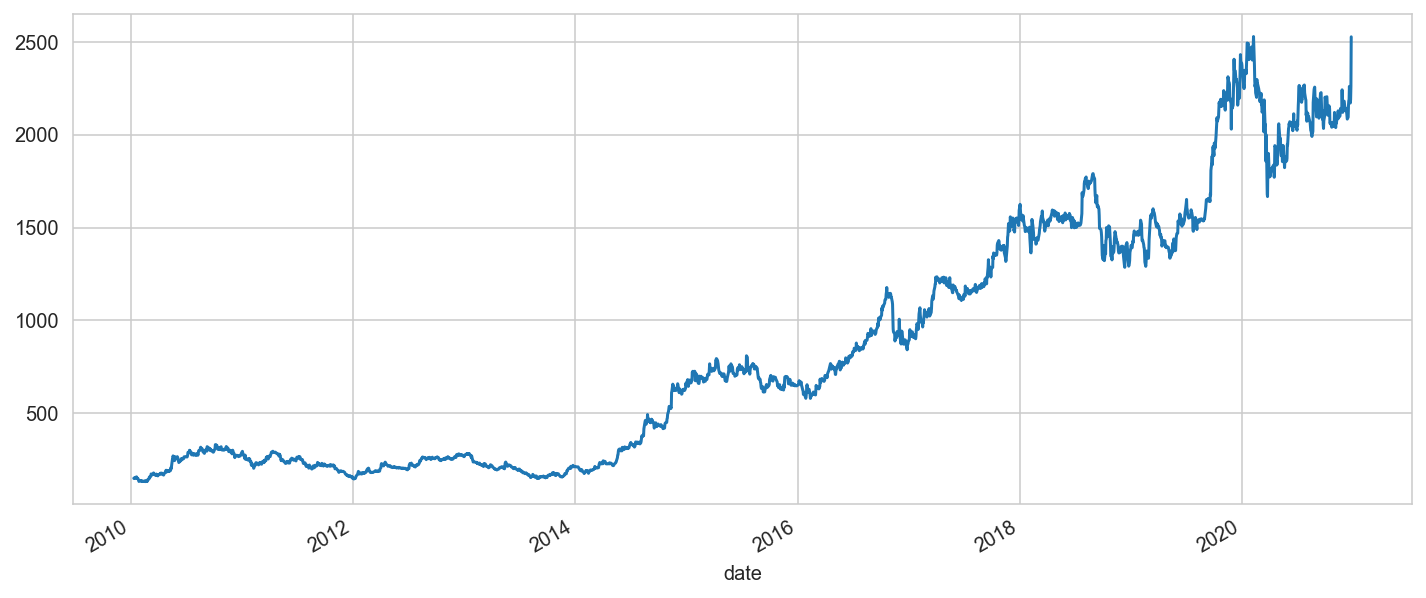

In [12]:
prices.loc['WHIR'].close.plot(figsize=(12,5));

In [13]:
dtale.show(prices)

In [14]:
fromdate=datetime.datetime(2010, 1, 1)
todate=datetime.datetime(2020, 12, 24)

In [15]:
# Calculate momentum
def momentum_func(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized * (rvalue ** 2)

In [16]:
class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    params = dict(period=126)
    func = momentum_func

In [17]:
class StrategyEqWt(bt.Strategy):
    params = dict(
        # parametrize the Momentum and its period
        momentum=Momentum,
        momentum_period=126,
        num_positions=30,
        rebalance_days = [1,4],

        printlog=True,
        reserve=0.00  # 5% reserve capital
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function '''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            if isinstance(dt, float):
                dt = bt.num2date(dt)
            print("%s, %s" % (dt.isoformat(), txt))

    def __init__(self):
        self.securities = self.datas
        self.inds = collections.defaultdict(dict)
        for d in self.datas:
            self.inds[d]['mom'] = self.p.momentum(d, period=self.p.momentum_period)

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def rebalance(self):
        rankings = list(self.securities)
        rankings.sort(key=lambda s: self.inds[s]['mom'][0], reverse=True)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        pos_size = (1.0 - self.p.reserve) / self.p.num_positions

        # Sell stocks no longer meeting ranking filter.
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i > self.p.num_positions:
                    self.close(d)
                    self.log('Leave {} - Rank {:.2f}'.format(d._name, i)) 
        
        # Buy and rebalance stocks with remaining cash
        for i, d in enumerate(rankings[:self.p.num_positions]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            if not self.getposition(d).size:
                self.order_target_percent(d, target=pos_size)
                self.log('Buy {} - Rank {:.2f}'.format(d._name, i)) 

        # Final portfolio
        portfolio = []
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i < self.p.num_positions:
                    portfolio.append(d._name)
        self.log('Portfolio - %s'% portfolio)

    def next_open(self):
        dt = self.data.datetime.datetime()
        if dt.weekday() in self.p.rebalance_days:
            self.rebalance()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price, order.executed.value, order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value,order.executed.comm))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
    
    def stop(self):
        self.log('| %2d | %2d |  %.2f |' %
                 (self.p.momentum_period, self.p.num_positions, self.broker.getvalue()), doprint=True)

In [18]:
# Model Settings
startcash = 500000
momentum_period = 126 #days
num_positions = 20
reserve = 0.05
printlog=True,


# Commission and Slippage Settings
commission = 0.0025

In [19]:
cerebro = bt.Cerebro(stdstats=False, cheat_on_open=True)
cerebro.broker.set_coc(True)
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission=commission)

In [20]:
# Add securities as datas1:
for ticker, data in prices.groupby(level=0):
    if ticker in tickers:
        print(f"Adding ticker: {ticker}")
        data = bt.feeds.PandasData(dataname=data.droplevel(level=0),
                                   name=str(ticker),
                                   fromdate=fromdate,
                                   todate=todate,
                                   plot=False)
        cerebro.adddata(data)

Adding ticker: ABOT
Adding ticker: ABUJ
Adding ticker: ACC
Adding ticker: ADEL
Adding ticker: AMAR
Adding ticker: APLH
Adding ticker: APLO
Adding ticker: APSE
Adding ticker: ARBN
Adding ticker: ARTI
Adding ticker: ASOK
Adding ticker: ASPN
Adding ticker: AXBK
Adding ticker: BAJA
Adding ticker: BAJE
Adding ticker: BATA
Adding ticker: BBRM
Adding ticker: BFRG
Adding ticker: BHEL
Adding ticker: BION
Adding ticker: BJAT
Adding ticker: BJFN
Adding ticker: BJFS
Adding ticker: BLKI
Adding ticker: BOB
Adding ticker: BOI
Adding ticker: BOSH
Adding ticker: BPCL
Adding ticker: BRGR
Adding ticker: BRIT
Adding ticker: BRTI
Adding ticker: CADI
Adding ticker: CAST
Adding ticker: CCRI
Adding ticker: CESC
Adding ticker: CHLA
Adding ticker: CNBK
Adding ticker: COLG
Adding ticker: CORF
Adding ticker: CTBK
Adding ticker: CUMM
Adding ticker: DABU
Adding ticker: DIVI
Adding ticker: DLF
Adding ticker: EDEL
Adding ticker: EMAM
Adding ticker: ESCO
Adding ticker: EXID
Adding ticker: FED
Adding ticker: FOHE
Addin

In [21]:
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

cerebro.addstrategy(StrategyEqWt,
                    momentum_period = momentum_period,
                    num_positions = num_positions,
                    printlog = printlog,
                    reserve = reserve
                   )

0

In [22]:
%%time
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run the strategy. Results will be output from stop.
results_eq_wts = cerebro.run()

# # Run over everything
# cerebro.run(maxcpus=1)

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 500000.00
2010-08-13T00:00:00, Buy HVEL - Rank 0.00
2010-08-13T00:00:00, Buy GODR - Rank 1.00
2010-08-13T00:00:00, Buy PIIL - Rank 2.00
2010-08-13T00:00:00, Buy DIVI - Rank 3.00
2010-08-13T00:00:00, Buy COLG - Rank 4.00
2010-08-13T00:00:00, Buy WHIR - Rank 5.00
2010-08-13T00:00:00, Buy CHLA - Rank 6.00
2010-08-13T00:00:00, Buy BJFN - Rank 7.00
2010-08-13T00:00:00, Buy CORF - Rank 8.00
2010-08-13T00:00:00, Buy TVSM - Rank 9.00
2010-08-13T00:00:00, Buy PFIZ - Rank 10.00
2010-08-13T00:00:00, Buy TITN - Rank 11.00
2010-08-13T00:00:00, Buy NATP - Rank 12.00
2010-08-13T00:00:00, Buy MMFS - Rank 13.00
2010-08-13T00:00:00, Buy EMAM - Rank 14.00
2010-08-13T00:00:00, Buy MINT - Rank 15.00
2010-08-13T00:00:00, Buy BAJA - Rank 16.00
2010-08-13T00:00:00, Buy BRGR - Rank 17.00
2010-08-13T00:00:00, Buy LICH - Rank 18.00
2010-08-13T00:00:00, Buy UBBW - Rank 19.00
2010-08-13T00:00:00, Portfolio - []
2010-08-13T00:00:00, BUY EXECUTED, Price: 377.55, Cost: 23408.10, Comm 58.52
2

2010-11-16T00:00:00, Leave TVSM - Rank 21.00
2010-11-16T00:00:00, Buy PLNG - Rank 15.00
2010-11-16T00:00:00, Buy INBK - Rank 16.00
2010-11-16T00:00:00, Portfolio - ['MNFL', 'UBBW', 'VGUA', 'JUBI', 'BJFN', 'NATP', 'MMFS', 'CNBK', 'TAMO', 'TITN', 'BOI', 'CORF', 'INED', 'HALC', 'BBRM', 'BRGR', 'SRTR', 'SBI']
2010-11-16T00:00:00, Order Canceled/Margin/Rejected
2010-11-16T00:00:00, SELL EXECUTED, Price: 75.70, Cost: 23727.60, Comm 63.97
2010-11-16T00:00:00, BUY EXECUTED, Price: 57.88, Cost: 26393.28, Comm 65.98
2010-11-19T00:00:00, Leave BRGR - Rank 25.00
2010-11-19T00:00:00, Buy INBK - Rank 14.00
2010-11-19T00:00:00, Buy ARTI - Rank 19.00
2010-11-19T00:00:00, Portfolio - ['MNFL', 'UBBW', 'VGUA', 'JUBI', 'BJFN', 'NATP', 'CNBK', 'MMFS', 'TAMO', 'TITN', 'INED', 'BOI', 'CORF', 'HALC', 'PLNG', 'BBRM', 'SRTR', 'SBI']
2010-11-19T00:00:00, Order Canceled/Margin/Rejected
2010-11-19T00:00:00, SELL EXECUTED, Price: 30.61, Cost: 23737.72, Comm 57.09
2010-11-19T00:00:00, BUY EXECUTED, Price: 265.15, Co

2011-01-18T00:00:00, Leave TITN - Rank 21.00
2011-01-18T00:00:00, Leave MMFS - Rank 23.00
2011-01-18T00:00:00, Leave CNBK - Rank 27.00
2011-01-18T00:00:00, Buy MAHM - Rank 14.00
2011-01-18T00:00:00, Buy IPCA - Rank 17.00
2011-01-18T00:00:00, Buy INFY - Rank 18.00
2011-01-18T00:00:00, Buy HZNC - Rank 19.00
2011-01-18T00:00:00, Portfolio - ['HALC', 'SUN', 'TCS', 'ARBN', 'TAMO', 'REXP', 'NATP', 'GLEN', 'JUBI', 'NEST', 'REDY', 'LUPN', 'CADI', 'PAGE', 'UBBW', 'PLNG']
2011-01-18T00:00:00, Order Canceled/Margin/Rejected
2011-01-18T00:00:00, SELL EXECUTED, Price: 174.11, Cost: 23721.21, Comm 69.21
2011-01-18T00:00:00, SELL EXECUTED, Price: 130.66, Cost: 23704.24, Comm 64.02
2011-01-18T00:00:00, SELL EXECUTED, Price: 536.25, Cost: 24531.00, Comm 45.58
2011-01-18T00:00:00, BUY EXECUTED, Price: 373.05, Cost: 23502.15, Comm 58.76
2011-01-18T00:00:00, BUY EXECUTED, Price: 322.65, Cost: 23553.45, Comm 58.88
2011-01-18T00:00:00, BUY EXECUTED, Price: 412.12, Cost: 23490.84, Comm 58.73
2011-01-21T00:00

2011-04-08T00:00:00, Leave PNBK - Rank 23.00
2011-04-08T00:00:00, Leave VGUA - Rank 27.00
2011-04-08T00:00:00, Leave APSE - Rank 31.00
2011-04-08T00:00:00, Buy GAIL - Rank 17.00
2011-04-08T00:00:00, Buy IHTL - Rank 18.00
2011-04-08T00:00:00, Buy ORCL - Rank 19.00
2011-04-08T00:00:00, Portfolio - ['PIIL', 'PAGE', 'PFIZ', 'HCLT', 'TCS', 'OILI', 'BRIT', 'BHEL', 'ONGC', 'MRTI', 'NITT', 'HZNC', 'BPCL', 'CADI', 'CAST', 'CCRI', 'GSPT']
2011-04-08T00:00:00, SELL EXECUTED, Price: 237.74, Cost: 21781.00, Comm 59.44
2011-04-08T00:00:00, SELL EXECUTED, Price: 12.70, Cost: 21987.07, Comm 61.18
2011-04-08T00:00:00, SELL EXECUTED, Price: 154.40, Cost: 21977.20, Comm 64.46
2011-04-08T00:00:00, BUY EXECUTED, Price: 132.51, Cost: 23719.29, Comm 59.30
2011-04-08T00:00:00, BUY EXECUTED, Price: 89.25, Cost: 23740.50, Comm 59.35
2011-04-08T00:00:00, BUY EXECUTED, Price: 2063.10, Cost: 22694.10, Comm 56.74
2011-04-15T00:00:00, Leave CCRI - Rank 28.00
2011-04-15T00:00:00, Leave CAST - Rank 44.00
2011-04-15T00

2011-07-01T00:00:00, Leave FOHE - Rank 25.00
2011-07-01T00:00:00, Buy CORF - Rank 14.00
2011-07-01T00:00:00, Buy AMAR - Rank 16.00
2011-07-01T00:00:00, Buy APLO - Rank 19.00
2011-07-01T00:00:00, Portfolio - ['BATA', 'PIIL', 'JUBI', 'TITN', 'MOSS', 'BLKI', 'LICH', 'DIVI', 'VGUA', 'MAXI', 'TREN', 'INED', 'FED', 'CADI', 'PAGE', 'MRCO', 'GODR']
2011-07-01T00:00:00, Order Canceled/Margin/Rejected
2011-07-01T00:00:00, SELL EXECUTED, Price: 1461.15, Cost: 21062.70, Comm 65.75
2011-07-01T00:00:00, SELL EXECUTED, Price: 161.45, Cost: 24210.90, Comm 59.33
2011-07-01T00:00:00, BUY EXECUTED, Price: 348.10, Cost: 25411.30, Comm 63.53
2011-07-01T00:00:00, BUY EXECUTED, Price: 112.58, Cost: 25555.66, Comm 63.89
2011-07-05T00:00:00, Buy APLO - Rank 15.00
2011-07-05T00:00:00, Portfolio - ['BATA', 'PIIL', 'JUBI', 'TITN', 'BLKI', 'LICH', 'MOSS', 'DIVI', 'VGUA', 'TREN', 'INED', 'MAXI', 'FED', 'CORF', 'AMAR', 'PAGE', 'CADI', 'GODR', 'MRCO']
2011-07-05T00:00:00, Order Canceled/Margin/Rejected
2011-07-08T00:

2011-10-04T00:00:00, Buy REXP - Rank 12.00
2011-10-04T00:00:00, Buy LUPN - Rank 17.00
2011-10-04T00:00:00, Buy APLH - Rank 18.00
2011-10-04T00:00:00, Portfolio - ['BATA', 'PIIL', 'PAGE', 'VODA', 'IGAS', 'NAFL', 'PLNG', 'BLKI', 'JUBI', 'MAXI', 'BRIT', 'GGAS', 'SANO', 'HLL', 'HROM', 'ASPN', 'NEST']
2011-10-04T00:00:00, Order Canceled/Margin/Rejected
2011-10-04T00:00:00, Order Canceled/Margin/Rejected
2011-10-04T00:00:00, SELL EXECUTED, Price: 108.72, Cost: 23960.60, Comm 63.87
2011-10-04T00:00:00, BUY EXECUTED, Price: 121.90, Cost: 24867.60, Comm 62.17
2011-10-07T00:00:00, Leave NEST - Rank 21.00
2011-10-07T00:00:00, Leave AMAR - Rank 23.00
2011-10-07T00:00:00, Buy LUPN - Rank 17.00
2011-10-07T00:00:00, Buy APLH - Rank 18.00
2011-10-07T00:00:00, Buy COLG - Rank 19.00
2011-10-07T00:00:00, Portfolio - ['PIIL', 'BATA', 'PAGE', 'VODA', 'IGAS', 'NAFL', 'PLNG', 'BLKI', 'REXP', 'GGAS', 'MAXI', 'SANO', 'BRIT', 'JUBI', 'HLL', 'HROM', 'ASPN']
2011-10-07T00:00:00, Order Canceled/Margin/Rejected
201

2011-12-30T00:00:00, Buy BJAT - Rank 19.00
2011-12-30T00:00:00, Portfolio - ['TRCE', 'REXP', 'ABUJ', 'ACC', 'ULTC', 'HLL', 'SHCM', 'BAJA', 'GRAS', 'SANO', 'PAGE', 'APLH', 'DABU', 'GAIL', 'BAJE', 'GOCP', 'IOC', 'INED', 'CADI']
2011-12-30T00:00:00, Order Canceled/Margin/Rejected
2012-01-03T00:00:00, Leave PFIZ - Rank 21.00
2012-01-03T00:00:00, Buy PIDI - Rank 19.00
2012-01-03T00:00:00, Portfolio - ['TRCE', 'ABUJ', 'ACC', 'REXP', 'ULTC', 'HLL', 'SHCM', 'GRAS', 'BAJA', 'SANO', 'GOCP', 'GAIL', 'BAJE', 'DABU', 'APLH', 'PAGE', 'IOC', 'INED', 'CADI']
2012-01-03T00:00:00, SELL EXECUTED, Price: 1099.00, Cost: 23265.90, Comm 57.70
2012-01-03T00:00:00, BUY EXECUTED, Price: 142.25, Cost: 23186.75, Comm 57.97
2012-01-06T00:00:00, Leave PAGE - Rank 45.00
2012-01-06T00:00:00, Buy BJAT - Rank 13.00
2012-01-06T00:00:00, Buy CTBK - Rank 15.00
2012-01-06T00:00:00, Portfolio - ['TRCE', 'ABUJ', 'HLL', 'ACC', 'SHCM', 'REXP', 'ULTC', 'GRAS', 'SANO', 'BAJA', 'GOCP', 'BAJE', 'GAIL', 'DABU', 'IOC', 'APLH', 'PIDI

2012-03-16T00:00:00, Buy IPCA - Rank 12.00
2012-03-16T00:00:00, Portfolio - ['TAMO', 'SHCM', 'HVEL', 'APLO', 'MINT', 'PIRA', 'WIPR', 'MRF', 'TRCE', 'TAGL', 'SUN', 'ULTC', 'ARTI', 'GRAS', 'NATP', 'LICH', 'TCS', 'REDY', 'ZEE']
2012-03-16T00:00:00, Order Canceled/Margin/Rejected
2012-03-20T00:00:00, Buy IPCA - Rank 10.00
2012-03-20T00:00:00, Portfolio - ['TAMO', 'SHCM', 'HVEL', 'APLO', 'MRF', 'PIRA', 'MINT', 'WIPR', 'TRCE', 'TAGL', 'ULTC', 'SUN', 'ARTI', 'NATP', 'GRAS', 'LICH', 'REDY', 'ZEE', 'ACC']
2012-03-20T00:00:00, Order Canceled/Margin/Rejected
2012-03-23T00:00:00, Leave REDY - Rank 22.00
2012-03-23T00:00:00, Leave ACC - Rank 23.00
2012-03-23T00:00:00, Leave ZEE - Rank 26.00
2012-03-23T00:00:00, Leave TCS - Rank 28.00
2012-03-23T00:00:00, Buy IPCA - Rank 7.00
2012-03-23T00:00:00, Buy AMAR - Rank 16.00
2012-03-23T00:00:00, Buy SUTV - Rank 18.00
2012-03-23T00:00:00, Buy BLKI - Rank 19.00
2012-03-23T00:00:00, Portfolio - ['TAMO', 'SHCM', 'HVEL', 'APLO', 'MRF', 'PIRA', 'MINT', 'TRCE', '

2012-06-29T00:00:00, Leave BJFN - Rank 21.00
2012-06-29T00:00:00, Buy ITC - Rank 18.00
2012-06-29T00:00:00, Portfolio - ['BRGR', 'MINT', 'EMAM', 'NATP', 'GOCP', 'ASPN', 'BATA', 'ARTI', 'JUBI', 'NITT', 'BJFS', 'BPCL', 'BLKI', 'MRF', 'BOSH', 'AMAR', 'INED', 'MAXI', 'PROC']
2012-06-29T00:00:00, SELL EXECUTED, Price: 88.65, Cost: 27090.01, Comm 71.58
2012-06-29T00:00:00, BUY EXECUTED, Price: 171.64, Cost: 25231.08, Comm 63.08
2012-07-03T00:00:00, Portfolio - ['MINT', 'BRGR', 'EMAM', 'GOCP', 'ASPN', 'NATP', 'BATA', 'ARTI', 'NITT', 'JUBI', 'BJFS', 'BPCL', 'BOSH', 'BLKI', 'MRF', 'AMAR', 'ITC', 'INED', 'MAXI', 'PROC']
2012-07-06T00:00:00, Leave MAXI - Rank 21.00
2012-07-06T00:00:00, Leave INED - Rank 22.00
2012-07-06T00:00:00, Buy GLEN - Rank 15.00
2012-07-06T00:00:00, Buy DIVI - Rank 18.00
2012-07-06T00:00:00, Portfolio - ['MINT', 'BRGR', 'EMAM', 'GOCP', 'ASPN', 'ARTI', 'BATA', 'NITT', 'NATP', 'JUBI', 'BPCL', 'BJFS', 'BOSH', 'ITC', 'BLKI', 'AMAR', 'PROC', 'MRF']
2012-07-06T00:00:00, SELL EXEC

2012-09-21T00:00:00, Order Canceled/Margin/Rejected
2012-09-21T00:00:00, SELL EXECUTED, Price: 37.31, Cost: 26216.00, Comm 86.56
2012-09-21T00:00:00, SELL EXECUTED, Price: 167.88, Cost: 25787.35, Comm 65.05
2012-09-21T00:00:00, BUY EXECUTED, Price: 257.55, Cost: 27557.85, Comm 68.89
2012-09-21T00:00:00, BUY EXECUTED, Price: 1837.60, Cost: 27564.00, Comm 68.91
2012-09-21T00:00:00, BUY EXECUTED, Price: 311.88, Cost: 27445.44, Comm 68.61
2012-09-25T00:00:00, Leave NMDC - Rank 21.00
2012-09-25T00:00:00, Leave MRCO - Rank 24.00
2012-09-25T00:00:00, Buy TRCE - Rank 16.00
2012-09-25T00:00:00, Buy ABUJ - Rank 17.00
2012-09-25T00:00:00, Buy CHLA - Rank 19.00
2012-09-25T00:00:00, Portfolio - ['VGUA', 'DIVI', 'ZEE', 'GLEN', 'GOCP', 'BJFN', 'UNSP', 'HLL', 'MINT', 'IPCA', 'CADI', 'SUN', 'TREN', 'CESC', 'DABU', 'ULTC', 'ITC']
2012-09-25T00:00:00, Order Canceled/Margin/Rejected
2012-09-25T00:00:00, Order Canceled/Margin/Rejected
2012-09-25T00:00:00, SELL EXECUTED, Price: 188.40, Cost: 27604.80, Comm 

2012-12-21T00:00:00, Buy APLH - Rank 14.00
2012-12-21T00:00:00, Portfolio - ['UNSP', 'ARBN', 'VGUA', 'AMAR', 'MOSS', 'UBBW', 'MMFS', 'SHCM', 'TAGL', 'BJFN', 'ZEE', 'MAHM', 'TRCE', 'TITN', 'MRTI', 'HCLT', 'GODI', 'ULTC', 'CHLA']
2012-12-21T00:00:00, Order Canceled/Margin/Rejected
2012-12-28T00:00:00, Leave GODI - Rank 21.00
2012-12-28T00:00:00, Leave ULTC - Rank 23.00
2012-12-28T00:00:00, Buy APLH - Rank 13.00
2012-12-28T00:00:00, Buy ARTI - Rank 16.00
2012-12-28T00:00:00, Buy SUTV - Rank 18.00
2012-12-28T00:00:00, Buy MAXI - Rank 19.00
2012-12-28T00:00:00, Portfolio - ['UNSP', 'ARBN', 'MOSS', 'AMAR', 'UBBW', 'VGUA', 'MMFS', 'SHCM', 'TAGL', 'BJFN', 'ZEE', 'TRCE', 'MAHM', 'TITN', 'MRTI', 'HCLT']
2012-12-28T00:00:00, Order Canceled/Margin/Rejected
2012-12-28T00:00:00, Order Canceled/Margin/Rejected
2012-12-28T00:00:00, SELL EXECUTED, Price: 312.30, Cost: 31742.40, Comm 79.64
2012-12-28T00:00:00, SELL EXECUTED, Price: 1971.75, Cost: 27564.00, Comm 73.94
2012-12-28T00:00:00, BUY EXECUTED, P

2013-03-15T00:00:00, Leave BJAT - Rank 22.00
2013-03-15T00:00:00, Buy PIDI - Rank 12.00
2013-03-15T00:00:00, Buy GLEN - Rank 17.00
2013-03-15T00:00:00, Portfolio - ['UNSP', 'VODA', 'TRCE', 'CHLA', 'BRGR', 'MOSS', 'AMAR', 'SUTV', 'HCLT', 'AXBK', 'PIRA', 'INBK', 'IOC', 'CTBK', 'MRF', 'ASPN', 'ZEE', 'APSE']
2013-03-15T00:00:00, Order Canceled/Margin/Rejected
2013-03-15T00:00:00, SELL EXECUTED, Price: 907.95, Cost: 30088.60, Comm 70.37
2013-03-15T00:00:00, BUY EXECUTED, Price: 249.65, Cost: 30207.65, Comm 75.52
2013-03-19T00:00:00, Leave APSE - Rank 21.00
2013-03-19T00:00:00, Buy GLEN - Rank 16.00
2013-03-19T00:00:00, Buy DLF - Rank 18.00
2013-03-19T00:00:00, Portfolio - ['VODA', 'UNSP', 'TRCE', 'BRGR', 'CHLA', 'MOSS', 'HCLT', 'SUTV', 'AMAR', 'AXBK', 'PIRA', 'PIDI', 'IOC', 'ASPN', 'MRF', 'INBK', 'CTBK', 'ZEE']
2013-03-19T00:00:00, Order Canceled/Margin/Rejected
2013-03-19T00:00:00, SELL EXECUTED, Price: 136.00, Cost: 30128.85, Comm 72.42
2013-03-19T00:00:00, BUY EXECUTED, Price: 499.85, Co

2013-06-18T00:00:00, Leave TCS - Rank 21.00
2013-06-18T00:00:00, Buy PAGE - Rank 14.00
2013-06-18T00:00:00, Portfolio - ['BRGR', 'SUN', 'CCRI', 'PIDI', 'BRIT', 'LUPN', 'DABU', 'UNSP', 'GOCP', 'ITC', 'VODA', 'EMAM', 'APLH', 'OILI', 'CAST', 'IPCA', 'IGAS', 'HCLT', 'SANO']
2013-06-18T00:00:00, SELL EXECUTED, Price: 696.92, Cost: 28189.20, Comm 67.95
2013-06-18T00:00:00, BUY EXECUTED, Price: 4151.70, Cost: 29061.90, Comm 72.65
2013-06-21T00:00:00, Buy KTKM - Rank 16.00
2013-06-21T00:00:00, Portfolio - ['BRGR', 'SUN', 'BRIT', 'LUPN', 'PIDI', 'CCRI', 'DABU', 'UNSP', 'EMAM', 'ITC', 'APLH', 'VODA', 'GOCP', 'PAGE', 'IPCA', 'OILI', 'CAST', 'IGAS', 'HCLT']
2013-06-21T00:00:00, Order Canceled/Margin/Rejected
2013-06-25T00:00:00, Buy KTKM - Rank 15.00
2013-06-25T00:00:00, Portfolio - ['BRGR', 'SUN', 'BRIT', 'LUPN', 'DABU', 'UNSP', 'PIDI', 'CCRI', 'EMAM', 'APLH', 'PAGE', 'VODA', 'ITC', 'GOCP', 'IPCA', 'OILI', 'CAST', 'SANO', 'HCLT']
2013-06-25T00:00:00, Order Canceled/Margin/Rejected
2013-06-28T00:0

2013-09-13T00:00:00, Order Canceled/Margin/Rejected
2013-09-13T00:00:00, Order Canceled/Margin/Rejected
2013-09-17T00:00:00, Leave UNSP - Rank 21.00
2013-09-17T00:00:00, Buy ORCL - Rank 17.00
2013-09-17T00:00:00, Buy MINT - Rank 18.00
2013-09-17T00:00:00, Buy WIPR - Rank 19.00
2013-09-17T00:00:00, Portfolio - ['ESCO', 'VODA', 'BRIT', 'NATP', 'IPCA', 'LUPN', 'HCLT', 'HLL', 'TEML', 'REDY', 'SUN', 'HROM', 'TCS', 'PAGE', 'BION', 'DABU', 'BATA']
2013-09-17T00:00:00, Order Canceled/Margin/Rejected
2013-09-17T00:00:00, Order Canceled/Margin/Rejected
2013-09-17T00:00:00, SELL EXECUTED, Price: 501.35, Cost: 29210.31, Comm 73.95
2013-09-17T00:00:00, BUY EXECUTED, Price: 2608.68, Cost: 28695.48, Comm 71.74
2013-09-20T00:00:00, Buy WIPR - Rank 16.00
2013-09-20T00:00:00, Buy MINT - Rank 17.00
2013-09-20T00:00:00, Portfolio - ['ESCO', 'VODA', 'BRIT', 'NATP', 'HCLT', 'TEML', 'IPCA', 'LUPN', 'HROM', 'TCS', 'HLL', 'REDY', 'SUN', 'BION', 'PAGE', 'DABU', 'BATA', 'ORCL']
2013-09-20T00:00:00, Order Cancele

2013-12-13T00:00:00, Order Canceled/Margin/Rejected
2013-12-13T00:00:00, SELL EXECUTED, Price: 966.27, Cost: 28977.90, Comm 72.47
2013-12-13T00:00:00, SELL EXECUTED, Price: 345.05, Cost: 32187.50, Comm 88.85
2013-12-13T00:00:00, BUY EXECUTED, Price: 374.96, Cost: 32996.48, Comm 82.49
2013-12-13T00:00:00, Order Canceled/Margin/Rejected
2013-12-17T00:00:00, Leave INFY - Rank 21.00
2013-12-17T00:00:00, Leave BION - Rank 22.00
2013-12-17T00:00:00, Buy JSTL - Rank 12.00
2013-12-17T00:00:00, Buy NMDC - Rank 17.00
2013-12-17T00:00:00, Buy INED - Rank 18.00
2013-12-17T00:00:00, Buy AMAR - Rank 19.00
2013-12-17T00:00:00, Portfolio - ['MINT', 'PIIL', 'TEML', 'NATP', 'TVSM', 'NAFL', 'ESCO', 'ARBN', 'INDB', 'TISC', 'BFRG', 'TAMO', 'HCLT', 'GGAS', 'BRIT', 'MOSS']
2013-12-17T00:00:00, Order Canceled/Margin/Rejected
2013-12-17T00:00:00, Order Canceled/Margin/Rejected
2013-12-17T00:00:00, SELL EXECUTED, Price: 428.65, Cost: 30675.38, Comm 87.87
2013-12-17T00:00:00, SELL EXECUTED, Price: 65.38, Cost: 2

2014-03-11T00:00:00, Portfolio - ['ARBN', 'TVSM', 'APLO', 'INED', 'VOLT', 'PIIL', 'NITT', 'BLKI', 'BFRG', 'DIVI', 'MOSS', 'MRF', 'HCLT', 'ADEL', 'PAGE', 'INDB', 'CESC', 'ARTI', 'NAFL']
2014-03-11T00:00:00, Order Canceled/Margin/Rejected
2014-03-14T00:00:00, Leave NAFL - Rank 21.00
2014-03-14T00:00:00, Leave INDB - Rank 23.00
2014-03-14T00:00:00, Buy CADI - Rank 9.00
2014-03-14T00:00:00, Buy IHTL - Rank 18.00
2014-03-14T00:00:00, Buy MNFL - Rank 19.00
2014-03-14T00:00:00, Portfolio - ['ARBN', 'TVSM', 'APLO', 'INED', 'VOLT', 'BLKI', 'NITT', 'PIIL', 'BFRG', 'DIVI', 'HCLT', 'MOSS', 'PAGE', 'MRF', 'ADEL', 'ARTI', 'CESC']
2014-03-14T00:00:00, Order Canceled/Margin/Rejected
2014-03-14T00:00:00, SELL EXECUTED, Price: 55.94, Cost: 32800.95, Comm 87.13
2014-03-14T00:00:00, SELL EXECUTED, Price: 18.00, Cost: 33599.50, Comm 67.05
2014-03-14T00:00:00, BUY EXECUTED, Price: 191.90, Cost: 38188.10, Comm 95.47
2014-03-14T00:00:00, BUY EXECUTED, Price: 63.33, Cost: 38187.99, Comm 95.47
2014-03-18T00:00:

2014-06-20T00:00:00, Buy REXP - Rank 11.00
2014-06-20T00:00:00, Buy EDEL - Rank 14.00
2014-06-20T00:00:00, Buy UNBK - Rank 18.00
2014-06-20T00:00:00, Buy PNBK - Rank 19.00
2014-06-20T00:00:00, Portfolio - ['BLKI', 'ADEL', 'APLO', 'HPCL', 'VOLT', 'ASOK', 'TVSM', 'ARTI', 'PWFC', 'NAFL', 'BPCL', 'ARBN', 'CCRI', 'SHCM', 'IOC', 'BFRG']
2014-06-20T00:00:00, Order Canceled/Margin/Rejected
2014-06-20T00:00:00, Order Canceled/Margin/Rejected
2014-06-20T00:00:00, Order Canceled/Margin/Rejected
2014-06-20T00:00:00, Order Canceled/Margin/Rejected
2014-06-24T00:00:00, Leave IOC - Rank 21.00
2014-06-24T00:00:00, Leave MOSS - Rank 22.00
2014-06-24T00:00:00, Buy REXP - Rank 8.00
2014-06-24T00:00:00, Buy EDEL - Rank 12.00
2014-06-24T00:00:00, Buy UNBK - Rank 16.00
2014-06-24T00:00:00, Buy BAJE - Rank 17.00
2014-06-24T00:00:00, Buy LART - Rank 18.00
2014-06-24T00:00:00, Buy PNBK - Rank 19.00
2014-06-24T00:00:00, Portfolio - ['BLKI', 'ADEL', 'APLO', 'ASOK', 'VOLT', 'HPCL', 'PWFC', 'ARTI', 'TVSM', 'NAFL',

2014-08-08T00:00:00, Buy CHLA - Rank 16.00
2014-08-08T00:00:00, Portfolio - ['EDEL', 'NAFL', 'ARTI', 'REXP', 'ASOK', 'BAJE', 'BLKI', 'UNBK', 'TVSM', 'GGAS', 'CNBK', 'BFRG', 'PWFC', 'UPLL', 'NALU', 'WHIR', 'RECM', 'CCRI', 'TOPO']
2014-08-08T00:00:00, Order Canceled/Margin/Rejected
2014-08-12T00:00:00, Leave RECM - Rank 21.00
2014-08-12T00:00:00, Buy CHLA - Rank 16.00
2014-08-12T00:00:00, Buy HALC - Rank 17.00
2014-08-12T00:00:00, Buy MAXI - Rank 19.00
2014-08-12T00:00:00, Portfolio - ['EDEL', 'ARTI', 'NAFL', 'REXP', 'ASOK', 'BAJE', 'BLKI', 'TVSM', 'GGAS', 'BFRG', 'UNBK', 'CNBK', 'NALU', 'UPLL', 'WHIR', 'PWFC', 'CCRI']
2014-08-12T00:00:00, Order Canceled/Margin/Rejected
2014-08-12T00:00:00, Order Canceled/Margin/Rejected
2014-08-12T00:00:00, Order Canceled/Margin/Rejected
2014-08-12T00:00:00, SELL EXECUTED, Price: 149.35, Cost: 55277.10, Comm 110.15
2014-08-19T00:00:00, Leave PWFC - Rank 21.00
2014-08-19T00:00:00, Leave TOPO - Rank 26.00
2014-08-19T00:00:00, Buy BBRM - Rank 15.00
2014-08

2014-11-07T00:00:00, Order Canceled/Margin/Rejected
2014-11-07T00:00:00, Order Canceled/Margin/Rejected
2014-11-07T00:00:00, SELL EXECUTED, Price: 5833.55, Cost: 52475.50, Comm 145.84
2014-11-07T00:00:00, SELL EXECUTED, Price: 126.89, Cost: 59469.08, Comm 153.54
2014-11-07T00:00:00, SELL EXECUTED, Price: 97.97, Cost: 52801.28, Comm 162.63
2014-11-07T00:00:00, BUY EXECUTED, Price: 665.00, Cost: 60515.00, Comm 151.29
2014-11-07T00:00:00, BUY EXECUTED, Price: 1419.35, Cost: 59612.70, Comm 149.03
2014-11-07T00:00:00, BUY EXECUTED, Price: 3288.35, Cost: 59190.30, Comm 147.98
2014-11-11T00:00:00, Buy CADI - Rank 16.00
2014-11-11T00:00:00, Buy BJFN - Rank 19.00
2014-11-11T00:00:00, Portfolio - ['BBRM', 'TVSM', 'ARTI', 'ABOT', 'NATP', 'WHIR', 'BRIT', 'EMAM', 'VGUA', 'BFRG', 'BRGR', 'AMAR', 'PIIL', 'ARBN', 'LUPN', 'MINT', 'ASOK', 'MRTI']
2014-11-11T00:00:00, Order Canceled/Margin/Rejected
2014-11-11T00:00:00, Order Canceled/Margin/Rejected
2014-11-14T00:00:00, Buy CADI - Rank 15.00
2014-11-14T0

2015-02-10T00:00:00, Leave VGUA - Rank 22.00
2015-02-10T00:00:00, Buy GGAS - Rank 14.00
2015-02-10T00:00:00, Buy PIDI - Rank 17.00
2015-02-10T00:00:00, Buy GSPT - Rank 18.00
2015-02-10T00:00:00, Buy AXBK - Rank 19.00
2015-02-10T00:00:00, Portfolio - ['BBRM', 'BAJE', 'WHIR', 'BJFN', 'ASOK', 'LICH', 'BRIT', 'AMAR', 'PAGE', 'ABOT', 'BOSH', 'MRF', 'INBK', 'PFIZ', 'TVSM', 'ARBN']
2015-02-10T00:00:00, Order Canceled/Margin/Rejected
2015-02-10T00:00:00, Order Canceled/Margin/Rejected
2015-02-10T00:00:00, Order Canceled/Margin/Rejected
2015-02-10T00:00:00, SELL EXECUTED, Price: 67.68, Cost: 54617.64, Comm 173.94
2015-02-10T00:00:00, BUY EXECUTED, Price: 612.10, Cost: 66718.90, Comm 166.80
2015-02-13T00:00:00, Leave CADI - Rank 26.00
2015-02-13T00:00:00, Buy PIDI - Rank 15.00
2015-02-13T00:00:00, Buy AXBK - Rank 18.00
2015-02-13T00:00:00, Buy GSPT - Rank 19.00
2015-02-13T00:00:00, Portfolio - ['BBRM', 'BAJE', 'BJFN', 'ASOK', 'WHIR', 'LICH', 'BRIT', 'PAGE', 'BOSH', 'AMAR', 'ABOT', 'INBK', 'MRF',

2015-05-05T00:00:00, Leave PROC - Rank 21.00
2015-05-05T00:00:00, Leave BAJE - Rank 22.00
2015-05-05T00:00:00, Buy NATP - Rank 15.00
2015-05-05T00:00:00, Buy UPLL - Rank 17.00
2015-05-05T00:00:00, Portfolio - ['SIEM', 'INDB', 'PIIL', 'NAFL', 'BFRG', 'ASOK', 'BOSH', 'BJFN', 'FOHE', 'PAGE', 'UBBW', 'BRIT', 'ADEL', 'UNSP', 'JSWE', 'LUPN', 'PIDI', 'EMAM']
2015-05-05T00:00:00, Order Canceled/Margin/Rejected
2015-05-05T00:00:00, SELL EXECUTED, Price: 6836.80, Cost: 71156.50, Comm 170.92
2015-05-05T00:00:00, SELL EXECUTED, Price: 109.08, Cost: 70491.60, Comm 175.07
2015-05-05T00:00:00, BUY EXECUTED, Price: 434.54, Cost: 69960.94, Comm 174.90
2015-05-08T00:00:00, Buy UPLL - Rank 12.00
2015-05-08T00:00:00, Buy CHLA - Rank 16.00
2015-05-08T00:00:00, Portfolio - ['SIEM', 'INDB', 'NAFL', 'PIIL', 'FOHE', 'BFRG', 'ASOK', 'ADEL', 'PAGE', 'BJFN', 'BRIT', 'NATP', 'UBBW', 'UNSP', 'BOSH', 'LUPN', 'JSWE', 'PIDI']
2015-05-08T00:00:00, Order Canceled/Margin/Rejected
2015-05-08T00:00:00, BUY EXECUTED, Price:

2015-07-24T00:00:00, Leave PIRA - Rank 21.00
2015-07-24T00:00:00, Buy CADI - Rank 18.00
2015-07-24T00:00:00, Portfolio - ['REXP', 'BRIT', 'NAFL', 'UPLL', 'NATP', 'GLEN', 'MRCO', 'ARBN', 'PAGE', 'BPCL', 'VOLT', 'FOHE', 'BJFN', 'HPCL', 'CCRI', 'BRTI', 'CHLA', 'ORCL', 'JUBI']
2015-07-24T00:00:00, Order Canceled/Margin/Rejected
2015-07-24T00:00:00, SELL EXECUTED, Price: 927.45, Cost: 67532.40, Comm 166.94
2015-07-28T00:00:00, Buy CADI - Rank 16.00
2015-07-28T00:00:00, Buy IOC - Rank 19.00
2015-07-28T00:00:00, Portfolio - ['REXP', 'BRIT', 'NAFL', 'UPLL', 'GLEN', 'NATP', 'MRCO', 'ARBN', 'BPCL', 'PAGE', 'VOLT', 'HPCL', 'BJFN', 'FOHE', 'BRTI', 'ORCL', 'CCRI', 'CHLA']
2015-07-28T00:00:00, Order Canceled/Margin/Rejected
2015-07-28T00:00:00, Order Canceled/Margin/Rejected
2015-07-31T00:00:00, Leave CCRI - Rank 21.00
2015-07-31T00:00:00, Buy CADI - Rank 14.00
2015-07-31T00:00:00, Buy IOC - Rank 17.00
2015-07-31T00:00:00, Buy MRTI - Rank 19.00
2015-07-31T00:00:00, Portfolio - ['REXP', 'BRIT', 'NAFL

2015-10-23T00:00:00, Leave HPCL - Rank 24.00
2015-10-23T00:00:00, Buy AMAR - Rank 15.00
2015-10-23T00:00:00, Buy IGAS - Rank 18.00
2015-10-23T00:00:00, Portfolio - ['REXP', 'ARTI', 'NAFL', 'ABOT', 'ESCO', 'ASOK', 'GODR', 'BRIT', 'DIVI', 'CUMM', 'SANO', 'BJAT', 'ZEE', 'REDY', 'BJFS', 'MRTI', 'NITT', 'IPCA']
2015-10-23T00:00:00, Order Canceled/Margin/Rejected
2015-10-23T00:00:00, SELL EXECUTED, Price: 177.23, Cost: 75301.67, Comm 194.51
2015-10-23T00:00:00, BUY EXECUTED, Price: 1001.85, Cost: 80148.00, Comm 200.37
2015-10-27T00:00:00, Leave IPCA - Rank 22.00
2015-10-27T00:00:00, Buy IGAS - Rank 18.00
2015-10-27T00:00:00, Buy APLH - Rank 19.00
2015-10-27T00:00:00, Portfolio - ['REXP', 'ARTI', 'NAFL', 'ABOT', 'ESCO', 'ASOK', 'GODR', 'BRIT', 'DIVI', 'SANO', 'CUMM', 'BJAT', 'ZEE', 'REDY', 'AMAR', 'NITT', 'BJFS', 'MRTI']
2015-10-27T00:00:00, Order Canceled/Margin/Rejected
2015-10-27T00:00:00, SELL EXECUTED, Price: 787.80, Cost: 75548.00, Comm 198.92
2015-10-27T00:00:00, BUY EXECUTED, Price: 9

2016-01-19T00:00:00, Leave DIVI - Rank 22.00
2016-01-19T00:00:00, Buy JSTL - Rank 15.00
2016-01-19T00:00:00, Buy BRGR - Rank 18.00
2016-01-19T00:00:00, Buy PROC - Rank 19.00
2016-01-19T00:00:00, Portfolio - ['NAFL', 'TREN', 'PLNG', 'REXP', 'SUTV', 'NATP', 'TVSM', 'TOPO', 'ARTI', 'MBFL', 'NITT', 'ABOT', 'ARBN', 'GODR', 'MINT', 'SANO', 'BJAT']
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, SELL EXECUTED, Price: 1070.70, Cost: 72900.30, Comm 176.67
2016-01-19T00:00:00, BUY EXECUTED, Price: 99.86, Cost: 76492.76, Comm 191.23
2016-01-22T00:00:00, Leave BJAT - Rank 53.00
2016-01-22T00:00:00, Buy BRGR - Rank 13.00
2016-01-22T00:00:00, Buy PROC - Rank 17.00
2016-01-22T00:00:00, Buy BJFN - Rank 18.00
2016-01-22T00:00:00, Portfolio - ['NAFL', 'TREN', 'PLNG', 'REXP', 'TVSM', 'NATP', 'TOPO', 'SUTV', 'ARTI', 'MBFL', 'ARBN', 'NITT', 'JSTL', 'ABOT', 'MINT', 'GODR', 'SANO']
2016-01-22T00:00:00, Order Canceled/Margin/Rejected

2016-04-22T00:00:00, Buy HLL - Rank 14.00
2016-04-22T00:00:00, Buy INFY - Rank 18.00
2016-04-22T00:00:00, Buy COLG - Rank 19.00
2016-04-22T00:00:00, Portfolio - ['MNFL', 'JSTL', 'BJFN', 'MRCO', 'TOPO', 'TISC', 'PLNG', 'CHLA', 'HZNC', 'IGAS', 'TRCE', 'HVEL', 'CAST', 'RELI', 'CUMM', 'TVSM']
2016-04-22T00:00:00, Order Canceled/Margin/Rejected
2016-04-22T00:00:00, Order Canceled/Margin/Rejected
2016-04-22T00:00:00, SELL EXECUTED, Price: 3609.95, Cost: 73850.70, Comm 189.52
2016-04-22T00:00:00, SELL EXECUTED, Price: 1131.90, Cost: 78516.00, Comm 203.74
2016-04-22T00:00:00, BUY EXECUTED, Price: 598.85, Cost: 80844.75, Comm 202.11
2016-04-22T00:00:00, BUY EXECUTED, Price: 884.20, Cost: 80462.20, Comm 201.16
2016-04-26T00:00:00, Leave BRIT - Rank 27.00
2016-04-26T00:00:00, Buy INFY - Rank 15.00
2016-04-26T00:00:00, Buy COLG - Rank 17.00
2016-04-26T00:00:00, Portfolio - ['MNFL', 'JSTL', 'BJFN', 'MRCO', 'TOPO', 'TISC', 'HZNC', 'CHLA', 'PLNG', 'IGAS', 'TRCE', 'PIDI', 'HVEL', 'CAST', 'HLL', 'CUMM'

2016-06-21T00:00:00, Leave MRCO - Rank 21.00
2016-06-21T00:00:00, Leave ASOK - Rank 23.00
2016-06-21T00:00:00, Buy HALC - Rank 14.00
2016-06-21T00:00:00, Buy VGUA - Rank 16.00
2016-06-21T00:00:00, Buy WHIR - Rank 18.00
2016-06-21T00:00:00, Buy GRAS - Rank 19.00
2016-06-21T00:00:00, Portfolio - ['MNFL', 'CHLA', 'SRTR', 'HZNC', 'JSTL', 'UPLL', 'PIRA', 'TRCE', 'TISC', 'BJFN', 'MMFS', 'BION', 'CORF', 'SHCM', 'ULTC', 'PIDI']
2016-06-21T00:00:00, Order Canceled/Margin/Rejected
2016-06-21T00:00:00, Order Canceled/Margin/Rejected
2016-06-21T00:00:00, SELL EXECUTED, Price: 256.20, Cost: 75445.50, Comm 203.68
2016-06-21T00:00:00, SELL EXECUTED, Price: 102.30, Cost: 81308.70, Comm 197.95
2016-06-21T00:00:00, BUY EXECUTED, Price: 123.50, Cost: 86079.50, Comm 215.20
2016-06-21T00:00:00, BUY EXECUTED, Price: 97.88, Cost: 86134.40, Comm 215.34
2016-06-24T00:00:00, Leave HROM - Rank 23.00
2016-06-24T00:00:00, Buy WHIR - Rank 17.00
2016-06-24T00:00:00, Buy GRAS - Rank 18.00
2016-06-24T00:00:00, Portfol

2016-09-16T00:00:00, Leave TAMO - Rank 21.00
2016-09-16T00:00:00, Leave DLF - Rank 26.00
2016-09-16T00:00:00, Buy FED - Rank 15.00
2016-09-16T00:00:00, Buy NATP - Rank 16.00
2016-09-16T00:00:00, Buy CNBK - Rank 19.00
2016-09-16T00:00:00, Portfolio - ['MNFL', 'ESCO', 'VGUA', 'EDEL', 'INDB', 'HALC', 'PIRA', 'BION', 'MAXI', 'BJFS', 'HPCL', 'BJFN', 'PNBK', 'CHLA', 'CTBK', 'BRGR', 'SHCM']
2016-09-16T00:00:00, Order Canceled/Margin/Rejected
2016-09-16T00:00:00, SELL EXECUTED, Price: 548.70, Cost: 91862.00, Comm 252.40
2016-09-16T00:00:00, SELL EXECUTED, Price: 146.30, Cost: 91214.00, Comm 215.79
2016-09-16T00:00:00, BUY EXECUTED, Price: 72.45, Cost: 106718.85, Comm 266.80
2016-09-16T00:00:00, BUY EXECUTED, Price: 659.55, Cost: 106187.55, Comm 265.47
2016-09-20T00:00:00, Buy CNBK - Rank 18.00
2016-09-20T00:00:00, Portfolio - ['MNFL', 'ESCO', 'VGUA', 'EDEL', 'INDB', 'HALC', 'PIRA', 'BION', 'MAXI', 'BJFS', 'HPCL', 'BJFN', 'PNBK', 'FED', 'NATP', 'CHLA', 'CTBK', 'BRGR', 'SHCM']
2016-09-20T00:00:0

2016-12-27T00:00:00, Buy TISC - Rank 19.00
2016-12-27T00:00:00, Portfolio - ['BLKI', 'MRF', 'HZNC', 'IGAS', 'ONGC', 'ARTI', 'RECM', 'NMDC', 'PLNG', 'HALC', 'OILI', 'TVSM', 'CNBK', 'PWFC', 'NALU', 'BFRG', 'IOC', 'APSE', 'HPCL']
2016-12-27T00:00:00, Order Canceled/Margin/Rejected
2016-12-30T00:00:00, Leave BJAT - Rank 25.00
2016-12-30T00:00:00, Buy TISC - Rank 19.00
2016-12-30T00:00:00, Portfolio - ['BLKI', 'MRF', 'IGAS', 'HZNC', 'ONGC', 'ARTI', 'NMDC', 'OILI', 'RECM', 'PLNG', 'HALC', 'NALU', 'TVSM', 'BFRG', 'IOC', 'PWFC', 'APSE', 'HPCL', 'CNBK']
2016-12-30T00:00:00, SELL EXECUTED, Price: 1819.35, Cost: 98855.10, Comm 213.77
2016-12-30T00:00:00, BUY EXECUTED, Price: 353.37, Cost: 96116.64, Comm 240.29
2017-01-03T00:00:00, Leave CNBK - Rank 22.00
2017-01-03T00:00:00, Buy GAIL - Rank 17.00
2017-01-03T00:00:00, Portfolio - ['BLKI', 'MRF', 'IGAS', 'HZNC', 'ONGC', 'ARTI', 'NMDC', 'OILI', 'PLNG', 'RECM', 'NALU', 'HALC', 'TVSM', 'IOC', 'BFRG', 'PWFC', 'HPCL', 'APSE', 'TISC']
2017-01-03T00:00:00

2017-03-24T00:00:00, Leave PGRD - Rank 22.00
2017-03-24T00:00:00, Buy JNSP - Rank 10.00
2017-03-24T00:00:00, Buy TEML - Rank 19.00
2017-03-24T00:00:00, Portfolio - ['NALU', 'ADEL', 'CESC', 'IGAS', 'CORF', 'BAJE', 'SAIL', 'HZNC', 'GAIL', 'IOC', 'TISC', 'SUTV', 'NATP', 'NMDC', 'HALC', 'BLKI', 'HPCL', 'RECM']
2017-03-24T00:00:00, Order Canceled/Margin/Rejected
2017-03-24T00:00:00, SELL EXECUTED, Price: 193.75, Cost: 108372.60, Comm 273.19
2017-03-24T00:00:00, BUY EXECUTED, Price: 119.75, Cost: 110289.75, Comm 275.72
2017-03-28T00:00:00, Buy TOPO - Rank 19.00
2017-03-28T00:00:00, Portfolio - ['NALU', 'ADEL', 'CESC', 'IGAS', 'JNSP', 'CORF', 'SAIL', 'BAJE', 'HZNC', 'SUTV', 'NATP', 'GAIL', 'TISC', 'IOC', 'HALC', 'BLKI', 'NMDC', 'HPCL', 'RECM']
2017-03-28T00:00:00, Order Canceled/Margin/Rejected
2017-03-31T00:00:00, Leave NMDC - Rank 21.00
2017-03-31T00:00:00, Buy TOPO - Rank 14.00
2017-03-31T00:00:00, Buy INDB - Rank 17.00
2017-03-31T00:00:00, Buy BION - Rank 18.00
2017-03-31T00:00:00, Portfo

2017-06-27T00:00:00, Leave TITN - Rank 22.00
2017-06-27T00:00:00, Buy REXP - Rank 18.00
2017-06-27T00:00:00, Buy MOSS - Rank 19.00
2017-06-27T00:00:00, Portfolio - ['INDB', 'ESCO', 'EDEL', 'PIRA', 'BBRM', 'GODR', 'FED', 'ADEL', 'NATP', 'DLF', 'BJFN', 'SUTV', 'RECM', 'TVSM', 'VGUA', 'BLKI', 'VOLT', 'GGAS']
2017-06-27T00:00:00, Order Canceled/Margin/Rejected
2017-06-27T00:00:00, SELL EXECUTED, Price: 516.00, Cost: 119850.00, Comm 322.50
2017-06-27T00:00:00, BUY EXECUTED, Price: 692.45, Cost: 124641.00, Comm 311.60
2017-06-30T00:00:00, Leave VGUA - Rank 21.00
2017-06-30T00:00:00, Buy LICH - Rank 13.00
2017-06-30T00:00:00, Buy MOSS - Rank 17.00
2017-06-30T00:00:00, Buy GODI - Rank 18.00
2017-06-30T00:00:00, Portfolio - ['INDB', 'ESCO', 'EDEL', 'PIRA', 'GODR', 'BBRM', 'FED', 'ADEL', 'NATP', 'DLF', 'BJFN', 'TVSM', 'BLKI', 'VOLT', 'SUTV', 'REXP', 'RECM']
2017-06-30T00:00:00, Order Canceled/Margin/Rejected
2017-06-30T00:00:00, Order Canceled/Margin/Rejected
2017-06-30T00:00:00, SELL EXECUTED, 

2017-10-13T00:00:00, Leave MRTI - Rank 21.00
2017-10-13T00:00:00, Buy BJAT - Rank 8.00
2017-10-13T00:00:00, Buy HALC - Rank 12.00
2017-10-13T00:00:00, Buy INBK - Rank 19.00
2017-10-13T00:00:00, Portfolio - ['INDB', 'EDEL', 'BJFN', 'TISC', 'ASOK', 'JUBI', 'IGAS', 'TAGL', 'JSTL', 'TVSM', 'REXP', 'PAGE', 'TITN', 'HLL', 'GRAS', 'BRIT', 'MMFS']
2017-10-13T00:00:00, Order Canceled/Margin/Rejected
2017-10-13T00:00:00, Order Canceled/Margin/Rejected
2017-10-13T00:00:00, SELL EXECUTED, Price: 7874.15, Cost: 119318.40, Comm 314.97
2017-10-13T00:00:00, BUY EXECUTED, Price: 2910.00, Cost: 136770.00, Comm 341.93
2017-10-17T00:00:00, Buy HALC - Rank 11.00
2017-10-17T00:00:00, Buy JNSP - Rank 19.00
2017-10-17T00:00:00, Portfolio - ['INDB', 'EDEL', 'BJFN', 'TISC', 'JUBI', 'ASOK', 'IGAS', 'TAGL', 'BJAT', 'JSTL', 'TVSM', 'REXP', 'TITN', 'PAGE', 'HLL', 'BRIT', 'GRAS', 'MMFS']
2017-10-17T00:00:00, Order Canceled/Margin/Rejected
2017-10-17T00:00:00, Order Canceled/Margin/Rejected
2017-10-24T00:00:00, Leave

2017-12-29T00:00:00, Buy SRTR - Rank 15.00
2017-12-29T00:00:00, Buy BFRG - Rank 17.00
2017-12-29T00:00:00, Buy TREN - Rank 19.00
2017-12-29T00:00:00, Portfolio - ['BBRM', 'TAGL', 'DIVI', 'TOPO', 'JUBI', 'IGAS', 'TITN', 'GODR', 'PAGE', 'EDEL', 'TVSM', 'INDB', 'GAIL', 'WHIR', 'OILI', 'TEML', 'BRIT']
2017-12-29T00:00:00, Order Canceled/Margin/Rejected
2017-12-29T00:00:00, Order Canceled/Margin/Rejected
2017-12-29T00:00:00, Order Canceled/Margin/Rejected
2018-01-02T00:00:00, Leave BRIT - Rank 21.00
2018-01-02T00:00:00, Buy SRTR - Rank 13.00
2018-01-02T00:00:00, Buy BFRG - Rank 17.00
2018-01-02T00:00:00, Buy BLKI - Rank 18.00
2018-01-02T00:00:00, Buy VGUA - Rank 19.00
2018-01-02T00:00:00, Portfolio - ['BBRM', 'TAGL', 'DIVI', 'TOPO', 'JUBI', 'IGAS', 'TITN', 'GODR', 'PAGE', 'TVSM', 'EDEL', 'GAIL', 'WHIR', 'OILI', 'INDB', 'TEML']
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02

2018-03-27T00:00:00, Leave GODR - Rank 21.00
2018-03-27T00:00:00, Buy JSTL - Rank 18.00
2018-03-27T00:00:00, Buy GOCP - Rank 19.00
2018-03-27T00:00:00, Portfolio - ['BION', 'MINT', 'JNSP', 'NITT', 'JUBI', 'TEML', 'ADEL', 'MBFL', 'INFY', 'ARTI', 'IPCA', 'PFIZ', 'ABOT', 'SANO', 'CHLA', 'ESCO', 'TITN', 'IHTL']
2018-03-27T00:00:00, SELL EXECUTED, Price: 725.60, Cost: 138486.90, Comm 351.92
2018-03-27T00:00:00, BUY EXECUTED, Price: 298.85, Cost: 127907.80, Comm 319.77
2018-03-27T00:00:00, BUY EXECUTED, Price: 721.83, Cost: 127763.91, Comm 319.41
2018-04-03T00:00:00, Portfolio - ['MINT', 'BION', 'JNSP', 'NITT', 'JUBI', 'TEML', 'MBFL', 'INFY', 'IPCA', 'ARTI', 'ADEL', 'PFIZ', 'SANO', 'CHLA', 'ABOT', 'TITN', 'ESCO', 'GOCP', 'IHTL', 'JSTL']
2018-04-06T00:00:00, Portfolio - ['MINT', 'BION', 'NITT', 'JNSP', 'JUBI', 'TEML', 'MBFL', 'INFY', 'IPCA', 'ARTI', 'PFIZ', 'SANO', 'CHLA', 'ABOT', 'ESCO', 'ADEL', 'TITN', 'GOCP', 'IHTL', 'JSTL']
2018-04-10T00:00:00, Portfolio - ['MINT', 'BION', 'NITT', 'JNSP',

2018-07-03T00:00:00, Order Canceled/Margin/Rejected
2018-07-06T00:00:00, Leave JSTL - Rank 21.00
2018-07-06T00:00:00, Buy BJFS - Rank 13.00
2018-07-06T00:00:00, Buy EXID - Rank 19.00
2018-07-06T00:00:00, Portfolio - ['INDB', 'MINT', 'NITT', 'JUBI', 'MBFL', 'BRIT', 'NEST', 'KTKM', 'BJFN', 'ABOT', 'TCS', 'PIDI', 'TEML', 'INBK', 'HLL', 'MAHM', 'GOCP', 'CHLA']
2018-07-06T00:00:00, Order Canceled/Margin/Rejected
2018-07-06T00:00:00, SELL EXECUTED, Price: 308.55, Cost: 127907.80, Comm 330.15
2018-07-06T00:00:00, BUY EXECUTED, Price: 6058.55, Cost: 145405.20, Comm 363.51
2018-07-10T00:00:00, Buy EXID - Rank 18.00
2018-07-10T00:00:00, Portfolio - ['INDB', 'MINT', 'NITT', 'JUBI', 'MBFL', 'BRIT', 'NEST', 'KTKM', 'BJFN', 'ABOT', 'TCS', 'PIDI', 'BJFS', 'HLL', 'MAHM', 'INBK', 'TEML', 'GOCP', 'CHLA']
2018-07-10T00:00:00, Order Canceled/Margin/Rejected
2018-07-13T00:00:00, Leave CHLA - Rank 23.00
2018-07-13T00:00:00, Buy PAGE - Rank 16.00
2018-07-13T00:00:00, Buy EXID - Rank 17.00
2018-07-13T00:00:00

2018-10-05T00:00:00, Leave GOCP - Rank 23.00
2018-10-05T00:00:00, Leave NEST - Rank 27.00
2018-10-05T00:00:00, Buy SUN - Rank 14.00
2018-10-05T00:00:00, Buy GAIL - Rank 16.00
2018-10-05T00:00:00, Buy BJAT - Rank 18.00
2018-10-05T00:00:00, Portfolio - ['INDB', 'PAGE', 'PFIZ', 'ADEL', 'ABOT', 'RELI', 'INFY', 'TCS', 'SANO', 'BATA', 'BJFN', 'MBFL', 'NITT', 'DABU', 'INED', 'HVEL', 'BJFS']
2018-10-05T00:00:00, Order Canceled/Margin/Rejected
2018-10-05T00:00:00, SELL EXECUTED, Price: 701.20, Cost: 153359.31, Comm 303.27
2018-10-05T00:00:00, SELL EXECUTED, Price: 9418.90, Cost: 137679.50, Comm 329.66
2018-10-05T00:00:00, BUY EXECUTED, Price: 597.95, Cost: 136930.55, Comm 342.33
2018-10-05T00:00:00, BUY EXECUTED, Price: 166.03, Cost: 136974.75, Comm 342.44
2018-10-09T00:00:00, Leave BJFS - Rank 23.00
2018-10-09T00:00:00, Buy REDY - Rank 18.00
2018-10-09T00:00:00, Buy GLEN - Rank 19.00
2018-10-09T00:00:00, Portfolio - ['INDB', 'PAGE', 'ADEL', 'INFY', 'PFIZ', 'TCS', 'SANO', 'RELI', 'ABOT', 'BATA'

2019-01-04T00:00:00, Leave AXBK - Rank 21.00
2019-01-04T00:00:00, Leave INED - Rank 44.00
2019-01-04T00:00:00, Buy LART - Rank 17.00
2019-01-04T00:00:00, Buy OILI - Rank 18.00
2019-01-04T00:00:00, Portfolio - ['DIVI', 'ADEL', 'ICBK', 'WIPR', 'PWFC', 'APLH', 'ARBN', 'UPLL', 'CUMM', 'REDY', 'BATA', 'GLEN', 'ARTI', 'IHTL', 'TOPO', 'TAGL', 'NATP', 'HVEL']
2019-01-04T00:00:00, SELL EXECUTED, Price: 619.60, Cost: 138215.40, Comm 345.43
2019-01-04T00:00:00, SELL EXECUTED, Price: 1557.05, Cost: 143738.15, Comm 393.16
2019-01-04T00:00:00, BUY EXECUTED, Price: 1388.05, Cost: 140193.05, Comm 350.48
2019-01-04T00:00:00, BUY EXECUTED, Price: 174.55, Cost: 140338.20, Comm 350.85
2019-01-08T00:00:00, Leave HVEL - Rank 24.00
2019-01-08T00:00:00, Buy COLG - Rank 16.00
2019-01-08T00:00:00, Portfolio - ['DIVI', 'ICBK', 'PWFC', 'APLH', 'WIPR', 'ADEL', 'UPLL', 'CUMM', 'ARBN', 'REDY', 'BATA', 'IHTL', 'ARTI', 'GLEN', 'TOPO', 'TAGL', 'NATP', 'LART', 'OILI']
2019-01-08T00:00:00, SELL EXECUTED, Price: 669.70, C

2019-03-22T00:00:00, Leave WIPR - Rank 21.00
2019-03-22T00:00:00, Buy PROC - Rank 18.00
2019-03-22T00:00:00, Portfolio - ['MNFL', 'BATA', 'TITN', 'UPLL', 'PWFC', 'AXBK', 'PIIL', 'GODR', 'BJFN', 'DIVI', 'CORF', 'RECM', 'HVEL', 'INED', 'ASPN', 'IPCA', 'COLG', 'IGAS', 'HDBK']
2019-03-22T00:00:00, SELL EXECUTED, Price: 260.55, Cost: 137902.84, Comm 370.63
2019-03-22T00:00:00, BUY EXECUTED, Price: 10465.05, Cost: 146510.70, Comm 366.28
2019-03-26T00:00:00, Buy KTKM - Rank 18.00
2019-03-26T00:00:00, Portfolio - ['MNFL', 'BATA', 'TITN', 'UPLL', 'PWFC', 'AXBK', 'PIIL', 'GODR', 'BJFN', 'RECM', 'CORF', 'DIVI', 'HVEL', 'INED', 'IPCA', 'ASPN', 'IGAS', 'PROC', 'COLG']
2019-03-26T00:00:00, Order Canceled/Margin/Rejected
2019-03-29T00:00:00, Leave HDBK - Rank 21.00
2019-03-29T00:00:00, Leave COLG - Rank 23.00
2019-03-29T00:00:00, Buy KTKM - Rank 18.00
2019-03-29T00:00:00, Buy PNBK - Rank 19.00
2019-03-29T00:00:00, Portfolio - ['MNFL', 'BATA', 'TITN', 'UPLL', 'AXBK', 'GODR', 'PIIL', 'PWFC', 'BJFN', 'R

2019-06-21T00:00:00, Leave IPCA - Rank 22.00
2019-06-21T00:00:00, Buy HDBK - Rank 17.00
2019-06-21T00:00:00, Buy BRTI - Rank 18.00
2019-06-21T00:00:00, Portfolio - ['MNFL', 'PIIL', 'UPLL', 'TITN', 'BJFN', 'INED', 'BJFS', 'TRCE', 'GGAS', 'SHCM', 'IGAS', 'AXBK', 'RECM', 'KTKM', 'BATA', 'GODR', 'MINT', 'HPCL']
2019-06-21T00:00:00, Order Canceled/Margin/Rejected
2019-06-21T00:00:00, SELL EXECUTED, Price: 940.80, Cost: 146152.80, Comm 373.97
2019-06-21T00:00:00, BUY EXECUTED, Price: 1204.42, Cost: 155370.18, Comm 388.43
2019-06-25T00:00:00, Leave HPCL - Rank 21.00
2019-06-25T00:00:00, Buy BRTI - Rank 18.00
2019-06-25T00:00:00, Buy REXP - Rank 19.00
2019-06-25T00:00:00, Portfolio - ['MNFL', 'PIIL', 'TITN', 'BJFN', 'UPLL', 'INED', 'BJFS', 'GGAS', 'TRCE', 'SHCM', 'IGAS', 'KTKM', 'AXBK', 'RECM', 'GODR', 'BATA', 'HDBK', 'MINT']
2019-06-25T00:00:00, Order Canceled/Margin/Rejected
2019-06-25T00:00:00, SELL EXECUTED, Price: 295.50, Cost: 157515.30, Comm 379.72
2019-06-25T00:00:00, BUY EXECUTED, Pri

2019-09-17T00:00:00, Leave INED - Rank 23.00
2019-09-17T00:00:00, Buy HLL - Rank 17.00
2019-09-17T00:00:00, Buy EXID - Rank 18.00
2019-09-17T00:00:00, Buy ABUJ - Rank 19.00
2019-09-17T00:00:00, Portfolio - ['TAGL', 'ABOT', 'TREN', 'APLH', 'GSPT', 'NEST', 'MRCO', 'PIIL', 'BRTI', 'GGAS', 'INFY', 'KTKM', 'UNSP', 'TOPO', 'CESC', 'BRGR', 'ITC']
2019-09-17T00:00:00, Order Canceled/Margin/Rejected
2019-09-17T00:00:00, Order Canceled/Margin/Rejected
2019-09-17T00:00:00, SELL EXECUTED, Price: 1925.20, Cost: 143816.75, Comm 370.60
2019-09-17T00:00:00, BUY EXECUTED, Price: 1831.20, Cost: 139171.20, Comm 347.93
2019-09-20T00:00:00, Leave BJFN - Rank 40.00
2019-09-20T00:00:00, Buy ABUJ - Rank 18.00
2019-09-20T00:00:00, Buy EXID - Rank 19.00
2019-09-20T00:00:00, Portfolio - ['ABOT', 'TREN', 'TAGL', 'GSPT', 'APLH', 'NEST', 'MRCO', 'PIIL', 'INFY', 'UNSP', 'BRTI', 'GGAS', 'CESC', 'KTKM', 'BRGR', 'TOPO', 'HLL', 'ITC']
2019-09-20T00:00:00, SELL EXECUTED, Price: 3702.20, Cost: 143037.50, Comm 462.77
2019-

2019-12-17T00:00:00, Buy NAFL - Rank 11.00
2019-12-17T00:00:00, Buy JUBI - Rank 12.00
2019-12-17T00:00:00, Portfolio - ['BRGR', 'ABOT', 'WHIR', 'GMRI', 'COLG', 'BPCL', 'IGAS', 'ADEL', 'NEST', 'PIIL', 'ASPN', 'BATA', 'TREN', 'TAGL', 'DABU', 'MRF', 'HLL', 'SANO']
2019-12-17T00:00:00, Order Canceled/Margin/Rejected
2019-12-17T00:00:00, Order Canceled/Margin/Rejected
2019-12-20T00:00:00, Leave SIEM - Rank 21.00
2019-12-20T00:00:00, Leave SANO - Rank 22.00
2019-12-20T00:00:00, Leave HLL - Rank 24.00
2019-12-20T00:00:00, Buy NAFL - Rank 9.00
2019-12-20T00:00:00, Buy JUBI - Rank 11.00
2019-12-20T00:00:00, Buy PFIZ - Rank 15.00
2019-12-20T00:00:00, Buy BLKI - Rank 17.00
2019-12-20T00:00:00, Buy RELI - Rank 18.00
2019-12-20T00:00:00, Portfolio - ['BRGR', 'ABOT', 'WHIR', 'GMRI', 'ADEL', 'BPCL', 'IGAS', 'COLG', 'PIIL', 'NEST', 'ASPN', 'BATA', 'TAGL', 'TREN', 'DABU']
2019-12-20T00:00:00, Order Canceled/Margin/Rejected
2019-12-20T00:00:00, Order Canceled/Margin/Rejected
2019-12-20T00:00:00, SELL EX

2020-03-27T00:00:00, Order Canceled/Margin/Rejected
2020-03-27T00:00:00, Order Canceled/Margin/Rejected
2020-03-27T00:00:00, Order Canceled/Margin/Rejected
2020-03-27T00:00:00, SELL EXECUTED, Price: 284.75, Cost: 166614.00, Comm 298.99
2020-03-27T00:00:00, SELL EXECUTED, Price: 17666.25, Cost: 113421.90, Comm 264.99
2020-03-27T00:00:00, SELL EXECUTED, Price: 88.85, Cost: 165346.00, Comm 208.80
2020-03-27T00:00:00, BUY EXECUTED, Price: 2916.50, Cost: 122493.00, Comm 306.23
2020-03-27T00:00:00, BUY EXECUTED, Price: 1299.15, Cost: 122120.10, Comm 305.30
2020-03-31T00:00:00, Leave SANO - Rank 30.00
2020-03-31T00:00:00, Buy COLG - Rank 16.00
2020-03-31T00:00:00, Buy HVEL - Rank 17.00
2020-03-31T00:00:00, Buy MRCO - Rank 18.00
2020-03-31T00:00:00, Buy NEST - Rank 19.00
2020-03-31T00:00:00, Portfolio - ['NAFL', 'IPCA', 'GGAS', 'CORF', 'ABOT', 'BRTI', 'MINT', 'DIVI', 'INDB', 'BION', 'BLKI', 'CADI', 'REDY', 'ESCO', 'PFIZ', 'PIDI']
2020-03-31T00:00:00, Order Canceled/Margin/Rejected
2020-03-31T0

2020-06-23T00:00:00, Leave HPCL - Rank 22.00
2020-06-23T00:00:00, Buy LUPN - Rank 13.00
2020-06-23T00:00:00, Buy CORF - Rank 15.00
2020-06-23T00:00:00, Buy ASPN - Rank 18.00
2020-06-23T00:00:00, Buy SIEM - Rank 19.00
2020-06-23T00:00:00, Portfolio - ['NAFL', 'IPCA', 'CADI', 'REDY', 'ABOT', 'ARBN', 'DIVI', 'BION', 'SANO', 'ESCO', 'NEST', 'BRTI', 'PROC', 'PGRD', 'REXP', 'HVEL']
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, SELL EXECUTED, Price: 237.60, Cost: 137471.10, Comm 414.61
2020-06-23T00:00:00, BUY EXECUTED, Price: 937.90, Cost: 144436.60, Comm 361.09
2020-06-26T00:00:00, Buy CORF - Rank 14.00
2020-06-26T00:00:00, Buy ASPN - Rank 17.00
2020-06-26T00:00:00, Buy SIEM - Rank 18.00
2020-06-26T00:00:00, Portfolio - ['NAFL', 'IPCA', 'CADI', 'REDY', 'ARBN', 'ABOT', 'BION', 'DIVI', 'SANO', 'ESCO', 'LUPN', 'BRTI', 'NEST', 'PROC', 'REXP', 'PGRD', 'HVEL']
2020-06

2020-09-08T00:00:00, Leave NAFL - Rank 22.00
2020-09-08T00:00:00, Leave CORF - Rank 30.00
2020-09-08T00:00:00, Buy EDEL - Rank 15.00
2020-09-08T00:00:00, Buy TAMO - Rank 17.00
2020-09-08T00:00:00, Buy PIRA - Rank 18.00
2020-09-08T00:00:00, Portfolio - ['VODA', 'JNSP', 'RELI', 'GLEN', 'ARBN', 'MAHM', 'ESCO', 'BHEL', 'TAGL', 'MBFL', 'HROM', 'HALC', 'BBRM', 'BAJE', 'TTPW', 'BLKI', 'HCLT']
2020-09-08T00:00:00, SELL EXECUTED, Price: 1926.65, Cost: 151419.50, Comm 746.58
2020-09-08T00:00:00, SELL EXECUTED, Price: 729.30, Cost: 145104.00, Comm 350.06
2020-09-08T00:00:00, BUY EXECUTED, Price: 74.30, Cost: 155881.40, Comm 389.70
2020-09-08T00:00:00, BUY EXECUTED, Price: 142.30, Cost: 155818.50, Comm 389.55
2020-09-08T00:00:00, BUY EXECUTED, Price: 1301.40, Cost: 154866.60, Comm 387.17
2020-09-11T00:00:00, Leave BAJE - Rank 22.00
2020-09-11T00:00:00, Leave BLKI - Rank 23.00
2020-09-11T00:00:00, Leave INFY - Rank 24.00
2020-09-11T00:00:00, Buy NITT - Rank 17.00
2020-09-11T00:00:00, Buy MOSS - Ran

2020-11-24T00:00:00, Leave IPCA - Rank 21.00
2020-11-24T00:00:00, Buy JUBI - Rank 18.00
2020-11-24T00:00:00, Portfolio - ['ADEL', 'INDB', 'EMAM', 'ASOK', 'JSTL', 'NITT', 'APLH', 'WIPR', 'CHLA', 'TEML', 'MBFL', 'MINT', 'INFY', 'HCLT', 'NATP', 'NAFL', 'PIIL', 'HVEL', 'TAMO']
2020-11-24T00:00:00, SELL EXECUTED, Price: 2210.45, Cost: 145885.95, Comm 348.15
2020-11-24T00:00:00, BUY EXECUTED, Price: 2543.10, Cost: 160215.30, Comm 400.54
2020-11-27T00:00:00, Leave TAMO - Rank 22.00
2020-11-27T00:00:00, Buy GRAS - Rank 19.00
2020-11-27T00:00:00, Portfolio - ['ADEL', 'INDB', 'EMAM', 'ASOK', 'JSTL', 'NITT', 'APLH', 'CHLA', 'WIPR', 'TEML', 'MINT', 'MBFL', 'INFY', 'HCLT', 'NAFL', 'NATP', 'PIIL', 'JUBI', 'HVEL']
2020-11-27T00:00:00, SELL EXECUTED, Price: 180.35, Cost: 155818.50, Comm 493.71
2020-11-27T00:00:00, BUY EXECUTED, Price: 875.75, Cost: 161138.00, Comm 402.85
2020-12-01T00:00:00, Portfolio - ['ADEL', 'INDB', 'EMAM', 'ASOK', 'JSTL', 'APLH', 'NITT', 'CHLA', 'WIPR', 'TEML', 'MINT', 'MBFL', 'I

In [23]:
strat = results_eq_wts[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

In [24]:
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [25]:
ticker = 'NIFTY 100'

In [26]:
market = investpy.get_index_historical_data(ticker,country='India',from_date='01/01/2000',
                                        to_date='24/12/2020')
market = market.sort_values(by='Date', ascending=True)
market = market[~market.index.duplicated()]
market = market.drop('Currency', axis=1)
market.rename(columns = {'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'}, inplace=True)
market.head()

,open,high,low,close,volume
Date,,,,,
2005-12-01,2614.65,2654.10,2595.45,2649.75,0
2005-12-02,2670.35,2679.90,2646.90,2652.30,0
2005-12-05,2663.55,2663.55,2614.05,2619.70,0
2005-12-06,2622.30,2646.45,2604.05,2618.60,0
2005-12-07,2622.90,2649.10,2622.90,2646.35,0


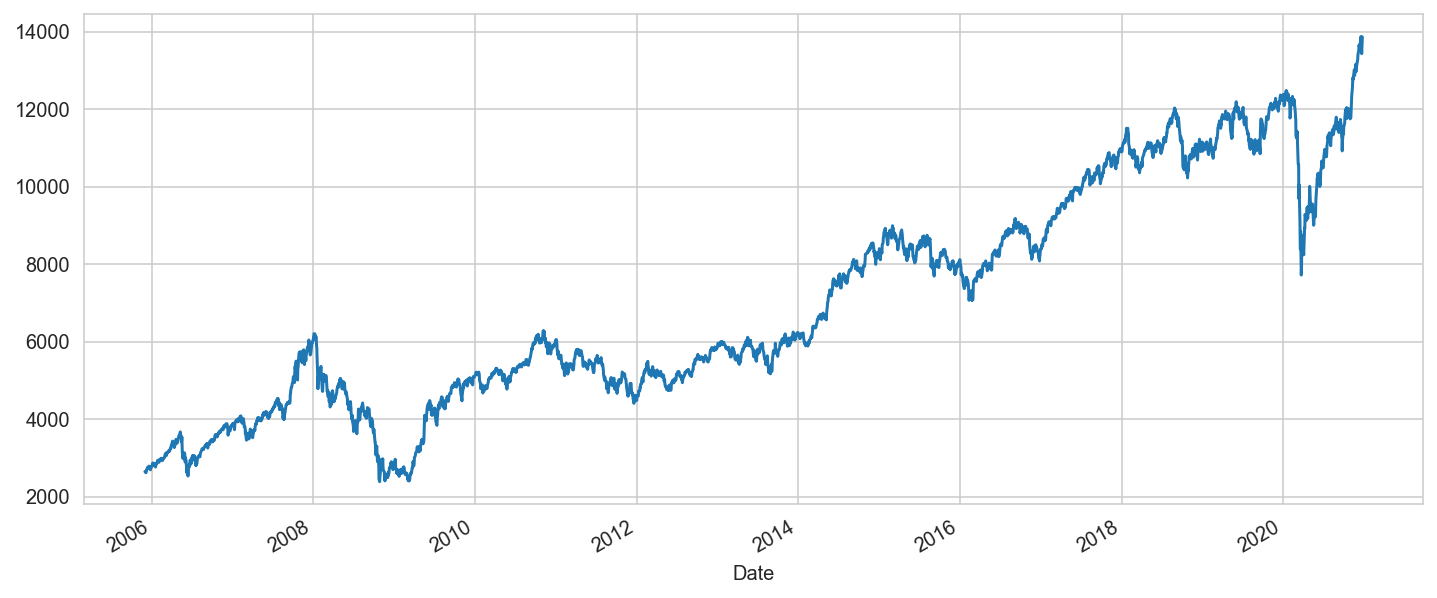

In [27]:
market.close.plot(figsize=(12,5));

In [28]:
market_ret = market.close.pct_change().dropna()
market_ret.index = market_ret.index.tz_localize('UTC')
market_ret.head()

Date
2005-12-02 00:00:00+00:00    0.000962
2005-12-05 00:00:00+00:00   -0.012291
2005-12-06 00:00:00+00:00   -0.000420
2005-12-07 00:00:00+00:00    0.010597
2005-12-08 00:00:00+00:00    0.005045
Name: close, dtype: float64

In [29]:
returns.index.name = 'Date'
returns.head()

Date
2010-01-04 00:00:00+00:00    0.0
2010-01-05 00:00:00+00:00    0.0
2010-01-06 00:00:00+00:00    0.0
2010-01-07 00:00:00+00:00    0.0
2010-01-08 00:00:00+00:00    0.0
Name: return, dtype: float64

In [30]:
ret_df= pd.DataFrame([returns, market_ret], index=None).T.dropna()
ret_df.columns = ['stra_eqw', 'market']
ret_df.head()

,stra_eqw,market
Date,,
2010-01-04 00:00:00+00:00,0.0,0.006936
2010-01-05 00:00:00+00:00,0.0,0.009751
2010-01-06 00:00:00+00:00,0.0,0.001960
2010-01-07 00:00:00+00:00,0.0,-0.004277
2010-01-08 00:00:00+00:00,0.0,-0.003072


In [31]:
pf.show_perf_stats(ret_df.stra_eqw)

Start date,2010-01-04
End date,2020-12-24
Total months,129
,Backtest
Annual return,20.167%
Cumulative returns,628.003%
Annual volatility,18.064%
Sharpe ratio,1.11
Calmar ratio,0.63
Stability,0.94
Max drawdown,-32.018%


In [32]:
pf.show_perf_stats(ret_df.market)

Start date,2010-01-04
End date,2020-12-24
Total months,129
,Backtest
Annual return,9.66%
Cumulative returns,170.847%
Annual volatility,17.227%
Sharpe ratio,0.62
Calmar ratio,0.25
Stability,0.90
Max drawdown,-38.104%


In [33]:
DATA_STORE = 'data/mom_results.h5'

In [34]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('nse200/eq_wts/biweekly_20/returns', returns)
    store.put('nse200/eq_wts/biweekly_20/positions', positions)
    store.put('nse200/eq_wts/biweekly_20/transactions', transactions)

### Momentum with Risk Parity

In [35]:
vola_window = 21

In [36]:
# we take a 126-day time series of closing prices, 
# calculate the daily returns, and take a mean of 21 days rolling window of standards deviation.
def volatility(ts):
    std = ts.pct_change().dropna().rolling(vola_window).std().iloc[-1]
    return std

In [37]:
class StrategyRiskparity(bt.Strategy):
    params = dict(
        # parametrize the Momentum and its period
        momentum=Momentum,
        momentum_period=126,
        num_positions=30,
        rebalance_days = [1,4],

        printlog=True,
        reserve=0.00  # 5% reserve capital
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function '''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            if isinstance(dt, float):
                dt = bt.num2date(dt)
            print("%s, %s" % (dt.isoformat(), txt))

    def __init__(self):
        self.securities = self.datas
        self.inds = collections.defaultdict(dict)
        for d in self.securities:
            self.inds[d]['mom'] = self.p.momentum(d, period=self.p.momentum_period)

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def rebalance(self):
        rankings = list(self.securities)
        rankings.sort(key=lambda s: self.inds[s]['mom'][0], reverse=True)

        # Sell stocks no longer meeting ranking filter and create list of kept positions
        kept_positions = []
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i > self.p.num_positions:
                    self.close(d)
                    self.log('Leave {} - Rank {:.2f}'.format(d._name, i))
                elif i < self.p.num_positions:
                    kept_positions.append(d._name)
        self.log('kept_positions - %s'% kept_positions)
        
        # Based on kept position and new ranking identify new long positions to add
        new_positions = []
        for i, d in enumerate(rankings[:self.p.num_positions]):
            if d._name not in (kept_positions):
                new_positions.append(d._name)
        self.log('new_positions - %s'% new_positions)
        
        # Calculate volatility table
        hist = pd.DataFrame()
        for d in self.securities:
            if d._name in (new_positions):
                hist[d._name] = d.close.get(size=self.p.momentum_period)
        vola_table = hist.apply(volatility)
        self.log('vola_table - %s'% vola_table)
        
        # Calculate weights based on volatility 
        inv_vola_table = 1 / vola_table 
        sum_inv_vola = np.sum(inv_vola_table)         
        vola_target_weights = inv_vola_table / sum_inv_vola
        self.log('vola_target_weights - %s'% vola_target_weights)
        
        # Buy and rebalance stocks with remaining cash
        for i, d in enumerate(rankings[:self.p.num_positions]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            if not self.getposition(d).size:
                weight = vola_target_weights[d._name]
                self.order_target_percent(d, target=weight)
                self.log('Buy {} - Rank {:.2f}'.format(d._name, i)) 

    def next_open(self):
        dt = self.data.datetime.datetime()
        if dt.weekday() in self.p.rebalance_days:
            self.rebalance()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,order.executed.value,order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value, order.executed.comm))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
    
    def stop(self):
        self.log('| %2d | %2d |  %.2f |' %
                 (self.p.momentum_period, self.p.num_positions, self.broker.getvalue()),doprint=True)  

In [38]:
# Model Settings
startcash = 500000
momentum_period = 126 #days
num_positions = 20
reserve = 0.05
printlog=True,

# Commission and Slippage Settings
commission = 0.0025

In [39]:
cerebro = bt.Cerebro(stdstats=False, cheat_on_open=True)
cerebro.broker.set_coc(True)
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission=commission)

In [40]:
# Add securities as datas1:
for ticker, data in prices.groupby(level=0):
    if ticker in tickers:
        print(f"Adding ticker: {ticker}")
        data = bt.feeds.PandasData(dataname=data.droplevel(level=0),
                                   name=str(ticker),
                                   fromdate=fromdate,
                                   todate=todate,
                                   plot=False)
        cerebro.adddata(data)

Adding ticker: ABOT
Adding ticker: ABUJ
Adding ticker: ACC
Adding ticker: ADEL
Adding ticker: AMAR
Adding ticker: APLH
Adding ticker: APLO
Adding ticker: APSE
Adding ticker: ARBN
Adding ticker: ARTI
Adding ticker: ASOK
Adding ticker: ASPN
Adding ticker: AXBK
Adding ticker: BAJA
Adding ticker: BAJE
Adding ticker: BATA
Adding ticker: BBRM
Adding ticker: BFRG
Adding ticker: BHEL
Adding ticker: BION
Adding ticker: BJAT
Adding ticker: BJFN
Adding ticker: BJFS
Adding ticker: BLKI
Adding ticker: BOB
Adding ticker: BOI
Adding ticker: BOSH
Adding ticker: BPCL
Adding ticker: BRGR
Adding ticker: BRIT
Adding ticker: BRTI
Adding ticker: CADI
Adding ticker: CAST
Adding ticker: CCRI
Adding ticker: CESC
Adding ticker: CHLA
Adding ticker: CNBK
Adding ticker: COLG
Adding ticker: CORF
Adding ticker: CTBK
Adding ticker: CUMM
Adding ticker: DABU
Adding ticker: DIVI
Adding ticker: DLF
Adding ticker: EDEL
Adding ticker: EMAM
Adding ticker: ESCO
Adding ticker: EXID
Adding ticker: FED
Adding ticker: FOHE
Addin

In [41]:
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

cerebro.addstrategy(StrategyRiskparity,
                    momentum_period = momentum_period,
                    num_positions = num_positions,
                    printlog = printlog,
                    reserve = reserve,
                   )

0

In [42]:
%%time
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run the strategy. Results will be output from stop.
results_riskparity = cerebro.run()

# # Run over everything
# cerebro.run(maxcpus=1)

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 500000.00
2010-08-13T00:00:00, kept_positions - []
2010-08-13T00:00:00, new_positions - ['HVEL', 'GODR', 'PIIL', 'DIVI', 'COLG', 'WHIR', 'CHLA', 'BJFN', 'CORF', 'TVSM', 'PFIZ', 'TITN', 'NATP', 'MMFS', 'EMAM', 'MINT', 'BAJA', 'BRGR', 'LICH', 'UBBW']
2010-08-13T00:00:00, vola_table - BAJA    0.018645
BJFN    0.016933
BRGR    0.023840
CHLA    0.020243
COLG    0.006511
CORF    0.016620
DIVI    0.009989
EMAM    0.021384
GODR    0.024702
HVEL    0.023476
LICH    0.016644
MINT    0.013910
MMFS    0.021285
NATP    0.018710
PFIZ    0.013522
PIIL    0.034642
TITN    0.014843
TVSM    0.023284
UBBW    0.055368
WHIR    0.022877
dtype: float64
2010-08-13T00:00:00, vola_target_weights - BAJA    0.046434
BJFN    0.051130
BRGR    0.036315
CHLA    0.042768
COLG    0.132961
CORF    0.052091
DIVI    0.086672
EMAM    0.040487
GODR    0.035048
HVEL    0.036879
LICH    0.052017
MINT    0.062239
MMFS    0.040675
NATP    0.046274
PFIZ    0.064026
PIIL    0.024992
TITN    0.058327
TVSM

2010-09-28T00:00:00, Leave EMAM - Rank 21.00
2010-09-28T00:00:00, kept_positions - ['HVEL', 'GODR', 'UBBW', 'PIIL', 'BJFN', 'CORF', 'TVSM', 'HPCL', 'VGUA', 'BRGR', 'MMFS', 'WHIR', 'NATP', 'TITN', 'CHLA']
2010-09-28T00:00:00, new_positions - ['PAGE', 'BBRM', 'BPCL', 'CTBK', 'MNFL']
2010-09-28T00:00:00, vola_table - BBRM    0.025936
BPCL    0.015314
CTBK    0.017072
MNFL    0.022203
PAGE    0.012490
dtype: float64
2010-09-28T00:00:00, vola_target_weights - BBRM    0.134095
BPCL    0.227107
CTBK    0.203715
MNFL    0.156639
PAGE    0.278444
dtype: float64
2010-09-28T00:00:00, Buy PAGE - Rank 14.00
2010-09-28T00:00:00, Buy BBRM - Rank 16.00
2010-09-28T00:00:00, Buy BPCL - Rank 17.00
2010-09-28T00:00:00, Buy CTBK - Rank 18.00
2010-09-28T00:00:00, Buy MNFL - Rank 19.00
2010-09-28T00:00:00, Order Canceled/Margin/Rejected
2010-09-28T00:00:00, Order Canceled/Margin/Rejected
2010-09-28T00:00:00, Order Canceled/Margin/Rejected
2010-09-28T00:00:00, Order Canceled/Margin/Rejected
2010-09-28T00:00:0

2010-11-09T00:00:00, kept_positions - ['UBBW', 'MNFL', 'VGUA', 'JUBI', 'BJFN', 'NATP', 'MMFS', 'BOI', 'BBRM', 'CORF', 'TITN', 'BRGR', 'TVSM']
2010-11-09T00:00:00, new_positions - ['CNBK', 'TAMO', 'INED', 'SBI', 'GODI', 'SRTR', 'INBK']
2010-11-09T00:00:00, vola_table - CNBK    0.026368
GODI    0.020781
INBK    0.025047
INED    0.028336
SBI     0.021590
SRTR    0.022019
TAMO    0.017453
dtype: float64
2010-11-09T00:00:00, vola_target_weights - CNBK    0.122226
GODI    0.155081
INBK    0.128669
INED    0.113733
SBI     0.149272
SRTR    0.146363
TAMO    0.184655
dtype: float64
2010-11-09T00:00:00, Buy CNBK - Rank 8.00
2010-11-09T00:00:00, Buy TAMO - Rank 9.00
2010-11-09T00:00:00, Buy INED - Rank 14.00
2010-11-09T00:00:00, Buy SBI - Rank 16.00
2010-11-09T00:00:00, Buy GODI - Rank 17.00
2010-11-09T00:00:00, Buy SRTR - Rank 18.00
2010-11-09T00:00:00, Buy INBK - Rank 19.00
2010-11-09T00:00:00, Order Canceled/Margin/Rejected
2010-11-09T00:00:00, Order Canceled/Margin/Rejected
2010-11-09T00:00:0

2010-11-30T00:00:00, vola_table - ARBN    0.020410
ARTI    0.039019
HALC    0.027096
ICBK    0.022647
INBK    0.033354
INED    0.016462
PLNG    0.029694
REXP    0.046006
SRTR    0.027762
dtype: float64
2010-11-30T00:00:00, vola_target_weights - ARBN    0.145026
ARTI    0.075859
HALC    0.109240
ICBK    0.130697
INBK    0.088744
INED    0.179799
PLNG    0.099680
REXP    0.064338
SRTR    0.106617
dtype: float64
2010-11-30T00:00:00, Buy INED - Rank 10.00
2010-11-30T00:00:00, Buy HALC - Rank 11.00
2010-11-30T00:00:00, Buy INBK - Rank 12.00
2010-11-30T00:00:00, Buy PLNG - Rank 13.00
2010-11-30T00:00:00, Buy ARTI - Rank 14.00
2010-11-30T00:00:00, Buy ARBN - Rank 15.00
2010-11-30T00:00:00, Buy ICBK - Rank 17.00
2010-11-30T00:00:00, Buy REXP - Rank 18.00
2010-11-30T00:00:00, Buy SRTR - Rank 19.00
2010-11-30T00:00:00, Order Canceled/Margin/Rejected
2010-11-30T00:00:00, Order Canceled/Margin/Rejected
2010-11-30T00:00:00, Order Canceled/Margin/Rejected
2010-11-30T00:00:00, Order Canceled/Margin/R

dtype: float64
2010-12-24T00:00:00, vola_target_weights - ARBN    0.101781
GLEN    0.078505
HALC    0.087393
INBK    0.081155
PAGE    0.107893
PLNG    0.080506
REXP    0.064962
SUN     0.106055
TCS     0.165607
ULTC    0.126141
dtype: float64
2010-12-24T00:00:00, Buy HALC - Rank 6.00
2010-12-24T00:00:00, Buy TCS - Rank 8.00
2010-12-24T00:00:00, Buy ARBN - Rank 10.00
2010-12-24T00:00:00, Buy REXP - Rank 11.00
2010-12-24T00:00:00, Buy PLNG - Rank 12.00
2010-12-24T00:00:00, Buy SUN - Rank 14.00
2010-12-24T00:00:00, Buy PAGE - Rank 15.00
2010-12-24T00:00:00, Buy GLEN - Rank 16.00
2010-12-24T00:00:00, Buy INBK - Rank 18.00
2010-12-24T00:00:00, Buy ULTC - Rank 19.00
2010-12-24T00:00:00, Order Canceled/Margin/Rejected
2010-12-24T00:00:00, Order Canceled/Margin/Rejected
2010-12-24T00:00:00, Order Canceled/Margin/Rejected
2010-12-24T00:00:00, Order Canceled/Margin/Rejected
2010-12-24T00:00:00, Order Canceled/Margin/Rejected
2010-12-24T00:00:00, Order Canceled/Margin/Rejected
2010-12-24T00:00:00

2011-01-11T00:00:00, kept_positions - ['TAMO', 'HALC', 'NATP', 'JUBI', 'TCS', 'SUN', 'CNBK', 'MMFS', 'UBBW', 'MNFL', 'TITN']
2011-01-11T00:00:00, new_positions - ['ARBN', 'REXP', 'GLEN', 'NEST', 'REDY', 'LUPN', 'PAGE', 'CADI', 'MAHM']
2011-01-11T00:00:00, vola_table - ARBN    0.018875
CADI    0.012176
GLEN    0.026176
LUPN    0.015515
MAHM    0.014496
NEST    0.016599
PAGE    0.012131
REDY    0.014327
REXP    0.029303
dtype: float64
2011-01-11T00:00:00, vola_target_weights - ARBN    0.095744
CADI    0.148417
GLEN    0.069039
LUPN    0.116475
MAHM    0.124668
NEST    0.108875
PAGE    0.148971
REDY    0.126138
REXP    0.061673
dtype: float64
2011-01-11T00:00:00, Buy ARBN - Rank 6.00
2011-01-11T00:00:00, Buy REXP - Rank 7.00
2011-01-11T00:00:00, Buy GLEN - Rank 8.00
2011-01-11T00:00:00, Buy NEST - Rank 9.00
2011-01-11T00:00:00, Buy REDY - Rank 12.00
2011-01-11T00:00:00, Buy LUPN - Rank 13.00
2011-01-11T00:00:00, Buy PAGE - Rank 14.00
2011-01-11T00:00:00, Buy CADI - Rank 17.00
2011-01-11T0

2011-02-11T00:00:00, Order Canceled/Margin/Rejected
2011-02-11T00:00:00, Order Canceled/Margin/Rejected
2011-02-11T00:00:00, Order Canceled/Margin/Rejected
2011-02-11T00:00:00, Order Canceled/Margin/Rejected
2011-02-11T00:00:00, Order Canceled/Margin/Rejected
2011-02-11T00:00:00, SELL EXECUTED, Price: 285.60, Cost: 19448.10, Comm 44.98
2011-02-11T00:00:00, BUY EXECUTED, Price: 1517.40, Cost: 18208.80, Comm 45.52
2011-02-11T00:00:00, BUY EXECUTED, Price: 60.00, Cost: 31080.00, Comm 77.70
2011-02-15T00:00:00, Leave JUBI - Rank 42.00
2011-02-15T00:00:00, kept_positions - ['TCS', 'REXP', 'CADI', 'HALC', 'PAGE', 'SUN', 'PLNG', 'ARBN', 'TAMO', 'NEST']
2011-02-15T00:00:00, new_positions - ['HZNC', 'HCLT', 'INFY', 'LUPN', 'REDY', 'GRAS', 'PGRD', 'OILI', 'CAST', 'CCRI']
2011-02-15T00:00:00, vola_table - CAST    0.016133
CCRI    0.013967
GRAS    0.015179
HCLT    0.018900
HZNC    0.020149
INFY    0.015061
LUPN    0.029086
OILI    0.013565
PGRD    0.012740
REDY    0.016631
dtype: float64
2011-02-1

2011-03-18T00:00:00, kept_positions - ['PAGE', 'TCS', 'REXP', 'CADI', 'PFIZ', 'PIIL', 'HCLT', 'OILI', 'HZNC', 'CAST']
2011-03-18T00:00:00, new_positions - ['BRIT', 'CCRI', 'BHEL', 'ONGC', 'HDBK', 'MAXI', 'PNBK', 'VGUA', 'MRTI', 'APSE']
2011-03-18T00:00:00, vola_table - APSE    0.023175
BHEL    0.020332
BRIT    0.013083
CCRI    0.020240
HDBK    0.019486
MAXI    0.017530
MRTI    0.025062
ONGC    0.019569
PNBK    0.013138
VGUA    0.022017
dtype: float64
2011-03-18T00:00:00, vola_target_weights - APSE    0.080045
BHEL    0.091238
BRIT    0.141786
CCRI    0.091653
HDBK    0.095196
MAXI    0.105818
MRTI    0.074016
ONGC    0.094792
PNBK    0.141200
VGUA    0.084255
dtype: float64
2011-03-18T00:00:00, Buy BRIT - Rank 9.00
2011-03-18T00:00:00, Buy CCRI - Rank 11.00
2011-03-18T00:00:00, Buy BHEL - Rank 12.00
2011-03-18T00:00:00, Buy ONGC - Rank 13.00
2011-03-18T00:00:00, Buy HDBK - Rank 14.00
2011-03-18T00:00:00, Buy MAXI - Rank 15.00
2011-03-18T00:00:00, Buy PNBK - Rank 16.00
2011-03-18T00:00:

2011-04-05T00:00:00, kept_positions - ['PIIL', 'PAGE', 'PFIZ', 'HCLT', 'TCS', 'OILI', 'BRIT', 'CAST', 'CADI']
2011-04-05T00:00:00, new_positions - ['BHEL', 'ONGC', 'MRTI', 'NITT', 'CCRI', 'VGUA', 'APSE', 'BPCL', 'PNBK', 'HZNC', 'GSPT']
2011-04-05T00:00:00, vola_table - APSE    0.021596
BHEL    0.018693
BPCL    0.017656
CCRI    0.018134
GSPT    0.013742
HZNC    0.021142
MRTI    0.020384
NITT    0.016834
ONGC    0.014602
PNBK    0.013752
VGUA    0.020467
dtype: float64
2011-04-05T00:00:00, vola_target_weights - APSE    0.073478
BHEL    0.084891
BPCL    0.089877
CCRI    0.087507
GSPT    0.115475
HZNC    0.075056
MRTI    0.077850
NITT    0.094264
ONGC    0.108678
PNBK    0.115389
VGUA    0.077535
dtype: float64
2011-04-05T00:00:00, Buy BHEL - Rank 7.00
2011-04-05T00:00:00, Buy ONGC - Rank 8.00
2011-04-05T00:00:00, Buy MRTI - Rank 10.00
2011-04-05T00:00:00, Buy NITT - Rank 11.00
2011-04-05T00:00:00, Buy CCRI - Rank 12.00
2011-04-05T00:00:00, Buy VGUA - Rank 14.00
2011-04-05T00:00:00, Buy AP

2011-05-10T00:00:00, Order Canceled/Margin/Rejected
2011-05-10T00:00:00, Order Canceled/Margin/Rejected
2011-05-10T00:00:00, Order Canceled/Margin/Rejected
2011-05-10T00:00:00, Order Canceled/Margin/Rejected
2011-05-10T00:00:00, Order Canceled/Margin/Rejected
2011-05-10T00:00:00, Order Canceled/Margin/Rejected
2011-05-10T00:00:00, Order Canceled/Margin/Rejected
2011-05-10T00:00:00, Order Canceled/Margin/Rejected
2011-05-10T00:00:00, Order Canceled/Margin/Rejected
2011-05-13T00:00:00, Leave BRIT - Rank 21.00
2011-05-13T00:00:00, Leave NITT - Rank 27.00
2011-05-13T00:00:00, kept_positions - ['PIIL', 'PFIZ', 'MOSS', 'HCLT', 'PAGE', 'HZNC', 'SIEM', 'CADI', 'BHEL']
2011-05-13T00:00:00, new_positions - ['BATA', 'CESC', 'BJFS', 'PGRD', 'IHTL', 'GLEN', 'SUTV', 'LUPN', 'GSPT', 'GMRI', 'CUMM']
2011-05-13T00:00:00, vola_table - BATA    0.022401
BJFS    0.016856
CESC    0.016198
CUMM    0.013739
GLEN    0.021429
GMRI    0.019944
GSPT    0.020794
IHTL    0.017269
LUPN    0.017063
PGRD    0.011944
S

2011-06-14T00:00:00, vola_table - ABOT    0.015411
BLKI    0.014943
FOHE    0.011133
GODR    0.014826
INED    0.016506
ITC     0.012297
JUBI    0.026932
PROC    0.012820
TREN    0.016086
dtype: float64
2011-06-14T00:00:00, vola_target_weights - ABOT    0.106677
BLKI    0.110012
FOHE    0.147672
GODR    0.110884
INED    0.099595
ITC     0.133685
JUBI    0.061042
PROC    0.128237
TREN    0.102197
dtype: float64
2011-06-14T00:00:00, Buy JUBI - Rank 8.00
2011-06-14T00:00:00, Buy GODR - Rank 11.00
2011-06-14T00:00:00, Buy TREN - Rank 13.00
2011-06-14T00:00:00, Buy FOHE - Rank 14.00
2011-06-14T00:00:00, Buy BLKI - Rank 15.00
2011-06-14T00:00:00, Buy ITC - Rank 16.00
2011-06-14T00:00:00, Buy ABOT - Rank 17.00
2011-06-14T00:00:00, Buy PROC - Rank 18.00
2011-06-14T00:00:00, Buy INED - Rank 19.00
2011-06-14T00:00:00, Order Canceled/Margin/Rejected
2011-06-14T00:00:00, Order Canceled/Margin/Rejected
2011-06-14T00:00:00, Order Canceled/Margin/Rejected
2011-06-14T00:00:00, Order Canceled/Margin/Rej

2011-07-05T00:00:00, vola_table - AMAR    0.015112
APLO    0.020690
CORF    0.019788
FED     0.015350
GODR    0.017429
INED    0.015375
TREN    0.022157
VGUA    0.015174
dtype: float64
2011-07-05T00:00:00, vola_target_weights - AMAR    0.142726
APLO    0.104247
CORF    0.108996
FED     0.140514
GODR    0.123752
INED    0.140279
TREN    0.097342
VGUA    0.142145
dtype: float64
2011-07-05T00:00:00, Buy VGUA - Rank 8.00
2011-07-05T00:00:00, Buy TREN - Rank 9.00
2011-07-05T00:00:00, Buy INED - Rank 10.00
2011-07-05T00:00:00, Buy FED - Rank 12.00
2011-07-05T00:00:00, Buy CORF - Rank 13.00
2011-07-05T00:00:00, Buy AMAR - Rank 14.00
2011-07-05T00:00:00, Buy APLO - Rank 15.00
2011-07-05T00:00:00, Buy GODR - Rank 18.00
2011-07-05T00:00:00, Order Canceled/Margin/Rejected
2011-07-05T00:00:00, Order Canceled/Margin/Rejected
2011-07-05T00:00:00, Order Canceled/Margin/Rejected
2011-07-05T00:00:00, Order Canceled/Margin/Rejected
2011-07-05T00:00:00, Order Canceled/Margin/Rejected
2011-07-05T00:00:00,

2011-08-05T00:00:00, vola_table - ASPN    0.010639
BRGR    0.017222
BRIT    0.011079
EMAM    0.014649
GODI    0.025412
IGAS    0.017408
PAGE    0.030204
PIDI    0.017630
PLNG    0.027775
VODA    0.031191
dtype: float64
2011-08-05T00:00:00, vola_target_weights - ASPN    0.166273
BRGR    0.102723
BRIT    0.159681
EMAM    0.120761
GODI    0.069614
IGAS    0.101623
PAGE    0.058570
PIDI    0.100345
PLNG    0.063694
VODA    0.056716
dtype: float64
2011-08-05T00:00:00, Buy BRIT - Rank 7.00
2011-08-05T00:00:00, Buy IGAS - Rank 9.00
2011-08-05T00:00:00, Buy EMAM - Rank 10.00
2011-08-05T00:00:00, Buy PAGE - Rank 12.00
2011-08-05T00:00:00, Buy VODA - Rank 13.00
2011-08-05T00:00:00, Buy ASPN - Rank 15.00
2011-08-05T00:00:00, Buy PLNG - Rank 16.00
2011-08-05T00:00:00, Buy PIDI - Rank 17.00
2011-08-05T00:00:00, Buy BRGR - Rank 18.00
2011-08-05T00:00:00, Buy GODI - Rank 19.00
2011-08-05T00:00:00, Order Canceled/Margin/Rejected
2011-08-05T00:00:00, Order Canceled/Margin/Rejected
2011-08-05T00:00:00, 

2011-09-13T00:00:00, vola_table - ASPN    0.012811
BRIT    0.014664
EMAM    0.020520
HLL     0.012620
HROM    0.019670
MAXI    0.028460
MRCO    0.021813
NAFL    0.021533
NEST    0.012305
PLNG    0.023824
dtype: float64
2011-09-13T00:00:00, vola_target_weights - ASPN    0.135580
BRIT    0.118451
EMAM    0.084646
HLL     0.137635
HROM    0.088303
MAXI    0.061029
MRCO    0.079628
NAFL    0.080663
NEST    0.141159
PLNG    0.072906
dtype: float64
2011-09-13T00:00:00, Buy PLNG - Rank 6.00
2011-09-13T00:00:00, Buy BRIT - Rank 8.00
2011-09-13T00:00:00, Buy NAFL - Rank 9.00
2011-09-13T00:00:00, Buy ASPN - Rank 11.00
2011-09-13T00:00:00, Buy MAXI - Rank 13.00
2011-09-13T00:00:00, Buy EMAM - Rank 14.00
2011-09-13T00:00:00, Buy HROM - Rank 15.00
2011-09-13T00:00:00, Buy MRCO - Rank 17.00
2011-09-13T00:00:00, Buy HLL - Rank 18.00
2011-09-13T00:00:00, Buy NEST - Rank 19.00
2011-09-13T00:00:00, Order Canceled/Margin/Rejected
2011-09-13T00:00:00, Order Canceled/Margin/Rejected
2011-09-13T00:00:00, Or

2011-10-18T00:00:00, kept_positions - ['PIIL', 'PAGE', 'BATA', 'VODA', 'IGAS', 'REXP', 'NAFL', 'BLKI', 'PLNG', 'MAXI', 'BRIT']
2011-10-18T00:00:00, new_positions - ['SANO', 'GGAS', 'BAJA', 'HROM', 'HLL', 'APLH', 'LUPN', 'COLG', 'ASPN']
2011-10-18T00:00:00, vola_table - APLH    0.012006
ASPN    0.011033
BAJA    0.019638
COLG    0.012416
GGAS    0.012044
HLL     0.016186
HROM    0.015576
LUPN    0.015138
SANO    0.015567
dtype: float64
2011-10-18T00:00:00, vola_target_weights - APLH    0.129195
ASPN    0.140583
BAJA    0.078983
COLG    0.124932
GGAS    0.128789
HLL     0.095832
HROM    0.099582
LUPN    0.102461
SANO    0.099643
dtype: float64
2011-10-18T00:00:00, Buy SANO - Rank 9.00
2011-10-18T00:00:00, Buy GGAS - Rank 10.00
2011-10-18T00:00:00, Buy BAJA - Rank 12.00
2011-10-18T00:00:00, Buy HROM - Rank 13.00
2011-10-18T00:00:00, Buy HLL - Rank 15.00
2011-10-18T00:00:00, Buy APLH - Rank 16.00
2011-10-18T00:00:00, Buy LUPN - Rank 17.00
2011-10-18T00:00:00, Buy COLG - Rank 18.00
2011-10-1

2011-11-22T00:00:00, kept_positions - ['PIIL', 'REXP', 'PAGE', 'NAFL', 'VODA', 'BAJA', 'SANO', 'BATA', 'BLKI', 'IGAS', 'PLNG']
2011-11-22T00:00:00, new_positions - ['MAHM', 'TVSM', 'ACC', 'HROM', 'TRCE', 'ULTC', 'ABUJ', 'HLL', 'COLG']
2011-11-22T00:00:00, vola_table - ABUJ    0.018185
ACC     0.016778
COLG    0.014056
HLL     0.021441
HROM    0.017089
MAHM    0.026556
TRCE    0.024115
TVSM    0.015420
ULTC    0.011624
dtype: float64
2011-11-22T00:00:00, vola_target_weights - ABUJ    0.105570
ACC     0.114424
COLG    0.136583
HLL     0.089538
HROM    0.112336
MAHM    0.072290
TRCE    0.079609
TVSM    0.124500
ULTC    0.165150
dtype: float64
2011-11-22T00:00:00, Buy MAHM - Rank 8.00
2011-11-22T00:00:00, Buy TVSM - Rank 9.00
2011-11-22T00:00:00, Buy ACC - Rank 11.00
2011-11-22T00:00:00, Buy HROM - Rank 12.00
2011-11-22T00:00:00, Buy TRCE - Rank 13.00
2011-11-22T00:00:00, Buy ULTC - Rank 14.00
2011-11-22T00:00:00, Buy ABUJ - Rank 16.00
2011-11-22T00:00:00, Buy HLL - Rank 18.00
2011-11-22T0

2011-12-27T00:00:00, Leave PIIL - Rank 23.00
2011-12-27T00:00:00, kept_positions - ['TRCE', 'REXP', 'ACC', 'ABUJ', 'ULTC', 'BAJA', 'HLL', 'SHCM', 'SANO', 'PAGE']
2011-12-27T00:00:00, new_positions - ['GRAS', 'APLH', 'DABU', 'GAIL', 'INED', 'IOC', 'CADI', 'BAJE', 'PFIZ', 'GOCP']
2011-12-27T00:00:00, vola_table - APLH    0.055350
BAJE    0.014067
CADI    0.016248
DABU    0.011898
GAIL    0.013956
GOCP    0.013194
GRAS    0.017429
INED    0.015793
IOC     0.016976
PFIZ    0.020305
dtype: float64
2011-12-27T00:00:00, vola_target_weights - APLH    0.029567
BAJE    0.116335
CADI    0.100722
DABU    0.137551
GAIL    0.117265
GOCP    0.124039
GRAS    0.093896
INED    0.103626
IOC     0.096400
PFIZ    0.080599
dtype: float64
2011-12-27T00:00:00, Buy GRAS - Rank 8.00
2011-12-27T00:00:00, Buy APLH - Rank 11.00
2011-12-27T00:00:00, Buy DABU - Rank 12.00
2011-12-27T00:00:00, Buy GAIL - Rank 13.00
2011-12-27T00:00:00, Buy INED - Rank 14.00
2011-12-27T00:00:00, Buy IOC - Rank 15.00
2011-12-27T00:00:0

2012-01-31T00:00:00, Leave SANO - Rank 26.00
2012-01-31T00:00:00, kept_positions - ['SHCM', 'HLL', 'HVEL', 'TRCE', 'ABUJ', 'GRAS', 'ULTC', 'REXP', 'ACC', 'LICH', 'APLH']
2012-01-31T00:00:00, new_positions - ['WIPR', 'TAMO', 'TCS', 'REDY', 'BJAT', 'GAIL', 'MINT', 'CADI', 'BAJE']
2012-01-31T00:00:00, vola_table - BAJE    0.016258
BJAT    0.022638
CADI    0.011914
GAIL    0.013513
MINT    0.021020
REDY    0.013057
TAMO    0.020780
TCS     0.015460
WIPR    0.017841
dtype: float64
2012-01-31T00:00:00, vola_target_weights - BAJE    0.110501
BJAT    0.079357
CADI    0.150785
GAIL    0.132946
MINT    0.085468
REDY    0.137589
TAMO    0.086454
TCS     0.116205
WIPR    0.100695
dtype: float64
2012-01-31T00:00:00, Buy WIPR - Rank 7.00
2012-01-31T00:00:00, Buy TAMO - Rank 8.00
2012-01-31T00:00:00, Buy TCS - Rank 12.00
2012-01-31T00:00:00, Buy REDY - Rank 14.00
2012-01-31T00:00:00, Buy BJAT - Rank 15.00
2012-01-31T00:00:00, Buy GAIL - Rank 16.00
2012-01-31T00:00:00, Buy MINT - Rank 17.00
2012-01-31

2012-03-06T00:00:00, vola_target_weights - APLO    0.046236
ARTI    0.112823
MINT    0.097036
MRF     0.059428
PIRA    0.108060
REDY    0.208936
SUN     0.138511
TAGL    0.054526
TCS     0.174443
dtype: float64
2012-03-06T00:00:00, Buy MINT - Rank 3.00
2012-03-06T00:00:00, Buy PIRA - Rank 5.00
2012-03-06T00:00:00, Buy APLO - Rank 7.00
2012-03-06T00:00:00, Buy MRF - Rank 9.00
2012-03-06T00:00:00, Buy SUN - Rank 10.00
2012-03-06T00:00:00, Buy TCS - Rank 11.00
2012-03-06T00:00:00, Buy REDY - Rank 14.00
2012-03-06T00:00:00, Buy TAGL - Rank 15.00
2012-03-06T00:00:00, Buy ARTI - Rank 18.00
2012-03-06T00:00:00, Order Canceled/Margin/Rejected
2012-03-06T00:00:00, Order Canceled/Margin/Rejected
2012-03-06T00:00:00, Order Canceled/Margin/Rejected
2012-03-06T00:00:00, Order Canceled/Margin/Rejected
2012-03-06T00:00:00, Order Canceled/Margin/Rejected
2012-03-06T00:00:00, Order Canceled/Margin/Rejected
2012-03-06T00:00:00, Order Canceled/Margin/Rejected
2012-03-06T00:00:00, Order Canceled/Margin/Re

2012-04-13T00:00:00, vola_table - AMAR    0.013325
ARTI    0.014755
BLKI    0.025281
JUBI    0.029141
MBFL    0.021036
NATP    0.034307
SUN     0.020245
TAGL    0.024716
UBBW    0.028645
dtype: float64
2012-04-13T00:00:00, vola_target_weights - AMAR    0.179474
ARTI    0.162082
BLKI    0.094599
JUBI    0.082067
MBFL    0.113690
NATP    0.069710
SUN     0.118128
TAGL    0.096760
UBBW    0.083490
dtype: float64
2012-04-13T00:00:00, Buy NATP - Rank 4.00
2012-04-13T00:00:00, Buy TAGL - Rank 9.00
2012-04-13T00:00:00, Buy BLKI - Rank 11.00
2012-04-13T00:00:00, Buy AMAR - Rank 13.00
2012-04-13T00:00:00, Buy ARTI - Rank 14.00
2012-04-13T00:00:00, Buy JUBI - Rank 15.00
2012-04-13T00:00:00, Buy MBFL - Rank 17.00
2012-04-13T00:00:00, Buy UBBW - Rank 18.00
2012-04-13T00:00:00, Buy SUN - Rank 19.00
2012-04-13T00:00:00, Order Canceled/Margin/Rejected
2012-04-13T00:00:00, Order Canceled/Margin/Rejected
2012-04-13T00:00:00, Order Canceled/Margin/Rejected
2012-04-13T00:00:00, Order Canceled/Margin/Reje

2012-05-18T00:00:00, Leave TRCE - Rank 21.00
2012-05-18T00:00:00, kept_positions - ['NATP', 'TAMO', 'BJFS', 'BLKI', 'MRF', 'IPCA', 'SHCM', 'HVEL', 'APLO', 'MINT']
2012-05-18T00:00:00, new_positions - ['JUBI', 'ARTI', 'AMAR', 'BATA', 'CHLA', 'GODI', 'GOCP', 'CUMM', 'BJFN', 'BPCL']
2012-05-18T00:00:00, vola_table - AMAR    0.021394
ARTI    0.019943
BATA    0.020688
BJFN    0.022403
BPCL    0.021501
CHLA    0.011702
CUMM    0.020144
GOCP    0.017440
GODI    0.019391
JUBI    0.026322
dtype: float64
2012-05-18T00:00:00, vola_target_weights - AMAR    0.090171
ARTI    0.096733
BATA    0.093248
BJFN    0.086109
BPCL    0.089724
CHLA    0.164857
CUMM    0.095767
GOCP    0.110616
GODI    0.099485
JUBI    0.073290
dtype: float64
2012-05-18T00:00:00, Buy JUBI - Rank 5.00
2012-05-18T00:00:00, Buy ARTI - Rank 6.00
2012-05-18T00:00:00, Buy AMAR - Rank 7.00
2012-05-18T00:00:00, Buy BATA - Rank 9.00
2012-05-18T00:00:00, Buy CHLA - Rank 10.00
2012-05-18T00:00:00, Buy GODI - Rank 14.00
2012-05-18T00:00:0

2012-06-05T00:00:00, vola_table - AMAR    0.020810
ARTI    0.019602
ASPN    0.022459
BOSH    0.010720
BPCL    0.017119
BRGR    0.032689
CHLA    0.007786
EMAM    0.021778
GODI    0.025450
dtype: float64
2012-06-05T00:00:00, vola_target_weights - AMAR    0.089066
ARTI    0.094553
ASPN    0.082527
BOSH    0.172899
BPCL    0.108266
BRGR    0.056699
CHLA    0.238057
EMAM    0.085107
GODI    0.072826
dtype: float64
2012-06-05T00:00:00, Buy BRGR - Rank 9.00
2012-06-05T00:00:00, Buy AMAR - Rank 10.00
2012-06-05T00:00:00, Buy ARTI - Rank 11.00
2012-06-05T00:00:00, Buy ASPN - Rank 12.00
2012-06-05T00:00:00, Buy BPCL - Rank 13.00
2012-06-05T00:00:00, Buy BOSH - Rank 15.00
2012-06-05T00:00:00, Buy EMAM - Rank 16.00
2012-06-05T00:00:00, Buy CHLA - Rank 18.00
2012-06-05T00:00:00, Buy GODI - Rank 19.00
2012-06-05T00:00:00, Order Canceled/Margin/Rejected
2012-06-05T00:00:00, Order Canceled/Margin/Rejected
2012-06-05T00:00:00, Order Canceled/Margin/Rejected
2012-06-05T00:00:00, Order Canceled/Margin/Re

2012-06-26T00:00:00, vola_table - AMAR    0.011948
ASPN    0.021271
BJFN    0.010538
BOSH    0.009349
BPCL    0.014150
EMAM    0.010484
INED    0.013470
MAXI    0.013518
PROC    0.019672
dtype: float64
2012-06-26T00:00:00, vola_target_weights - AMAR    0.119969
ASPN    0.067384
BJFN    0.136018
BOSH    0.153318
BPCL    0.101294
EMAM    0.136720
INED    0.106406
MAXI    0.106029
PROC    0.072862
dtype: float64
2012-06-26T00:00:00, Buy EMAM - Rank 3.00
2012-06-26T00:00:00, Buy ASPN - Rank 5.00
2012-06-26T00:00:00, Buy BPCL - Rank 13.00
2012-06-26T00:00:00, Buy BOSH - Rank 14.00
2012-06-26T00:00:00, Buy AMAR - Rank 15.00
2012-06-26T00:00:00, Buy INED - Rank 16.00
2012-06-26T00:00:00, Buy MAXI - Rank 17.00
2012-06-26T00:00:00, Buy PROC - Rank 18.00
2012-06-26T00:00:00, Buy BJFN - Rank 19.00
2012-06-26T00:00:00, Order Canceled/Margin/Rejected
2012-06-26T00:00:00, Order Canceled/Margin/Rejected
2012-06-26T00:00:00, Order Canceled/Margin/Rejected
2012-06-26T00:00:00, Order Canceled/Margin/Rej

2012-07-17T00:00:00, vola_table - BJFN    0.012555
BOSH    0.013216
BPCL    0.011982
COLG    0.012143
DIVI    0.016105
GLEN    0.015896
HLL     0.009349
ITC     0.016846
PROC    0.012113
dtype: float64
2012-07-17T00:00:00, vola_target_weights - BJFN    0.114598
BOSH    0.108874
BPCL    0.120084
COLG    0.118487
DIVI    0.089340
GLEN    0.090513
HLL     0.153904
ITC     0.085413
PROC    0.118787
dtype: float64
2012-07-17T00:00:00, Buy DIVI - Rank 6.00
2012-07-17T00:00:00, Buy BPCL - Rank 9.00
2012-07-17T00:00:00, Buy GLEN - Rank 11.00
2012-07-17T00:00:00, Buy BOSH - Rank 12.00
2012-07-17T00:00:00, Buy ITC - Rank 13.00
2012-07-17T00:00:00, Buy PROC - Rank 14.00
2012-07-17T00:00:00, Buy HLL - Rank 17.00
2012-07-17T00:00:00, Buy BJFN - Rank 18.00
2012-07-17T00:00:00, Buy COLG - Rank 19.00
2012-07-17T00:00:00, Order Canceled/Margin/Rejected
2012-07-17T00:00:00, Order Canceled/Margin/Rejected
2012-07-17T00:00:00, Order Canceled/Margin/Rejected
2012-07-17T00:00:00, Order Canceled/Margin/Rejec

2012-08-07T00:00:00, vola_table - BJFN    0.017824
BOSH    0.010101
BPCL    0.016477
CADI    0.017728
HLL     0.018110
ITC     0.012796
MRCO    0.014165
PROC    0.010589
SUN     0.010189
VGUA    0.040999
dtype: float64
2012-08-07T00:00:00, vola_target_weights - BJFN    0.080942
BOSH    0.142827
BPCL    0.087560
CADI    0.081381
HLL     0.079662
ITC     0.112746
MRCO    0.101851
PROC    0.136249
SUN     0.141594
VGUA    0.035188
dtype: float64
2012-08-07T00:00:00, Buy VGUA - Rank 3.00
2012-08-07T00:00:00, Buy HLL - Rank 8.00
2012-08-07T00:00:00, Buy ITC - Rank 9.00
2012-08-07T00:00:00, Buy BJFN - Rank 11.00
2012-08-07T00:00:00, Buy BPCL - Rank 14.00
2012-08-07T00:00:00, Buy PROC - Rank 15.00
2012-08-07T00:00:00, Buy BOSH - Rank 16.00
2012-08-07T00:00:00, Buy SUN - Rank 17.00
2012-08-07T00:00:00, Buy MRCO - Rank 18.00
2012-08-07T00:00:00, Buy CADI - Rank 19.00
2012-08-07T00:00:00, Order Canceled/Margin/Rejected
2012-08-07T00:00:00, Order Canceled/Margin/Rejected
2012-08-07T00:00:00, Orde

2012-09-07T00:00:00, Order Canceled/Margin/Rejected
2012-09-07T00:00:00, Order Canceled/Margin/Rejected
2012-09-07T00:00:00, Order Canceled/Margin/Rejected
2012-09-07T00:00:00, Order Canceled/Margin/Rejected
2012-09-07T00:00:00, Order Canceled/Margin/Rejected
2012-09-07T00:00:00, Order Canceled/Margin/Rejected
2012-09-07T00:00:00, Order Canceled/Margin/Rejected
2012-09-07T00:00:00, Order Canceled/Margin/Rejected
2012-09-07T00:00:00, SELL EXECUTED, Price: 445.75, Cost: 52955.00, Comm 132.61
2012-09-07T00:00:00, BUY EXECUTED, Price: 170.70, Cost: 39943.80, Comm 99.86
2012-09-07T00:00:00, BUY EXECUTED, Price: 538.95, Cost: 49583.40, Comm 123.96
2012-09-11T00:00:00, kept_positions - ['VGUA', 'DIVI', 'GLEN', 'GOCP', 'ZEE', 'MINT', 'UNSP', 'BJFN', 'HLL', 'EMAM', 'BRGR', 'ARTI']
2012-09-11T00:00:00, new_positions - ['IPCA', 'CADI', 'ITC', 'SUN', 'DABU', 'MRCO', 'HDBK', 'TREN']
2012-09-11T00:00:00, vola_table - CADI    0.012360
DABU    0.015650
HDBK    0.006081
IPCA    0.019159
ITC     0.01202

2012-10-16T00:00:00, vola_table - AMAR    0.022875
CESC    0.029056
CHLA    0.019985
GRAS    0.013932
MNFL    0.020215
SHCM    0.019962
TEML    0.019774
TRCE    0.015181
ULTC    0.013910
dtype: float64
2012-10-16T00:00:00, vola_target_weights - AMAR    0.089611
CESC    0.070549
CHLA    0.102568
GRAS    0.147130
MNFL    0.101403
SHCM    0.102690
TEML    0.103664
TRCE    0.135025
ULTC    0.147361
dtype: float64
2012-10-16T00:00:00, Buy MNFL - Rank 3.00
2012-10-16T00:00:00, Buy ULTC - Rank 6.00
2012-10-16T00:00:00, Buy TEML - Rank 7.00
2012-10-16T00:00:00, Buy SHCM - Rank 8.00
2012-10-16T00:00:00, Buy AMAR - Rank 10.00
2012-10-16T00:00:00, Buy GRAS - Rank 12.00
2012-10-16T00:00:00, Buy TRCE - Rank 15.00
2012-10-16T00:00:00, Buy CHLA - Rank 18.00
2012-10-16T00:00:00, Buy CESC - Rank 19.00
2012-10-16T00:00:00, Order Canceled/Margin/Rejected
2012-10-16T00:00:00, Order Canceled/Margin/Rejected
2012-10-16T00:00:00, Order Canceled/Margin/Rejected
2012-10-16T00:00:00, Order Canceled/Margin/Rejec

dtype: float64
2012-11-02T00:00:00, vola_target_weights - CHLA    0.079101
GRAS    0.156269
MMFS    0.146864
MOSS    0.073262
TAGL    0.077913
TEML    0.118494
TRCE    0.106693
UBBW    0.066695
ULTC    0.174710
dtype: float64
2012-11-02T00:00:00, Buy TEML - Rank 6.00
2012-11-02T00:00:00, Buy ULTC - Rank 7.00
2012-11-02T00:00:00, Buy GRAS - Rank 9.00
2012-11-02T00:00:00, Buy TRCE - Rank 11.00
2012-11-02T00:00:00, Buy TAGL - Rank 12.00
2012-11-02T00:00:00, Buy MMFS - Rank 13.00
2012-11-02T00:00:00, Buy UBBW - Rank 14.00
2012-11-02T00:00:00, Buy CHLA - Rank 17.00
2012-11-02T00:00:00, Buy MOSS - Rank 18.00
2012-11-02T00:00:00, Order Canceled/Margin/Rejected
2012-11-02T00:00:00, Order Canceled/Margin/Rejected
2012-11-02T00:00:00, Order Canceled/Margin/Rejected
2012-11-02T00:00:00, Order Canceled/Margin/Rejected
2012-11-02T00:00:00, Order Canceled/Margin/Rejected
2012-11-02T00:00:00, Order Canceled/Margin/Rejected
2012-11-02T00:00:00, Order Canceled/Margin/Rejected
2012-11-02T00:00:00, Order

2012-12-07T00:00:00, kept_positions - ['UNSP', 'VGUA', 'AMAR', 'ARBN', 'SHCM', 'MOSS', 'UBBW', 'MMFS', 'BJFN', 'TAGL', 'ZEE', 'TEML']
2012-12-07T00:00:00, new_positions - ['TRCE', 'ULTC', 'MAHM', 'HCLT', 'GRAS', 'TITN', 'CHLA', 'MRTI']
2012-12-07T00:00:00, vola_table - CHLA    0.017259
GRAS    0.013868
HCLT    0.013288
MAHM    0.013789
MRTI    0.011698
TITN    0.012668
TRCE    0.011892
ULTC    0.016092
dtype: float64
2012-12-07T00:00:00, vola_target_weights - CHLA    0.098455
GRAS    0.122530
HCLT    0.127880
MAHM    0.123235
MRTI    0.145269
TITN    0.134143
TRCE    0.142892
ULTC    0.105595
dtype: float64
2012-12-07T00:00:00, Buy TRCE - Rank 11.00
2012-12-07T00:00:00, Buy ULTC - Rank 12.00
2012-12-07T00:00:00, Buy MAHM - Rank 13.00
2012-12-07T00:00:00, Buy HCLT - Rank 14.00
2012-12-07T00:00:00, Buy GRAS - Rank 15.00
2012-12-07T00:00:00, Buy TITN - Rank 16.00
2012-12-07T00:00:00, Buy CHLA - Rank 18.00
2012-12-07T00:00:00, Buy MRTI - Rank 19.00
2012-12-07T00:00:00, Order Canceled/Margi

2013-01-22T00:00:00, kept_positions - ['UNSP', 'ARBN', 'MOSS', 'AMAR', 'UBBW', 'MMFS', 'UNBK', 'SHCM', 'VGUA', 'TRCE', 'ZEE']
2013-01-22T00:00:00, new_positions - ['INDB', 'ADEL', 'SUTV', 'ARTI', 'MRTI', 'MAXI', 'CNBK', 'VODA', 'CTBK']
2013-01-22T00:00:00, vola_table - ADEL    0.018767
ARTI    0.013281
CNBK    0.017006
CTBK    0.015344
INDB    0.025447
MAXI    0.012937
MRTI    0.016330
SUTV    0.018409
VODA    0.025578
dtype: float64
2013-01-22T00:00:00, vola_target_weights - ADEL    0.101725
ARTI    0.143745
CNBK    0.112259
CTBK    0.124424
INDB    0.075024
MAXI    0.147573
MRTI    0.116906
SUTV    0.103706
VODA    0.074639
dtype: float64
2013-01-22T00:00:00, Buy INDB - Rank 7.00
2013-01-22T00:00:00, Buy ADEL - Rank 8.00
2013-01-22T00:00:00, Buy SUTV - Rank 9.00
2013-01-22T00:00:00, Buy ARTI - Rank 11.00
2013-01-22T00:00:00, Buy MRTI - Rank 15.00
2013-01-22T00:00:00, Buy MAXI - Rank 16.00
2013-01-22T00:00:00, Buy CNBK - Rank 17.00
2013-01-22T00:00:00, Buy VODA - Rank 18.00
2013-01-22

2013-02-26T00:00:00, kept_positions - ['UNSP', 'MOSS', 'AMAR', 'SUTV', 'VODA', 'AXBK', 'ARBN', 'TRCE', 'ZEE', 'UNBK', 'MMFS']
2013-02-26T00:00:00, new_positions - ['CHLA', 'CTBK', 'INBK', 'BJAT', 'MRF', 'APSE', 'BRTI', 'HCLT', 'NATP']
2013-02-26T00:00:00, vola_table - APSE    0.028559
BJAT    0.007923
BRTI    0.020514
CHLA    0.016199
CTBK    0.014971
HCLT    0.016228
INBK    0.010107
MRF     0.014808
NATP    0.019692
dtype: float64
2013-02-26T00:00:00, vola_target_weights - APSE    0.056717
BJAT    0.204430
BRTI    0.078959
CHLA    0.099993
CTBK    0.108193
HCLT    0.099811
INBK    0.160259
MRF     0.109384
NATP    0.082254
dtype: float64
2013-02-26T00:00:00, Buy CHLA - Rank 7.00
2013-02-26T00:00:00, Buy CTBK - Rank 8.00
2013-02-26T00:00:00, Buy INBK - Rank 9.00
2013-02-26T00:00:00, Buy BJAT - Rank 14.00
2013-02-26T00:00:00, Buy MRF - Rank 15.00
2013-02-26T00:00:00, Buy APSE - Rank 16.00
2013-02-26T00:00:00, Buy BRTI - Rank 17.00
2013-02-26T00:00:00, Buy HCLT - Rank 18.00
2013-02-26T0

2013-04-05T00:00:00, Leave AXBK - Rank 23.00
2013-04-05T00:00:00, Leave SUTV - Rank 26.00
2013-04-05T00:00:00, kept_positions - ['BRGR', 'VODA', 'PIDI', 'HCLT', 'TRCE', 'CHLA', 'MOSS', 'UNSP', 'AMAR']
2013-04-05T00:00:00, new_positions - ['WIPR', 'PIRA', 'ASPN', 'PIIL', 'DLF', 'SUN', 'INFY', 'TCS', 'IOC', 'GLEN', 'ONGC']
2013-04-05T00:00:00, vola_table - ASPN    0.014385
DLF     0.034844
GLEN    0.018992
INFY    0.011453
IOC     0.018782
ONGC    0.017356
PIIL    0.021624
PIRA    0.013610
SUN     0.013536
TCS     0.010845
WIPR    0.014616
dtype: float64
2013-04-05T00:00:00, vola_target_weights - ASPN    0.098846
DLF     0.040809
GLEN    0.074869
INFY    0.124156
IOC     0.075707
ONGC    0.081929
PIIL    0.065756
PIRA    0.104480
SUN     0.105048
TCS     0.131116
WIPR    0.097285
dtype: float64
2013-04-05T00:00:00, Buy WIPR - Rank 5.00
2013-04-05T00:00:00, Buy PIRA - Rank 6.00
2013-04-05T00:00:00, Buy ASPN - Rank 7.00
2013-04-05T00:00:00, Buy PIIL - Rank 9.00
2013-04-05T00:00:00, Buy DLF

2013-05-14T00:00:00, Leave WIPR - Rank 22.00
2013-05-14T00:00:00, kept_positions - ['BRGR', 'SUN', 'PIDI', 'HCLT', 'PIIL', 'VODA', 'ASPN', 'TRCE', 'PIRA']
2013-05-14T00:00:00, new_positions - ['CCRI', 'SANO', 'GOCP', 'OILI', 'ONGC', 'TCS', 'DABU', 'BRIT', 'IGAS', 'LUPN', 'IPCA']
2013-05-14T00:00:00, vola_table - BRIT    0.014229
CCRI    0.011798
DABU    0.019364
GOCP    0.023886
IGAS    0.020938
IPCA    0.018051
LUPN    0.014711
OILI    0.011285
ONGC    0.016340
SANO    0.019660
TCS     0.017825
dtype: float64
2013-05-14T00:00:00, vola_target_weights - BRIT    0.103895
CCRI    0.125298
DABU    0.076340
GOCP    0.061889
IGAS    0.070602
IPCA    0.081893
LUPN    0.100489
OILI    0.131000
ONGC    0.090469
SANO    0.075191
TCS     0.082933
dtype: float64
2013-05-14T00:00:00, Buy CCRI - Rank 5.00
2013-05-14T00:00:00, Buy SANO - Rank 7.00
2013-05-14T00:00:00, Buy GOCP - Rank 8.00
2013-05-14T00:00:00, Buy OILI - Rank 9.00
2013-05-14T00:00:00, Buy ONGC - Rank 10.00
2013-05-14T00:00:00, Buy TCS

2013-06-11T00:00:00, vola_table - APLH    0.041099
BRIT    0.038459
CAST    0.017784
EMAM    0.022816
IGAS    0.008804
IPCA    0.019433
ITC     0.015634
LUPN    0.021502
SANO    0.017677
TCS     0.012587
UNSP    0.023103
dtype: float64
2013-06-11T00:00:00, vola_target_weights - APLH    0.040203
BRIT    0.042963
CAST    0.092910
EMAM    0.072420
IGAS    0.187677
IPCA    0.085028
ITC     0.105686
LUPN    0.076843
SANO    0.093474
TCS     0.131276
UNSP    0.071521
dtype: float64
2013-06-11T00:00:00, Buy LUPN - Rank 6.00
2013-06-11T00:00:00, Buy BRIT - Rank 7.00
2013-06-11T00:00:00, Buy UNSP - Rank 10.00
2013-06-11T00:00:00, Buy ITC - Rank 11.00
2013-06-11T00:00:00, Buy SANO - Rank 12.00
2013-06-11T00:00:00, Buy CAST - Rank 14.00
2013-06-11T00:00:00, Buy IGAS - Rank 15.00
2013-06-11T00:00:00, Buy EMAM - Rank 16.00
2013-06-11T00:00:00, Buy APLH - Rank 17.00
2013-06-11T00:00:00, Buy TCS - Rank 18.00
2013-06-11T00:00:00, Buy IPCA - Rank 19.00
2013-06-11T00:00:00, Order Canceled/Margin/Rejecte

2013-07-16T00:00:00, vola_table - APLH    0.026364
GLEN    0.023540
HLL     0.009885
ITC     0.014371
MMFS    0.036840
PAGE    0.015635
PROC    0.016424
REDY    0.016488
dtype: float64
2013-07-16T00:00:00, vola_target_weights - APLH    0.081783
GLEN    0.091593
HLL     0.218125
ITC     0.150027
MMFS    0.058526
PAGE    0.137898
PROC    0.131279
REDY    0.130769
dtype: float64
2013-07-16T00:00:00, Buy PAGE - Rank 6.00
2013-07-16T00:00:00, Buy HLL - Rank 7.00
2013-07-16T00:00:00, Buy APLH - Rank 10.00
2013-07-16T00:00:00, Buy MMFS - Rank 12.00
2013-07-16T00:00:00, Buy REDY - Rank 14.00
2013-07-16T00:00:00, Buy PROC - Rank 16.00
2013-07-16T00:00:00, Buy ITC - Rank 17.00
2013-07-16T00:00:00, Buy GLEN - Rank 19.00
2013-07-16T00:00:00, Order Canceled/Margin/Rejected
2013-07-16T00:00:00, Order Canceled/Margin/Rejected
2013-07-16T00:00:00, Order Canceled/Margin/Rejected
2013-07-16T00:00:00, Order Canceled/Margin/Rejected
2013-07-16T00:00:00, Order Canceled/Margin/Rejected
2013-07-16T00:00:00, 

2013-08-20T00:00:00, Order Canceled/Margin/Rejected
2013-08-20T00:00:00, Order Canceled/Margin/Rejected
2013-08-20T00:00:00, Order Canceled/Margin/Rejected
2013-08-20T00:00:00, Order Canceled/Margin/Rejected
2013-08-20T00:00:00, Order Canceled/Margin/Rejected
2013-08-20T00:00:00, Order Canceled/Margin/Rejected
2013-08-20T00:00:00, Order Canceled/Margin/Rejected
2013-08-20T00:00:00, Order Canceled/Margin/Rejected
2013-08-20T00:00:00, SELL EXECUTED, Price: 77.38, Cost: 34622.40, Comm 92.86
2013-08-20T00:00:00, BUY EXECUTED, Price: 89.80, Cost: 25593.00, Comm 63.98
2013-08-23T00:00:00, kept_positions - ['BRIT', 'VODA', 'LUPN', 'IPCA', 'HLL', 'PAGE', 'ESCO', 'SUN', 'REDY', 'UNSP', 'DABU', 'EMAM']
2013-08-23T00:00:00, new_positions - ['BATA', 'NATP', 'MMFS', 'APLH', 'HCLT', 'PROC', 'GLEN', 'NEST']
2013-08-23T00:00:00, vola_table - APLH    0.035701
BATA    0.028171
GLEN    0.023223
HCLT    0.021125
MMFS    0.035945
NATP    0.054479
NEST    0.017076
PROC    0.017485
dtype: float64
2013-08-23T

2013-10-01T00:00:00, vola_table - BION    0.016642
HCLT    0.023312
HROM    0.027911
INFY    0.015893
MINT    0.021486
TAMO    0.029253
TCS     0.016511
TEML    0.014199
WIPR    0.017223
dtype: float64
2013-10-01T00:00:00, vola_target_weights - BION    0.127439
HCLT    0.090976
HROM    0.075983
INFY    0.133444
MINT    0.098707
TAMO    0.072499
TCS     0.128450
TEML    0.149360
WIPR    0.123141
dtype: float64
2013-10-01T00:00:00, Buy TEML - Rank 2.00
2013-10-01T00:00:00, Buy HCLT - Rank 3.00
2013-10-01T00:00:00, Buy TCS - Rank 6.00
2013-10-01T00:00:00, Buy HROM - Rank 7.00
2013-10-01T00:00:00, Buy MINT - Rank 9.00
2013-10-01T00:00:00, Buy WIPR - Rank 11.00
2013-10-01T00:00:00, Buy BION - Rank 13.00
2013-10-01T00:00:00, Buy INFY - Rank 16.00
2013-10-01T00:00:00, Buy TAMO - Rank 19.00
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejecte

2013-11-05T00:00:00, vola_table - BAJA    0.009941
BION    0.015931
HROM    0.013565
INFY    0.014231
MINT    0.028992
MOSS    0.020931
PIIL    0.051690
TAMO    0.017832
TCS     0.021305
WIPR    0.020380
dtype: float64
2013-11-05T00:00:00, vola_target_weights - BAJA    0.179292
BION    0.111884
HROM    0.131393
INFY    0.125248
MINT    0.061478
MOSS    0.085153
PIIL    0.034482
TAMO    0.099953
TCS     0.083660
WIPR    0.087456
dtype: float64
2013-11-05T00:00:00, Buy MINT - Rank 1.00
2013-11-05T00:00:00, Buy WIPR - Rank 4.00
2013-11-05T00:00:00, Buy TCS - Rank 5.00
2013-11-05T00:00:00, Buy INFY - Rank 6.00
2013-11-05T00:00:00, Buy HROM - Rank 10.00
2013-11-05T00:00:00, Buy BION - Rank 11.00
2013-11-05T00:00:00, Buy TAMO - Rank 14.00
2013-11-05T00:00:00, Buy PIIL - Rank 15.00
2013-11-05T00:00:00, Buy BAJA - Rank 18.00
2013-11-05T00:00:00, Buy MOSS - Rank 19.00
2013-11-05T00:00:00, Order Canceled/Margin/Rejected
2013-11-05T00:00:00, Order Canceled/Margin/Rejected
2013-11-05T00:00:00, Ord

2013-11-29T00:00:00, Leave SUN - Rank 23.00
2013-11-29T00:00:00, kept_positions - ['MINT', 'TEML', 'NATP', 'PIIL', 'HCLT', 'ESCO', 'WIPR', 'TCS', 'BRIT', 'VODA']
2013-11-29T00:00:00, new_positions - ['INFY', 'BION', 'TAMO', 'HROM', 'TVSM', 'BFRG', 'ARBN', 'NAFL', 'MOSS', 'GGAS']
2013-11-29T00:00:00, vola_table - ARBN    0.025910
BFRG    0.017156
BION    0.012728
GGAS    0.019056
HROM    0.012416
INFY    0.009183
MOSS    0.027327
NAFL    0.025707
TAMO    0.022305
TVSM    0.026429
dtype: float64
2013-11-29T00:00:00, vola_target_weights - ARBN    0.067059
BFRG    0.101276
BION    0.136514
GGAS    0.091178
HROM    0.139946
INFY    0.189216
MOSS    0.063583
NAFL    0.067588
TAMO    0.077898
TVSM    0.065743
dtype: float64
2013-11-29T00:00:00, Buy INFY - Rank 8.00
2013-11-29T00:00:00, Buy BION - Rank 10.00
2013-11-29T00:00:00, Buy TAMO - Rank 11.00
2013-11-29T00:00:00, Buy HROM - Rank 12.00
2013-11-29T00:00:00, Buy TVSM - Rank 13.00
2013-11-29T00:00:00, Buy BFRG - Rank 14.00
2013-11-29T00:00

2013-12-31T00:00:00, vola_table - BFRG    0.018903
BLKI    0.022146
GGAS    0.010859
INED    0.017932
MOSS    0.018021
MRF     0.018026
SAIL    0.010162
TAMO    0.015240
dtype: float64
2013-12-31T00:00:00, vola_target_weights - BFRG    0.101557
BLKI    0.086686
GGAS    0.176785
INED    0.107057
MOSS    0.106528
MRF     0.106497
SAIL    0.188920
TAMO    0.125971
dtype: float64
2013-12-31T00:00:00, Buy SAIL - Rank 11.00
2013-12-31T00:00:00, Buy BFRG - Rank 12.00
2013-12-31T00:00:00, Buy INED - Rank 13.00
2013-12-31T00:00:00, Buy MRF - Rank 14.00
2013-12-31T00:00:00, Buy BLKI - Rank 15.00
2013-12-31T00:00:00, Buy GGAS - Rank 16.00
2013-12-31T00:00:00, Buy MOSS - Rank 17.00
2013-12-31T00:00:00, Buy TAMO - Rank 18.00
2013-12-31T00:00:00, Order Canceled/Margin/Rejected
2013-12-31T00:00:00, Order Canceled/Margin/Rejected
2013-12-31T00:00:00, Order Canceled/Margin/Rejected
2013-12-31T00:00:00, Order Canceled/Margin/Rejected
2013-12-31T00:00:00, Order Canceled/Margin/Rejected
2013-12-31T00:00:0

2014-02-04T00:00:00, Buy BFRG - Rank 14.00
2014-02-04T00:00:00, Buy NITT - Rank 16.00
2014-02-04T00:00:00, Buy UPLL - Rank 17.00
2014-02-04T00:00:00, Buy CESC - Rank 19.00
2014-02-04T00:00:00, Order Canceled/Margin/Rejected
2014-02-04T00:00:00, Order Canceled/Margin/Rejected
2014-02-04T00:00:00, Order Canceled/Margin/Rejected
2014-02-04T00:00:00, Order Canceled/Margin/Rejected
2014-02-04T00:00:00, Order Canceled/Margin/Rejected
2014-02-04T00:00:00, Order Canceled/Margin/Rejected
2014-02-04T00:00:00, Order Canceled/Margin/Rejected
2014-02-04T00:00:00, Order Canceled/Margin/Rejected
2014-02-04T00:00:00, Order Canceled/Margin/Rejected
2014-02-04T00:00:00, Order Canceled/Margin/Rejected
2014-02-07T00:00:00, Leave TISC - Rank 22.00
2014-02-07T00:00:00, kept_positions - ['ARBN', 'TVSM', 'INDB', 'PIIL', 'JSTL', 'NAFL', 'ESCO', 'SAIL', 'TEML']
2014-02-07T00:00:00, new_positions - ['INED', 'APLO', 'ADEL', 'VOLT', 'MRF', 'BLKI', 'BFRG', 'NITT', 'CESC', 'ARTI', 'UPLL']
2014-02-07T00:00:00, vola_t

dtype: float64
2014-03-11T00:00:00, Buy BFRG - Rank 8.00
2014-03-11T00:00:00, Buy DIVI - Rank 9.00
2014-03-11T00:00:00, Buy CADI - Rank 10.00
2014-03-11T00:00:00, Buy MOSS - Rank 11.00
2014-03-11T00:00:00, Buy HCLT - Rank 13.00
2014-03-11T00:00:00, Buy PAGE - Rank 15.00
2014-03-11T00:00:00, Buy CESC - Rank 17.00
2014-03-11T00:00:00, Buy ARTI - Rank 18.00
2014-03-11T00:00:00, Order Canceled/Margin/Rejected
2014-03-11T00:00:00, Order Canceled/Margin/Rejected
2014-03-11T00:00:00, Order Canceled/Margin/Rejected
2014-03-11T00:00:00, Order Canceled/Margin/Rejected
2014-03-11T00:00:00, Order Canceled/Margin/Rejected
2014-03-11T00:00:00, Order Canceled/Margin/Rejected
2014-03-11T00:00:00, Order Canceled/Margin/Rejected
2014-03-11T00:00:00, Order Canceled/Margin/Rejected
2014-03-14T00:00:00, Leave NAFL - Rank 21.00
2014-03-14T00:00:00, Leave INDB - Rank 23.00
2014-03-14T00:00:00, kept_positions - ['ARBN', 'TVSM', 'APLO', 'INED', 'VOLT', 'BLKI', 'NITT', 'PIIL', 'MRF', 'ADEL']
2014-03-14T00:00:00

2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-15T00:00:00, Order Canceled/Margin/Rejected
2014-04-22T00:00:00, kept_positions - ['ARBN', 'APLO', 'TVSM', 'BLKI', 'VOLT', 'INED', 'BFRG', 'NITT', 'MRF']
2014-04-22T00:00:00, new_positions - ['CADI', 'IHTL', 'HPCL', 'ARTI', 'MNFL', 'MOSS', 'IOC', 'HCLT', 'CESC', 'PAGE', 'CUMM']
2014-04-22T00:00:00, vola_table - ARTI    0.023037
CADI    0.013187
CESC    0.020270
CUMM    0.016184
HCLT    0.014119
HPCL    0.023474
IHTL    0.031898
IOC     0.023878
MNFL    0.017353
MOSS  

2014-05-09T00:00:00, Leave NITT - Rank 21.00
2014-05-09T00:00:00, kept_positions - ['APLO', 'ARBN', 'TVSM', 'BLKI', 'VOLT', 'HPCL', 'BFRG', 'IHTL', 'ADEL', 'INED']
2014-05-09T00:00:00, new_positions - ['ARTI', 'MOSS', 'CADI', 'IOC', 'MNFL', 'CUMM', 'NAFL', 'BJAT', 'BPCL', 'BJFN']
2014-05-09T00:00:00, vola_table - ARTI    0.027798
BJAT    0.015725
BJFN    0.010816
BPCL    0.022086
CADI    0.012333
CUMM    0.016907
IOC     0.019436
MNFL    0.015348
MOSS    0.020433
NAFL    0.018227
dtype: float64
2014-05-09T00:00:00, vola_target_weights - ARTI    0.060163
BJAT    0.106352
BJFN    0.154632
BPCL    0.075722
CADI    0.135601
CUMM    0.098916
IOC     0.086047
MNFL    0.108964
MOSS    0.081848
NAFL    0.091755
dtype: float64
2014-05-09T00:00:00, Buy ARTI - Rank 6.00
2014-05-09T00:00:00, Buy MOSS - Rank 9.00
2014-05-09T00:00:00, Buy CADI - Rank 10.00
2014-05-09T00:00:00, Buy IOC - Rank 12.00
2014-05-09T00:00:00, Buy MNFL - Rank 13.00
2014-05-09T00:00:00, Buy CUMM - Rank 15.00
2014-05-09T00:00:

2014-06-10T00:00:00, Order Canceled/Margin/Rejected
2014-06-10T00:00:00, Order Canceled/Margin/Rejected
2014-06-10T00:00:00, Order Canceled/Margin/Rejected
2014-06-10T00:00:00, Order Canceled/Margin/Rejected
2014-06-10T00:00:00, Order Canceled/Margin/Rejected
2014-06-10T00:00:00, Order Canceled/Margin/Rejected
2014-06-10T00:00:00, Order Canceled/Margin/Rejected
2014-06-10T00:00:00, Order Canceled/Margin/Rejected
2014-06-10T00:00:00, Order Canceled/Margin/Rejected
2014-06-10T00:00:00, Order Canceled/Margin/Rejected
2014-06-13T00:00:00, Leave IHTL - Rank 21.00
2014-06-13T00:00:00, kept_positions - ['BLKI', 'ADEL', 'APLO', 'HPCL', 'TVSM', 'VOLT', 'ARTI', 'ARBN', 'BFRG']
2014-06-13T00:00:00, new_positions - ['ASOK', 'BPCL', 'PWFC', 'NAFL', 'IOC', 'CCRI', 'SHCM', 'MOSS', 'REXP', 'PNBK', 'LICH']
2014-06-13T00:00:00, vola_table - ASOK    0.042039
BPCL    0.033676
CCRI    0.025714
IOC     0.033524
LICH    0.027744
MOSS    0.024411
NAFL    0.041941
PNBK    0.035386
PWFC    0.058584
REXP    0.04

2014-07-15T00:00:00, vola_table - BAJE    0.039957
CNBK    0.030156
EDEL    0.030017
GGAS    0.059086
PNBK    0.021934
RECM    0.037342
SBI     0.020693
TRCE    0.022025
UNBK    0.034026
dtype: float64
2014-07-15T00:00:00, vola_target_weights - BAJE    0.082347
CNBK    0.109113
EDEL    0.109618
GGAS    0.055688
PNBK    0.150013
RECM    0.088114
SBI     0.159011
TRCE    0.149396
UNBK    0.096702
dtype: float64
2014-07-15T00:00:00, Buy EDEL - Rank 4.00
2014-07-15T00:00:00, Buy BAJE - Rank 7.00
2014-07-15T00:00:00, Buy UNBK - Rank 8.00
2014-07-15T00:00:00, Buy RECM - Rank 11.00
2014-07-15T00:00:00, Buy CNBK - Rank 13.00
2014-07-15T00:00:00, Buy GGAS - Rank 14.00
2014-07-15T00:00:00, Buy TRCE - Rank 16.00
2014-07-15T00:00:00, Buy PNBK - Rank 17.00
2014-07-15T00:00:00, Buy SBI - Rank 18.00
2014-07-15T00:00:00, Order Canceled/Margin/Rejected
2014-07-15T00:00:00, Order Canceled/Margin/Rejected
2014-07-15T00:00:00, Order Canceled/Margin/Rejected
2014-07-15T00:00:00, Order Canceled/Margin/Rejec

2014-08-22T00:00:00, kept_positions - ['ARTI', 'EDEL', 'NAFL', 'ASOK', 'TVSM', 'REXP', 'BAJE', 'BLKI', 'UNBK', 'CNBK']
2014-08-22T00:00:00, new_positions - ['BFRG', 'WHIR', 'BBRM', 'GGAS', 'NALU', 'UPLL', 'CHLA', 'VGUA', 'MAXI', 'HALC']
2014-08-22T00:00:00, vola_table - BBRM    0.059231
BFRG    0.015111
CHLA    0.021129
GGAS    0.022097
HALC    0.022845
MAXI    0.015780
NALU    0.024150
UPLL    0.023752
VGUA    0.029988
WHIR    0.034931
dtype: float64
2014-08-22T00:00:00, vola_target_weights - BBRM    0.039422
BFRG    0.154517
CHLA    0.110509
GGAS    0.105668
HALC    0.102211
MAXI    0.147968
NALU    0.096688
UPLL    0.098308
VGUA    0.077863
WHIR    0.066846
dtype: float64
2014-08-22T00:00:00, Buy BFRG - Rank 6.00
2014-08-22T00:00:00, Buy WHIR - Rank 9.00
2014-08-22T00:00:00, Buy BBRM - Rank 10.00
2014-08-22T00:00:00, Buy GGAS - Rank 11.00
2014-08-22T00:00:00, Buy NALU - Rank 12.00
2014-08-22T00:00:00, Buy UPLL - Rank 13.00
2014-08-22T00:00:00, Buy CHLA - Rank 15.00
2014-08-22T00:00:

2014-09-26T00:00:00, Buy BRGR - Rank 17.00
2014-09-26T00:00:00, Buy MRTI - Rank 18.00
2014-09-26T00:00:00, Buy AMAR - Rank 19.00
2014-09-26T00:00:00, Order Canceled/Margin/Rejected
2014-09-26T00:00:00, Order Canceled/Margin/Rejected
2014-09-26T00:00:00, Order Canceled/Margin/Rejected
2014-09-26T00:00:00, Order Canceled/Margin/Rejected
2014-09-26T00:00:00, Order Canceled/Margin/Rejected
2014-09-26T00:00:00, Order Canceled/Margin/Rejected
2014-09-26T00:00:00, Order Canceled/Margin/Rejected
2014-09-26T00:00:00, Order Canceled/Margin/Rejected
2014-09-26T00:00:00, Order Canceled/Margin/Rejected
2014-09-26T00:00:00, SELL EXECUTED, Price: 370.68, Cost: 46652.58, Comm 216.85
2014-09-26T00:00:00, BUY EXECUTED, Price: 63.72, Cost: 81880.20, Comm 204.70
2014-09-30T00:00:00, kept_positions - ['ARTI', 'BBRM', 'TVSM', 'BFRG', 'WHIR', 'NATP', 'PIIL', 'NAFL', 'VGUA', 'ASOK', 'BAJE']
2014-09-30T00:00:00, new_positions - ['MINT', 'MOSS', 'BRIT', 'PROC', 'CHLA', 'MAXI', 'ABOT', 'BRGR', 'MRTI']
2014-09-30

2014-10-21T00:00:00, kept_positions - ['BBRM', 'TVSM', 'ARTI', 'BFRG', 'NATP', 'WHIR', 'VGUA', 'PIIL', 'MINT', 'ASOK', 'NAFL']
2014-10-21T00:00:00, new_positions - ['ABOT', 'BRIT', 'BRGR', 'EMAM', 'ARBN', 'AMAR', 'PROC', 'MOSS', 'CHLA']
2014-10-21T00:00:00, vola_table - ABOT    0.019708
AMAR    0.021114
ARBN    0.033362
BRGR    0.025991
BRIT    0.014168
CHLA    0.021055
EMAM    0.024313
MOSS    0.022374
PROC    0.015983
dtype: float64
2014-10-21T00:00:00, vola_target_weights - ABOT    0.117182
AMAR    0.109375
ARBN    0.069221
BRGR    0.088852
BRIT    0.163002
CHLA    0.109680
EMAM    0.094985
MOSS    0.103217
PROC    0.144485
dtype: float64
2014-10-21T00:00:00, Buy ABOT - Rank 8.00
2014-10-21T00:00:00, Buy BRIT - Rank 9.00
2014-10-21T00:00:00, Buy BRGR - Rank 11.00
2014-10-21T00:00:00, Buy EMAM - Rank 12.00
2014-10-21T00:00:00, Buy ARBN - Rank 13.00
2014-10-21T00:00:00, Buy AMAR - Rank 15.00
2014-10-21T00:00:00, Buy PROC - Rank 17.00
2014-10-21T00:00:00, Buy MOSS - Rank 18.00
2014-10-

2014-11-28T00:00:00, kept_positions - ['BBRM', 'ABOT', 'TVSM', 'BRIT', 'WHIR', 'VGUA', 'EMAM', 'NATP', 'ARTI', 'BFRG', 'ASOK']
2014-11-28T00:00:00, new_positions - ['AMAR', 'ARBN', 'CADI', 'LUPN', 'BJFN', 'BRGR', 'CAST', 'MRTI', 'MNFL']
2014-11-28T00:00:00, vola_table - AMAR    0.030520
ARBN    0.018611
BJFN    0.029510
BRGR    0.021818
CADI    0.028763
CAST    0.014633
LUPN    0.010747
MNFL    0.030673
MRTI    0.011827
dtype: float64
2014-11-28T00:00:00, vola_target_weights - AMAR    0.068328
ARBN    0.112052
BJFN    0.070666
BRGR    0.095579
CADI    0.072503
CAST    0.142513
LUPN    0.194046
MNFL    0.067987
MRTI    0.176325
dtype: float64
2014-11-28T00:00:00, Buy AMAR - Rank 9.00
2014-11-28T00:00:00, Buy ARBN - Rank 10.00
2014-11-28T00:00:00, Buy CADI - Rank 11.00
2014-11-28T00:00:00, Buy LUPN - Rank 12.00
2014-11-28T00:00:00, Buy BJFN - Rank 14.00
2014-11-28T00:00:00, Buy BRGR - Rank 15.00
2014-11-28T00:00:00, Buy CAST - Rank 17.00
2014-11-28T00:00:00, Buy MRTI - Rank 18.00
2014-11

2015-01-02T00:00:00, kept_positions - ['BBRM', 'WHIR', 'BRIT', 'ABOT', 'VGUA', 'AMAR', 'MRF', 'ARBN', 'TVSM', 'ASOK', 'EMAM']
2015-01-02T00:00:00, new_positions - ['BJFN', 'CAST', 'CADI', 'MNFL', 'INBK', 'HPCL', 'PAGE', 'PIDI', 'BOSH']
2015-01-02T00:00:00, vola_table - BJFN    0.021754
BOSH    0.017880
CADI    0.017816
CAST    0.015887
HPCL    0.018828
INBK    0.009848
MNFL    0.028642
PAGE    0.035261
PIDI    0.020512
dtype: float64
2015-01-02T00:00:00, vola_target_weights - BJFN    0.094265
BOSH    0.114691
CADI    0.115100
CAST    0.129075
HPCL    0.108917
INBK    0.208228
MNFL    0.071596
PAGE    0.058156
PIDI    0.099972
dtype: float64
2015-01-02T00:00:00, Buy BJFN - Rank 8.00
2015-01-02T00:00:00, Buy CAST - Rank 10.00
2015-01-02T00:00:00, Buy CADI - Rank 12.00
2015-01-02T00:00:00, Buy MNFL - Rank 13.00
2015-01-02T00:00:00, Buy INBK - Rank 15.00
2015-01-02T00:00:00, Buy HPCL - Rank 16.00
2015-01-02T00:00:00, Buy PAGE - Rank 17.00
2015-01-02T00:00:00, Buy PIDI - Rank 18.00
2015-01-

2015-02-06T00:00:00, kept_positions - ['BBRM', 'WHIR', 'ASOK', 'BJFN', 'BRIT', 'AMAR', 'ABOT', 'MRF', 'ARBN', 'TVSM', 'VGUA']
2015-02-06T00:00:00, new_positions - ['BAJE', 'LICH', 'PAGE', 'BOSH', 'PFIZ', 'INBK', 'GGAS', 'PIDI', 'CADI']
2015-02-06T00:00:00, vola_table - BAJE    0.024062
BOSH    0.023002
CADI    0.016486
GGAS    0.018292
INBK    0.011983
LICH    0.020290
PAGE    0.018427
PFIZ    0.016213
PIDI    0.019673
dtype: float64
2015-02-06T00:00:00, vola_target_weights - BAJE    0.083138
BOSH    0.086972
CADI    0.121346
GGAS    0.109366
INBK    0.166946
LICH    0.098593
PAGE    0.108565
PFIZ    0.123387
PIDI    0.101687
dtype: float64
2015-02-06T00:00:00, Buy BAJE - Rank 1.00
2015-02-06T00:00:00, Buy LICH - Rank 5.00
2015-02-06T00:00:00, Buy PAGE - Rank 9.00
2015-02-06T00:00:00, Buy BOSH - Rank 11.00
2015-02-06T00:00:00, Buy PFIZ - Rank 12.00
2015-02-06T00:00:00, Buy INBK - Rank 15.00
2015-02-06T00:00:00, Buy GGAS - Rank 16.00
2015-02-06T00:00:00, Buy PIDI - Rank 17.00
2015-02-06

dtype: float64
2015-03-17T00:00:00, vola_target_weights - AXBK    0.076687
BFRG    0.101531
BJFS    0.105522
EMAM    0.086873
INBK    0.101290
LICH    0.101032
PIDI    0.106949
PROC    0.131936
UBBW    0.110831
UNSP    0.077349
dtype: float64
2015-03-17T00:00:00, Buy PIDI - Rank 8.00
2015-03-17T00:00:00, Buy UNSP - Rank 10.00
2015-03-17T00:00:00, Buy LICH - Rank 12.00
2015-03-17T00:00:00, Buy AXBK - Rank 13.00
2015-03-17T00:00:00, Buy UBBW - Rank 14.00
2015-03-17T00:00:00, Buy INBK - Rank 15.00
2015-03-17T00:00:00, Buy BFRG - Rank 16.00
2015-03-17T00:00:00, Buy BJFS - Rank 17.00
2015-03-17T00:00:00, Buy PROC - Rank 18.00
2015-03-17T00:00:00, Buy EMAM - Rank 19.00
2015-03-17T00:00:00, Order Canceled/Margin/Rejected
2015-03-17T00:00:00, Order Canceled/Margin/Rejected
2015-03-17T00:00:00, Order Canceled/Margin/Rejected
2015-03-17T00:00:00, Order Canceled/Margin/Rejected
2015-03-17T00:00:00, Order Canceled/Margin/Rejected
2015-03-17T00:00:00, Order Canceled/Margin/Rejected
2015-03-17T00:00

dtype: float64
2015-04-21T00:00:00, vola_target_weights - ADEL    0.086769
BFRG    0.071878
EMAM    0.070932
INBK    0.075307
INDB    0.078651
LUPN    0.072708
NAFL    0.077508
PIIL    0.071352
PROC    0.258380
UBBW    0.060005
UNSP    0.076510
dtype: float64
2015-04-21T00:00:00, Buy BFRG - Rank 2.00
2015-04-21T00:00:00, Buy PIIL - Rank 6.00
2015-04-21T00:00:00, Buy UBBW - Rank 7.00
2015-04-21T00:00:00, Buy INDB - Rank 10.00
2015-04-21T00:00:00, Buy UNSP - Rank 11.00
2015-04-21T00:00:00, Buy NAFL - Rank 14.00
2015-04-21T00:00:00, Buy EMAM - Rank 15.00
2015-04-21T00:00:00, Buy PROC - Rank 16.00
2015-04-21T00:00:00, Buy ADEL - Rank 17.00
2015-04-21T00:00:00, Buy LUPN - Rank 18.00
2015-04-21T00:00:00, Buy INBK - Rank 19.00
2015-04-21T00:00:00, Order Canceled/Margin/Rejected
2015-04-21T00:00:00, Order Canceled/Margin/Rejected
2015-04-21T00:00:00, Order Canceled/Margin/Rejected
2015-04-21T00:00:00, Order Canceled/Margin/Rejected
2015-04-21T00:00:00, Order Canceled/Margin/Rejected
2015-04-21

2015-05-26T00:00:00, vola_table - ADEL    0.032841
CCRI    0.021196
CHLA    0.017754
EMAM    0.027305
GODI    0.032480
MRCO    0.020979
NATP    0.043295
REXP    0.018222
UNSP    0.034453
UPLL    0.025871
dtype: float64
2015-05-26T00:00:00, vola_target_weights - ADEL    0.077148
CCRI    0.119535
CHLA    0.142708
EMAM    0.092793
GODI    0.078006
MRCO    0.120774
NATP    0.058521
REXP    0.139041
UNSP    0.073540
UPLL    0.097934
dtype: float64
2015-05-26T00:00:00, Buy NATP - Rank 2.00
2015-05-26T00:00:00, Buy UPLL - Rank 4.00
2015-05-26T00:00:00, Buy ADEL - Rank 6.00
2015-05-26T00:00:00, Buy REXP - Rank 8.00
2015-05-26T00:00:00, Buy GODI - Rank 13.00
2015-05-26T00:00:00, Buy CHLA - Rank 15.00
2015-05-26T00:00:00, Buy CCRI - Rank 16.00
2015-05-26T00:00:00, Buy MRCO - Rank 17.00
2015-05-26T00:00:00, Buy UNSP - Rank 18.00
2015-05-26T00:00:00, Buy EMAM - Rank 19.00
2015-05-26T00:00:00, Order Canceled/Margin/Rejected
2015-05-26T00:00:00, Order Canceled/Margin/Rejected
2015-05-26T00:00:00, Or

2015-06-16T00:00:00, Leave BFRG - Rank 22.00
2015-06-16T00:00:00, kept_positions - ['REXP', 'FOHE', 'NAFL', 'BRIT', 'SIEM', 'PIIL', 'INDB', 'PAGE', 'BJFN']
2015-06-16T00:00:00, new_positions - ['UPLL', 'NATP', 'CCRI', 'MRCO', 'VOLT', 'BPCL', 'PIRA', 'GODI', 'EMAM', 'ADEL', 'CHLA']
2015-06-16T00:00:00, vola_table - ADEL    0.047138
BPCL    0.016677
CCRI    0.024751
CHLA    0.018468
EMAM    0.024710
GODI    0.020108
MRCO    0.027285
NATP    0.015360
PIRA    0.018015
UPLL    0.030327
VOLT    0.031328
dtype: float64
2015-06-16T00:00:00, vola_target_weights - ADEL    0.043464
BPCL    0.122852
CCRI    0.082776
CHLA    0.110939
EMAM    0.082915
GODI    0.101889
MRCO    0.075090
NATP    0.133390
PIRA    0.113727
UPLL    0.067557
VOLT    0.065399
dtype: float64
2015-06-16T00:00:00, Buy UPLL - Rank 1.00
2015-06-16T00:00:00, Buy NATP - Rank 2.00
2015-06-16T00:00:00, Buy CCRI - Rank 7.00
2015-06-16T00:00:00, Buy MRCO - Rank 9.00
2015-06-16T00:00:00, Buy VOLT - Rank 12.00
2015-06-16T00:00:00, Buy B

2015-07-17T00:00:00, Buy BPCL - Rank 10.00
2015-07-17T00:00:00, Buy ARBN - Rank 11.00
2015-07-17T00:00:00, Buy CCRI - Rank 12.00
2015-07-17T00:00:00, Buy BRTI - Rank 14.00
2015-07-17T00:00:00, Buy HPCL - Rank 15.00
2015-07-17T00:00:00, Buy CHLA - Rank 16.00
2015-07-17T00:00:00, Buy JUBI - Rank 17.00
2015-07-17T00:00:00, Buy PIRA - Rank 18.00
2015-07-17T00:00:00, Buy CADI - Rank 19.00
2015-07-17T00:00:00, Order Canceled/Margin/Rejected
2015-07-17T00:00:00, Order Canceled/Margin/Rejected
2015-07-17T00:00:00, Order Canceled/Margin/Rejected
2015-07-17T00:00:00, Order Canceled/Margin/Rejected
2015-07-17T00:00:00, Order Canceled/Margin/Rejected
2015-07-17T00:00:00, Order Canceled/Margin/Rejected
2015-07-17T00:00:00, Order Canceled/Margin/Rejected
2015-07-17T00:00:00, Order Canceled/Margin/Rejected
2015-07-17T00:00:00, Order Canceled/Margin/Rejected
2015-07-17T00:00:00, Order Canceled/Margin/Rejected
2015-07-17T00:00:00, SELL EXECUTED, Price: 669.15, Cost: 101392.00, Comm 267.66
2015-07-17T00

2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, SELL EXECUTED, Price: 447.87, Cost: 110330.22, Comm 270.96
2015-08-18T00:00:00, BUY EXECUTED, Price: 197.36, Cost: 105982.32, Comm 264.96
2015-08-21T00:00:00, Leave FOHE - Rank 21.00
2015-08-21T00:00:00, kept_positions - ['REXP', 'NAFL', 'BRIT', 'HPCL', 'ARBN', 'GLEN', 'BJFN', 'UPLL', 'MRCO']
2015-08-21T00:00:00, new_positions - ['ORCL', 'BJFS', 'BAJA', 'BPCL', 'MRTI', 'CADI', 'EMAM', 'IOC', 'RELI', 'BBRM', 'CHLA']
2015-08-21T00:00:00, vola_table - BAJA    0.015718
BBRM    0.039842
BJFS    0.024976
BPCL    0.020710
CADI    0.020851
CHLA    0.017013
EMAM    0.020025
IOC     0.021852
MRTI    0.010716
ORCL    0

2015-09-04T00:00:00, vola_table - ABOT    0.026177
BAJA    0.027688
BJAT    0.018777
BJFS    0.027529
BPCL    0.032886
CUMM    0.031614
EMAM    0.028896
MAXI    0.019461
MRTI    0.020203
NITT    0.037496
SANO    0.017315
dtype: float64
2015-09-04T00:00:00, vola_target_weights - ABOT    0.085681
BAJA    0.081007
BJAT    0.119452
BJFS    0.081474
BPCL    0.068201
CUMM    0.070947
EMAM    0.077620
MAXI    0.115248
MRTI    0.111019
NITT    0.059817
SANO    0.129535
dtype: float64
2015-09-04T00:00:00, Buy BJFS - Rank 6.00
2015-09-04T00:00:00, Buy MRTI - Rank 9.00
2015-09-04T00:00:00, Buy CUMM - Rank 10.00
2015-09-04T00:00:00, Buy SANO - Rank 11.00
2015-09-04T00:00:00, Buy BJAT - Rank 13.00
2015-09-04T00:00:00, Buy NITT - Rank 14.00
2015-09-04T00:00:00, Buy EMAM - Rank 15.00
2015-09-04T00:00:00, Buy ABOT - Rank 16.00
2015-09-04T00:00:00, Buy BPCL - Rank 17.00
2015-09-04T00:00:00, Buy BAJA - Rank 18.00
2015-09-04T00:00:00, Buy MAXI - Rank 19.00
2015-09-04T00:00:00, Order Canceled/Margin/Rejec

2015-09-22T00:00:00, Leave ARBN - Rank 22.00
2015-09-22T00:00:00, kept_positions - ['REXP', 'NAFL', 'BRIT', 'BJFS', 'HPCL', 'GLEN', 'ORCL', 'BJFN']
2015-09-22T00:00:00, new_positions - ['CUMM', 'BJAT', 'NITT', 'ABOT', 'SANO', 'MRTI', 'ARTI', 'EMAM', 'ASOK', 'DIVI', 'ZEE', 'AMAR']
2015-09-22T00:00:00, vola_table - ABOT    0.024129
AMAR    0.036157
ARTI    0.026678
ASOK    0.035562
BJAT    0.026853
CUMM    0.031317
DIVI    0.030110
EMAM    0.030853
MRTI    0.021922
NITT    0.032354
SANO    0.020572
ZEE     0.025700
dtype: float64
2015-09-22T00:00:00, vola_target_weights - ABOT    0.095593
AMAR    0.063793
ARTI    0.086461
ASOK    0.064860
BJAT    0.085896
CUMM    0.073652
DIVI    0.076606
EMAM    0.074760
MRTI    0.105216
NITT    0.071291
SANO    0.112123
ZEE     0.089749
dtype: float64
2015-09-22T00:00:00, Buy CUMM - Rank 5.00
2015-09-22T00:00:00, Buy BJAT - Rank 6.00
2015-09-22T00:00:00, Buy NITT - Rank 7.00
2015-09-22T00:00:00, Buy ABOT - Rank 9.00
2015-09-22T00:00:00, Buy SANO - Rank

dtype: float64
2015-10-27T00:00:00, vola_target_weights - AMAR    0.102167
APLH    0.096279
ASOK    0.134376
DIVI    0.102839
GODR    0.058325
IGAS    0.112639
MRTI    0.084083
NITT    0.035832
REDY    0.078748
SANO    0.130293
ZEE     0.064419
dtype: float64
2015-10-27T00:00:00, Buy ASOK - Rank 5.00
2015-10-27T00:00:00, Buy GODR - Rank 6.00
2015-10-27T00:00:00, Buy DIVI - Rank 8.00
2015-10-27T00:00:00, Buy SANO - Rank 9.00
2015-10-27T00:00:00, Buy ZEE - Rank 12.00
2015-10-27T00:00:00, Buy REDY - Rank 13.00
2015-10-27T00:00:00, Buy AMAR - Rank 14.00
2015-10-27T00:00:00, Buy NITT - Rank 15.00
2015-10-27T00:00:00, Buy MRTI - Rank 17.00
2015-10-27T00:00:00, Buy IGAS - Rank 18.00
2015-10-27T00:00:00, Buy APLH - Rank 19.00
2015-10-27T00:00:00, Order Canceled/Margin/Rejected
2015-10-27T00:00:00, Order Canceled/Margin/Rejected
2015-10-27T00:00:00, Order Canceled/Margin/Rejected
2015-10-27T00:00:00, Order Canceled/Margin/Rejected
2015-10-27T00:00:00, Order Canceled/Margin/Rejected
2015-10-27T0

2015-11-24T00:00:00, Order Canceled/Margin/Rejected
2015-11-24T00:00:00, Order Canceled/Margin/Rejected
2015-11-24T00:00:00, Order Canceled/Margin/Rejected
2015-11-27T00:00:00, kept_positions - ['REXP', 'ARTI', 'NAFL', 'ABOT', 'ESCO', 'GODR', 'ASOK', 'NITT', 'BJAT', 'BJFS']
2015-11-27T00:00:00, new_positions - ['SANO', 'DIVI', 'PFIZ', 'TREN', 'TOPO', 'MRTI', 'ARBN', 'MBFL', 'CADI', 'NATP']
2015-11-27T00:00:00, vola_table - ARBN    0.018228
CADI    0.022043
DIVI    0.016191
MBFL    0.042869
MRTI    0.014137
NATP    0.014499
PFIZ    0.012094
SANO    0.019792
TOPO    0.014755
TREN    0.016132
dtype: float64
2015-11-27T00:00:00, vola_target_weights - ARBN    0.093301
CADI    0.077154
DIVI    0.105039
MBFL    0.039672
MRTI    0.120300
NATP    0.117295
PFIZ    0.140622
SANO    0.085928
TOPO    0.115263
TREN    0.105425
dtype: float64
2015-11-27T00:00:00, Buy SANO - Rank 8.00
2015-11-27T00:00:00, Buy DIVI - Rank 9.00
2015-11-27T00:00:00, Buy PFIZ - Rank 11.00
2015-11-27T00:00:00, Buy TREN - R

2015-12-15T00:00:00, kept_positions - ['REXP', 'NAFL', 'ARTI', 'NITT', 'GODR', 'ABOT', 'ESCO', 'BJAT', 'ASOK']
2015-12-15T00:00:00, new_positions - ['TREN', 'TOPO', 'SUTV', 'SANO', 'PFIZ', 'DIVI', 'MBFL', 'MINT', 'NATP', 'ARBN', 'MRTI']
2015-12-15T00:00:00, vola_table - ARBN    0.013628
DIVI    0.010020
MBFL    0.018607
MINT    0.016607
MRTI    0.012773
NATP    0.019848
PFIZ    0.012839
SANO    0.010763
SUTV    0.015772
TOPO    0.017045
TREN    0.020830
dtype: float64
2015-12-15T00:00:00, vola_target_weights - ARBN    0.096969
DIVI    0.131895
MBFL    0.071022
MINT    0.079579
MRTI    0.103464
NATP    0.066584
PFIZ    0.102932
SANO    0.122790
SUTV    0.083788
TOPO    0.077534
TREN    0.063444
dtype: float64
2015-12-15T00:00:00, Buy TREN - Rank 6.00
2015-12-15T00:00:00, Buy TOPO - Rank 7.00
2015-12-15T00:00:00, Buy SUTV - Rank 8.00
2015-12-15T00:00:00, Buy SANO - Rank 9.00
2015-12-15T00:00:00, Buy PFIZ - Rank 10.00
2015-12-15T00:00:00, Buy DIVI - Rank 13.00
2015-12-15T00:00:00, Buy MBF

2016-01-19T00:00:00, Buy NATP - Rank 5.00
2016-01-19T00:00:00, Buy TVSM - Rank 6.00
2016-01-19T00:00:00, Buy TOPO - Rank 7.00
2016-01-19T00:00:00, Buy MBFL - Rank 9.00
2016-01-19T00:00:00, Buy ARBN - Rank 12.00
2016-01-19T00:00:00, Buy MINT - Rank 14.00
2016-01-19T00:00:00, Buy JSTL - Rank 15.00
2016-01-19T00:00:00, Buy SANO - Rank 16.00
2016-01-19T00:00:00, Buy BRGR - Rank 18.00
2016-01-19T00:00:00, Buy PROC - Rank 19.00
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-19T00:00:00, Order Canceled/Margin/Rejected
2016-01-22T00:00:00, Leave BJAT - Rank 53.00
2016-01-2

2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, Order Canceled/Margin/Rejected
2016-02-19T00:00:00, SELL EXECUTED, Price: 466.50, Cost: 117420.65, Comm 260.07
2016-02-23T00:00:00, kept_positions - ['PLNG', 'REXP', 'TOPO', 'MNFL', 'BJFN', 'TVSM', 'NAFL', 'TREN', 'BRGR']
2016-02-23T00:00:00, new_positions - ['IHTL', 'IGAS', 'TRCE', 'MRCO', 'GAIL', 'GSPT', 'RELI', 'HVEL', 'JSTL', 'HZNC', 'PGRD']
2016-02-23T00:00:00, vola_table - GAIL    0.018619
GSPT    0.019316
HVEL    0.024932
HZNC    0.027941
IGAS    0

2016-03-29T00:00:00, Leave REXP - Rank 66.00
2016-03-29T00:00:00, kept_positions - ['MNFL', 'JSTL', 'BJFN', 'PLNG', 'MRCO', 'TOPO', 'IGAS', 'TRCE', 'TVSM']
2016-03-29T00:00:00, new_positions - ['TISC', 'HZNC', 'RELI', 'WIPR', 'HVEL', 'NEST', 'BLKI', 'ORCL', 'CUMM', 'CAST', 'CHLA']
2016-03-29T00:00:00, vola_table - BLKI    0.012258
CAST    0.020643
CHLA    0.016341
CUMM    0.020052
HVEL    0.016284
HZNC    0.015173
NEST    0.013150
ORCL    0.016476
RELI    0.012965
TISC    0.024142
WIPR    0.011334
dtype: float64
2016-03-29T00:00:00, vola_target_weights - BLKI    0.114586
CAST    0.068045
CHLA    0.085957
CUMM    0.070052
HVEL    0.086259
HZNC    0.092575
NEST    0.106816
ORCL    0.085254
RELI    0.108339
TISC    0.058183
WIPR    0.123935
dtype: float64
2016-03-29T00:00:00, Buy TISC - Rank 8.00
2016-03-29T00:00:00, Buy HZNC - Rank 9.00
2016-03-29T00:00:00, Buy RELI - Rank 10.00
2016-03-29T00:00:00, Buy WIPR - Rank 11.00
2016-03-29T00:00:00, Buy HVEL - Rank 13.00
2016-03-29T00:00:00, Buy

2016-05-10T00:00:00, kept_positions - ['MNFL', 'JSTL', 'TISC', 'BJFN', 'HZNC', 'MRCO', 'TOPO', 'CHLA', 'PIDI', 'IGAS', 'TRCE', 'PLNG']
2016-05-10T00:00:00, new_positions - ['INFY', 'ULTC', 'ASOK', 'HVEL', 'HROM', 'BION', 'PROC', 'PGRD']
2016-05-10T00:00:00, vola_table - ASOK    0.013614
BION    0.012997
HROM    0.015254
HVEL    0.019098
INFY    0.017415
PGRD    0.010714
PROC    0.009691
ULTC    0.017201
dtype: float64
2016-05-10T00:00:00, vola_target_weights - ASOK    0.126560
BION    0.132564
HROM    0.112951
HVEL    0.090217
INFY    0.098936
PGRD    0.160811
PROC    0.177795
ULTC    0.100166
dtype: float64
2016-05-10T00:00:00, Buy INFY - Rank 9.00
2016-05-10T00:00:00, Buy ULTC - Rank 11.00
2016-05-10T00:00:00, Buy ASOK - Rank 14.00
2016-05-10T00:00:00, Buy HVEL - Rank 15.00
2016-05-10T00:00:00, Buy HROM - Rank 16.00
2016-05-10T00:00:00, Buy BION - Rank 17.00
2016-05-10T00:00:00, Buy PROC - Rank 18.00
2016-05-10T00:00:00, Buy PGRD - Rank 19.00
2016-05-10T00:00:00, Order Canceled/Margi

2016-06-10T00:00:00, vola_table - ASOK    0.024572
BION    0.018355
CORF    0.015681
HROM    0.013027
INFY    0.013669
MMFS    0.016756
SHCM    0.022328
ULTC    0.013907
dtype: float64
2016-06-10T00:00:00, vola_target_weights - ASOK    0.083869
BION    0.112276
CORF    0.131423
HROM    0.158195
INFY    0.150766
MMFS    0.122986
SHCM    0.092298
ULTC    0.148186
dtype: float64
2016-06-10T00:00:00, Buy SHCM - Rank 10.00
2016-06-10T00:00:00, Buy BION - Rank 11.00
2016-06-10T00:00:00, Buy ULTC - Rank 13.00
2016-06-10T00:00:00, Buy MMFS - Rank 14.00
2016-06-10T00:00:00, Buy ASOK - Rank 15.00
2016-06-10T00:00:00, Buy HROM - Rank 17.00
2016-06-10T00:00:00, Buy INFY - Rank 18.00
2016-06-10T00:00:00, Buy CORF - Rank 19.00
2016-06-10T00:00:00, Order Canceled/Margin/Rejected
2016-06-10T00:00:00, Order Canceled/Margin/Rejected
2016-06-10T00:00:00, Order Canceled/Margin/Rejected
2016-06-10T00:00:00, Order Canceled/Margin/Rejected
2016-06-10T00:00:00, Order Canceled/Margin/Rejected
2016-06-10T00:00:

2016-07-19T00:00:00, vola_table - AXBK    0.014177
BION    0.018109
CTBK    0.019762
DLF     0.027023
EDEL    0.019195
ESCO    0.034820
LART    0.016537
SHCM    0.016180
TAMO    0.026742
dtype: float64
2016-07-19T00:00:00, vola_target_weights - AXBK    0.155417
BION    0.121674
CTBK    0.111494
DLF     0.081537
EDEL    0.114788
ESCO    0.063278
LART    0.133240
SHCM    0.136179
TAMO    0.082394
dtype: float64
2016-07-19T00:00:00, Buy ESCO - Rank 5.00
2016-07-19T00:00:00, Buy BION - Rank 7.00
2016-07-19T00:00:00, Buy DLF - Rank 10.00
2016-07-19T00:00:00, Buy EDEL - Rank 12.00
2016-07-19T00:00:00, Buy SHCM - Rank 13.00
2016-07-19T00:00:00, Buy CTBK - Rank 14.00
2016-07-19T00:00:00, Buy AXBK - Rank 17.00
2016-07-19T00:00:00, Buy TAMO - Rank 18.00
2016-07-19T00:00:00, Buy LART - Rank 19.00
2016-07-19T00:00:00, Order Canceled/Margin/Rejected
2016-07-19T00:00:00, Order Canceled/Margin/Rejected
2016-07-19T00:00:00, Order Canceled/Margin/Rejected
2016-07-19T00:00:00, Order Canceled/Margin/Reje

2016-08-19T00:00:00, Order Canceled/Margin/Rejected
2016-08-19T00:00:00, SELL EXECUTED, Price: 337.15, Cost: 166732.50, Comm 435.77
2016-08-23T00:00:00, kept_positions - ['MNFL', 'ESCO', 'VGUA', 'HALC', 'EDEL', 'PIRA', 'BION', 'CHLA', 'DLF', 'TRCE', 'SRTR']
2016-08-23T00:00:00, new_positions - ['HPCL', 'MAXI', 'INDB', 'BJFS', 'CTBK', 'BJFN', 'NAFL', 'SHCM', 'TAMO']
2016-08-23T00:00:00, vola_table - BJFN    0.037054
BJFS    0.022870
CTBK    0.014554
HPCL    0.026981
INDB    0.033733
MAXI    0.024901
NAFL    0.034928
SHCM    0.018278
TAMO    0.018800
dtype: float64
2016-08-23T00:00:00, vola_target_weights - BJFN    0.070496
BJFS    0.114219
CTBK    0.179487
HPCL    0.096816
INDB    0.077437
MAXI    0.104902
NAFL    0.074787
SHCM    0.142912
TAMO    0.138943
dtype: float64
2016-08-23T00:00:00, Buy HPCL - Rank 7.00
2016-08-23T00:00:00, Buy MAXI - Rank 8.00
2016-08-23T00:00:00, Buy INDB - Rank 11.00
2016-08-23T00:00:00, Buy BJFS - Rank 12.00
2016-08-23T00:00:00, Buy CTBK - Rank 13.00
2016-0

2016-09-30T00:00:00, Leave CHLA - Rank 22.00
2016-09-30T00:00:00, kept_positions - ['MNFL', 'ESCO', 'EDEL', 'VGUA', 'BJFS', 'INDB', 'HALC', 'PIRA', 'BION', 'MAXI']
2016-09-30T00:00:00, new_positions - ['PNBK', 'FED', 'BJFN', 'HPCL', 'CNBK', 'NATP', 'MRTI', 'CTBK', 'BRGR', 'RECM']
2016-09-30T00:00:00, vola_table - BJFN    0.024443
BRGR    0.015641
CNBK    0.028040
CTBK    0.015627
FED     0.026418
HPCL    0.016903
MRTI    0.014295
NATP    0.014837
PNBK    0.031560
RECM    0.024043
dtype: float64
2016-09-30T00:00:00, vola_target_weights - BJFN    0.079883
BRGR    0.124837
CNBK    0.069635
CTBK    0.124946
FED     0.073911
HPCL    0.115514
MRTI    0.136593
NATP    0.131602
PNBK    0.061868
RECM    0.081212
dtype: float64
2016-09-30T00:00:00, Buy PNBK - Rank 9.00
2016-09-30T00:00:00, Buy FED - Rank 11.00
2016-09-30T00:00:00, Buy BJFN - Rank 12.00
2016-09-30T00:00:00, Buy HPCL - Rank 13.00
2016-09-30T00:00:00, Buy CNBK - Rank 14.00
2016-09-30T00:00:00, Buy NATP - Rank 15.00
2016-09-30T00:00

2016-11-04T00:00:00, vola_table - APSE    0.032706
BBRM    0.024711
BJFN    0.019656
HPCL    0.017856
HZNC    0.023783
IGAS    0.016051
IOC     0.020122
MRTI    0.008602
PWFC    0.013883
dtype: float64
2016-11-04T00:00:00, vola_target_weights - APSE    0.058771
BBRM    0.077785
BJFN    0.097789
HPCL    0.107645
HZNC    0.080820
IGAS    0.119754
IOC     0.095523
MRTI    0.223462
PWFC    0.138450
dtype: float64
2016-11-04T00:00:00, Buy IOC - Rank 8.00
2016-11-04T00:00:00, Buy BBRM - Rank 9.00
2016-11-04T00:00:00, Buy HPCL - Rank 10.00
2016-11-04T00:00:00, Buy HZNC - Rank 12.00
2016-11-04T00:00:00, Buy PWFC - Rank 14.00
2016-11-04T00:00:00, Buy MRTI - Rank 15.00
2016-11-04T00:00:00, Buy IGAS - Rank 16.00
2016-11-04T00:00:00, Buy APSE - Rank 17.00
2016-11-04T00:00:00, Buy BJFN - Rank 19.00
2016-11-04T00:00:00, Order Canceled/Margin/Rejected
2016-11-04T00:00:00, Order Canceled/Margin/Rejected
2016-11-04T00:00:00, Order Canceled/Margin/Rejected
2016-11-04T00:00:00, Order Canceled/Margin/Reje

2016-12-09T00:00:00, Buy ONGC - Rank 8.00
2016-12-09T00:00:00, Buy PLNG - Rank 9.00
2016-12-09T00:00:00, Buy PWFC - Rank 11.00
2016-12-09T00:00:00, Buy HPCL - Rank 12.00
2016-12-09T00:00:00, Buy NMDC - Rank 15.00
2016-12-09T00:00:00, Buy BJAT - Rank 16.00
2016-12-09T00:00:00, Buy APSE - Rank 17.00
2016-12-09T00:00:00, Buy TVSM - Rank 18.00
2016-12-09T00:00:00, Buy OILI - Rank 19.00
2016-12-09T00:00:00, Order Canceled/Margin/Rejected
2016-12-09T00:00:00, Order Canceled/Margin/Rejected
2016-12-09T00:00:00, Order Canceled/Margin/Rejected
2016-12-09T00:00:00, Order Canceled/Margin/Rejected
2016-12-09T00:00:00, Order Canceled/Margin/Rejected
2016-12-09T00:00:00, Order Canceled/Margin/Rejected
2016-12-09T00:00:00, Order Canceled/Margin/Rejected
2016-12-09T00:00:00, Order Canceled/Margin/Rejected
2016-12-09T00:00:00, Order Canceled/Margin/Rejected
2016-12-09T00:00:00, Order Canceled/Margin/Rejected
2016-12-09T00:00:00, SELL EXECUTED, Price: 124.86, Cost: 259567.56, Comm 820.33
2016-12-09T00:0

2016-12-27T00:00:00, kept_positions - ['BLKI', 'MRF', 'HZNC', 'IGAS', 'ONGC', 'ARTI', 'RECM', 'HALC', 'CNBK', 'IOC']
2016-12-27T00:00:00, new_positions - ['NMDC', 'PLNG', 'OILI', 'TVSM', 'PWFC', 'NALU', 'BFRG', 'APSE', 'HPCL', 'TISC']
2016-12-27T00:00:00, vola_table - APSE    0.018585
BFRG    0.022097
HPCL    0.019450
NALU    0.050110
NMDC    0.022124
OILI    0.012333
PLNG    0.022309
PWFC    0.018986
TISC    0.018661
TVSM    0.019088
dtype: float64
2016-12-27T00:00:00, vola_target_weights - APSE    0.107570
BFRG    0.090475
HPCL    0.102791
NALU    0.039897
NMDC    0.090365
OILI    0.162110
PLNG    0.089615
PWFC    0.105299
TISC    0.107137
TVSM    0.104741
dtype: float64
2016-12-27T00:00:00, Buy NMDC - Rank 7.00
2016-12-27T00:00:00, Buy PLNG - Rank 8.00
2016-12-27T00:00:00, Buy OILI - Rank 10.00
2016-12-27T00:00:00, Buy TVSM - Rank 11.00
2016-12-27T00:00:00, Buy PWFC - Rank 13.00
2016-12-27T00:00:00, Buy NALU - Rank 14.00
2016-12-27T00:00:00, Buy BFRG - Rank 15.00
2016-12-27T00:00:00

2017-01-24T00:00:00, vola_table - BAJE    0.017135
BFRG    0.013492
GAIL    0.016495
HPCL    0.017642
NALU    0.031273
OILI    0.016173
PLNG    0.017475
PWFC    0.016221
TISC    0.018628
TVSM    0.021101
dtype: float64
2017-01-24T00:00:00, vola_target_weights - BAJE    0.103562
BFRG    0.131520
GAIL    0.107580
HPCL    0.100584
NALU    0.056742
OILI    0.109721
PLNG    0.101542
PWFC    0.109392
TISC    0.095259
TVSM    0.084096
dtype: float64
2017-01-24T00:00:00, Buy NALU - Rank 1.00
2017-01-24T00:00:00, Buy OILI - Rank 7.00
2017-01-24T00:00:00, Buy BAJE - Rank 8.00
2017-01-24T00:00:00, Buy GAIL - Rank 9.00
2017-01-24T00:00:00, Buy TVSM - Rank 12.00
2017-01-24T00:00:00, Buy TISC - Rank 15.00
2017-01-24T00:00:00, Buy PLNG - Rank 16.00
2017-01-24T00:00:00, Buy HPCL - Rank 17.00
2017-01-24T00:00:00, Buy PWFC - Rank 18.00
2017-01-24T00:00:00, Buy BFRG - Rank 19.00
2017-01-24T00:00:00, Order Canceled/Margin/Rejected
2017-01-24T00:00:00, Order Canceled/Margin/Rejected
2017-01-24T00:00:00, Or

2017-02-10T00:00:00, Buy OILI - Rank 7.00
2017-02-10T00:00:00, Buy GAIL - Rank 8.00
2017-02-10T00:00:00, Buy HPCL - Rank 11.00
2017-02-10T00:00:00, Buy SAIL - Rank 12.00
2017-02-10T00:00:00, Buy TISC - Rank 13.00
2017-02-10T00:00:00, Buy CORF - Rank 17.00
2017-02-10T00:00:00, Buy TVSM - Rank 18.00
2017-02-10T00:00:00, Buy PWFC - Rank 19.00
2017-02-10T00:00:00, Order Canceled/Margin/Rejected
2017-02-10T00:00:00, Order Canceled/Margin/Rejected
2017-02-10T00:00:00, Order Canceled/Margin/Rejected
2017-02-10T00:00:00, Order Canceled/Margin/Rejected
2017-02-10T00:00:00, Order Canceled/Margin/Rejected
2017-02-10T00:00:00, Order Canceled/Margin/Rejected
2017-02-10T00:00:00, Order Canceled/Margin/Rejected
2017-02-10T00:00:00, Order Canceled/Margin/Rejected
2017-02-10T00:00:00, Order Canceled/Margin/Rejected
2017-02-10T00:00:00, Order Canceled/Margin/Rejected
2017-02-14T00:00:00, kept_positions - ['NMDC', 'HZNC', 'IGAS', 'BLKI', 'ONGC', 'IOC', 'MRF', 'ARTI', 'RECM', 'HALC']
2017-02-14T00:00:00, 

2017-03-21T00:00:00, kept_positions - ['NALU', 'ADEL', 'IGAS', 'CORF', 'HZNC', 'NMDC', 'IOC', 'HALC', 'BLKI', 'RECM']
2017-03-21T00:00:00, new_positions - ['BAJE', 'SAIL', 'CESC', 'GAIL', 'TISC', 'HPCL', 'SUTV', 'NATP', 'JNSP', 'PGRD']
2017-03-21T00:00:00, vola_table - BAJE    0.017480
CESC    0.014403
GAIL    0.014361
HPCL    0.020635
JNSP    0.035629
NATP    0.017013
PGRD    0.012090
SAIL    0.021049
SUTV    0.013871
TISC    0.018140
dtype: float64
2017-03-21T00:00:00, vola_target_weights - BAJE    0.097122
CESC    0.117878
GAIL    0.118216
HPCL    0.082274
JNSP    0.047651
NATP    0.099791
PGRD    0.140429
SAIL    0.080657
SUTV    0.122392
TISC    0.093590
dtype: float64
2017-03-21T00:00:00, Buy BAJE - Rank 4.00
2017-03-21T00:00:00, Buy SAIL - Rank 5.00
2017-03-21T00:00:00, Buy CESC - Rank 7.00
2017-03-21T00:00:00, Buy GAIL - Rank 9.00
2017-03-21T00:00:00, Buy TISC - Rank 11.00
2017-03-21T00:00:00, Buy HPCL - Rank 14.00
2017-03-21T00:00:00, Buy SUTV - Rank 15.00
2017-03-21T00:00:00,

2017-04-25T00:00:00, vola_table - BBRM    0.017345
BION    0.023859
BJFS    0.017863
EDEL    0.030296
ESCO    0.013648
GMRI    0.025264
NATP    0.024370
TITN    0.017822
TOPO    0.025872
TREN    0.015919
dtype: float64
2017-04-25T00:00:00, vola_target_weights - BBRM    0.115300
BION    0.083822
BJFS    0.111957
EDEL    0.066012
ESCO    0.146536
GMRI    0.079160
NATP    0.082064
TITN    0.112217
TOPO    0.077300
TREN    0.125633
dtype: float64
2017-04-25T00:00:00, Buy ESCO - Rank 5.00
2017-04-25T00:00:00, Buy NATP - Rank 6.00
2017-04-25T00:00:00, Buy BBRM - Rank 7.00
2017-04-25T00:00:00, Buy EDEL - Rank 8.00
2017-04-25T00:00:00, Buy TREN - Rank 9.00
2017-04-25T00:00:00, Buy TITN - Rank 10.00
2017-04-25T00:00:00, Buy BJFS - Rank 15.00
2017-04-25T00:00:00, Buy TOPO - Rank 16.00
2017-04-25T00:00:00, Buy GMRI - Rank 17.00
2017-04-25T00:00:00, Buy BION - Rank 18.00
2017-04-25T00:00:00, Order Canceled/Margin/Rejected
2017-04-25T00:00:00, Order Canceled/Margin/Rejected
2017-04-25T00:00:00, Ord

2017-05-12T00:00:00, kept_positions - ['INDB', 'ESCO', 'SUTV', 'ADEL', 'BBRM', 'JNSP', 'CESC', 'RECM', 'BLKI']
2017-05-12T00:00:00, new_positions - ['EDEL', 'BJFS', 'TITN', 'NATP', 'VGUA', 'DLF', 'GMRI', 'BJFN', 'GODR', 'HVEL', 'GODI']
2017-05-12T00:00:00, vola_table - BJFN    0.019085
BJFS    0.018422
DLF     0.031247
EDEL    0.022314
GMRI    0.028957
GODI    0.016000
GODR    0.034052
HVEL    0.011842
NATP    0.023981
TITN    0.018661
VGUA    0.022346
dtype: float64
2017-05-12T00:00:00, vola_target_weights - BJFN    0.098050
BJFS    0.101582
DLF     0.059887
EDEL    0.083861
GMRI    0.064623
GODI    0.116961
GODR    0.054955
HVEL    0.158026
NATP    0.078032
TITN    0.100279
VGUA    0.083744
dtype: float64
2017-05-12T00:00:00, Buy EDEL - Rank 5.00
2017-05-12T00:00:00, Buy BJFS - Rank 8.00
2017-05-12T00:00:00, Buy TITN - Rank 9.00
2017-05-12T00:00:00, Buy NATP - Rank 10.00
2017-05-12T00:00:00, Buy VGUA - Rank 11.00
2017-05-12T00:00:00, Buy DLF - Rank 12.00
2017-05-12T00:00:00, Buy GMRI

2017-06-16T00:00:00, kept_positions - ['INDB', 'ESCO', 'EDEL', 'BBRM', 'GODR', 'ADEL', 'SUTV', 'RECM', 'DLF', 'VGUA', 'JNSP']
2017-06-16T00:00:00, new_positions - ['PIRA', 'FED', 'NATP', 'BJFN', 'TVSM', 'VOLT', 'TITN', 'BLKI', 'BJFS']
2017-06-16T00:00:00, vola_table - BJFN    0.019134
BJFS    0.019484
BLKI    0.020925
FED     0.019730
NATP    0.024989
PIRA    0.020818
TITN    0.040613
TVSM    0.012589
VOLT    0.029511
dtype: float64
2017-06-16T00:00:00, vola_target_weights - BJFN    0.122096
BJFS    0.119902
BLKI    0.111641
FED     0.118403
NATP    0.093486
PIRA    0.112218
TITN    0.057522
TVSM    0.185568
VOLT    0.079163
dtype: float64
2017-06-16T00:00:00, Buy PIRA - Rank 5.00
2017-06-16T00:00:00, Buy FED - Rank 6.00
2017-06-16T00:00:00, Buy NATP - Rank 9.00
2017-06-16T00:00:00, Buy BJFN - Rank 13.00
2017-06-16T00:00:00, Buy TVSM - Rank 14.00
2017-06-16T00:00:00, Buy VOLT - Rank 16.00
2017-06-16T00:00:00, Buy TITN - Rank 17.00
2017-06-16T00:00:00, Buy BLKI - Rank 18.00
2017-06-16T0

2017-07-18T00:00:00, kept_positions - ['INDB', 'ESCO', 'PIRA', 'EDEL', 'GODR', 'FED', 'ADEL', 'TVSM', 'BLKI', 'BBRM', 'DLF', 'NATP']
2017-07-18T00:00:00, new_positions - ['MOSS', 'LICH', 'BJFN', 'GODI', 'VOLT', 'REXP', 'APLO', 'MRF']
2017-07-18T00:00:00, vola_table - APLO    0.019345
BJFN    0.014838
GODI    0.010266
LICH    0.010005
MOSS    0.015359
MRF     0.011262
REXP    0.011195
VOLT    0.015993
dtype: float64
2017-07-18T00:00:00, vola_target_weights - APLO    0.083079
BJFN    0.108314
GODI    0.156554
LICH    0.160640
MOSS    0.104641
MRF     0.142713
REXP    0.143564
VOLT    0.100493
dtype: float64
2017-07-18T00:00:00, Buy MOSS - Rank 8.00
2017-07-18T00:00:00, Buy LICH - Rank 10.00
2017-07-18T00:00:00, Buy BJFN - Rank 11.00
2017-07-18T00:00:00, Buy GODI - Rank 14.00
2017-07-18T00:00:00, Buy VOLT - Rank 15.00
2017-07-18T00:00:00, Buy REXP - Rank 17.00
2017-07-18T00:00:00, Buy APLO - Rank 18.00
2017-07-18T00:00:00, Buy MRF - Rank 19.00
2017-07-18T00:00:00, Order Canceled/Margin/Re

2017-08-22T00:00:00, vola_table - APLO    0.031377
APSE    0.018379
CORF    0.026815
GODI    0.022363
GRAS    0.015298
HDBK    0.009035
MMFS    0.030579
MRTI    0.010923
REXP    0.012727
TITN    0.024970
VOLT    0.024273
dtype: float64
2017-08-22T00:00:00, vola_target_weights - APLO    0.050716
APSE    0.086584
CORF    0.059346
GODI    0.071160
GRAS    0.104024
HDBK    0.176122
MMFS    0.052040
MRTI    0.145680
REXP    0.125039
TITN    0.063731
VOLT    0.065559
dtype: float64
2017-08-22T00:00:00, Buy VOLT - Rank 6.00
2017-08-22T00:00:00, Buy APLO - Rank 8.00
2017-08-22T00:00:00, Buy REXP - Rank 9.00
2017-08-22T00:00:00, Buy CORF - Rank 10.00
2017-08-22T00:00:00, Buy MRTI - Rank 11.00
2017-08-22T00:00:00, Buy HDBK - Rank 12.00
2017-08-22T00:00:00, Buy GODI - Rank 13.00
2017-08-22T00:00:00, Buy APSE - Rank 14.00
2017-08-22T00:00:00, Buy TITN - Rank 15.00
2017-08-22T00:00:00, Buy MMFS - Rank 16.00
2017-08-22T00:00:00, Buy GRAS - Rank 17.00
2017-08-22T00:00:00, Order Canceled/Margin/Reject

2017-09-26T00:00:00, kept_positions - ['INDB', 'BJFN', 'EDEL', 'TISC', 'HLL', 'TVSM', 'GRAS', 'VOLT', 'REXP', 'MOSS']
2017-09-26T00:00:00, new_positions - ['ASOK', 'TITN', 'JSTL', 'MRTI', 'MMFS', 'IGAS', 'HDBK', 'BRIT', 'PAGE', 'TAGL']
2017-09-26T00:00:00, vola_table - ASOK    0.017265
BRIT    0.006716
HDBK    0.008312
IGAS    0.022232
JSTL    0.020494
MMFS    0.017508
MRTI    0.009119
PAGE    0.013714
TAGL    0.023589
TITN    0.016039
dtype: float64
2017-09-26T00:00:00, vola_target_weights - ASOK    0.075679
BRIT    0.194557
HDBK    0.157195
IGAS    0.058772
JSTL    0.063756
MMFS    0.074630
MRTI    0.143280
PAGE    0.095274
TAGL    0.055391
TITN    0.081467
dtype: float64
2017-09-26T00:00:00, Buy ASOK - Rank 4.00
2017-09-26T00:00:00, Buy TITN - Rank 8.00
2017-09-26T00:00:00, Buy JSTL - Rank 9.00
2017-09-26T00:00:00, Buy MRTI - Rank 11.00
2017-09-26T00:00:00, Buy MMFS - Rank 13.00
2017-09-26T00:00:00, Buy IGAS - Rank 14.00
2017-09-26T00:00:00, Buy HDBK - Rank 16.00
2017-09-26T00:00:00

2017-10-10T00:00:00, Order Canceled/Margin/Rejected
2017-10-10T00:00:00, Order Canceled/Margin/Rejected
2017-10-10T00:00:00, Order Canceled/Margin/Rejected
2017-10-10T00:00:00, Order Canceled/Margin/Rejected
2017-10-10T00:00:00, Order Canceled/Margin/Rejected
2017-10-10T00:00:00, Order Canceled/Margin/Rejected
2017-10-10T00:00:00, SELL EXECUTED, Price: 528.45, Cost: 177416.20, Comm 446.54
2017-10-10T00:00:00, BUY EXECUTED, Price: 763.10, Cost: 137358.00, Comm 343.40
2017-10-13T00:00:00, kept_positions - ['INDB', 'EDEL', 'BJFN', 'TISC', 'ASOK', 'JUBI', 'IGAS', 'TVSM', 'REXP', 'HLL', 'GRAS']
2017-10-13T00:00:00, new_positions - ['TAGL', 'BJAT', 'JSTL', 'HALC', 'PAGE', 'TITN', 'BRIT', 'MMFS', 'INBK']
2017-10-13T00:00:00, vola_table - BJAT    0.018422
BRIT    0.010044
HALC    0.022368
INBK    0.011010
JSTL    0.019724
MMFS    0.015044
PAGE    0.015261
TAGL    0.020446
TITN    0.016443
dtype: float64
2017-10-13T00:00:00, vola_target_weights - BJAT    0.093303
BRIT    0.171129
HALC    0.0768

2017-11-21T00:00:00, Leave ASOK - Rank 21.00
2017-11-21T00:00:00, kept_positions - ['INDB', 'BBRM', 'JUBI', 'EDEL', 'IGAS', 'TAGL', 'TISC', 'BJAT', 'TVSM', 'BJFN']
2017-11-21T00:00:00, new_positions - ['BATA', 'DIVI', 'HALC', 'JSTL', 'BRIT', 'PAGE', 'TOPO', 'RELI', 'TITN', 'HZNC']
2017-11-21T00:00:00, vola_table - BATA    0.022921
BRIT    0.013283
DIVI    0.039039
HALC    0.016342
HZNC    0.016629
JSTL    0.017549
PAGE    0.026571
RELI    0.014006
TITN    0.045692
TOPO    0.021444
dtype: float64
2017-11-21T00:00:00, vola_target_weights - BATA    0.087189
BRIT    0.150449
DIVI    0.051191
HALC    0.122288
HZNC    0.120178
JSTL    0.113877
PAGE    0.075212
RELI    0.142686
TITN    0.043737
TOPO    0.093194
dtype: float64
2017-11-21T00:00:00, Buy BATA - Rank 6.00
2017-11-21T00:00:00, Buy DIVI - Rank 7.00
2017-11-21T00:00:00, Buy HALC - Rank 10.00
2017-11-21T00:00:00, Buy JSTL - Rank 11.00
2017-11-21T00:00:00, Buy BRIT - Rank 12.00
2017-11-21T00:00:00, Buy PAGE - Rank 14.00
2017-11-21T00:0

2017-12-19T00:00:00, vola_table - BRIT    0.011690
GAIL    0.022311
GODR    0.011226
OILI    0.012932
PAGE    0.026305
TEML    0.020233
TITN    0.018148
TOPO    0.019694
TREN    0.022396
WHIR    0.018747
dtype: float64
2017-12-19T00:00:00, vola_target_weights - BRIT    0.145460
GAIL    0.076215
GODR    0.151470
OILI    0.131494
PAGE    0.064643
TEML    0.084043
TITN    0.093700
TOPO    0.086343
TREN    0.075925
WHIR    0.090706
dtype: float64
2017-12-19T00:00:00, Buy TOPO - Rank 5.00
2017-12-19T00:00:00, Buy TITN - Rank 8.00
2017-12-19T00:00:00, Buy GODR - Rank 9.00
2017-12-19T00:00:00, Buy PAGE - Rank 11.00
2017-12-19T00:00:00, Buy OILI - Rank 12.00
2017-12-19T00:00:00, Buy WHIR - Rank 13.00
2017-12-19T00:00:00, Buy BRIT - Rank 14.00
2017-12-19T00:00:00, Buy GAIL - Rank 15.00
2017-12-19T00:00:00, Buy TREN - Rank 16.00
2017-12-19T00:00:00, Buy TEML - Rank 17.00
2017-12-19T00:00:00, Order Canceled/Margin/Rejected
2017-12-19T00:00:00, Order Canceled/Margin/Rejected
2017-12-19T00:00:00, O

2018-01-09T00:00:00, kept_positions - ['BBRM', 'TAGL', 'DIVI', 'TOPO', 'TITN', 'PAGE', 'JUBI', 'IGAS', 'GODR', 'TVSM', 'EDEL']
2018-01-09T00:00:00, new_positions - ['SRTR', 'BLKI', 'WHIR', 'GAIL', 'OILI', 'BFRG', 'UBBW', 'TEML', 'VGUA']
2018-01-09T00:00:00, vola_table - BFRG    0.011796
BLKI    0.015534
GAIL    0.010523
OILI    0.011569
SRTR    0.013217
TEML    0.012364
UBBW    0.024224
VGUA    0.011734
WHIR    0.017999
dtype: float64
2018-01-09T00:00:00, vola_target_weights - BFRG    0.126675
BLKI    0.096194
GAIL    0.141998
OILI    0.129160
SRTR    0.113061
TEML    0.120855
UBBW    0.061686
VGUA    0.127350
WHIR    0.083021
dtype: float64
2018-01-09T00:00:00, Buy SRTR - Rank 7.00
2018-01-09T00:00:00, Buy BLKI - Rank 10.00
2018-01-09T00:00:00, Buy WHIR - Rank 11.00
2018-01-09T00:00:00, Buy GAIL - Rank 13.00
2018-01-09T00:00:00, Buy OILI - Rank 14.00
2018-01-09T00:00:00, Buy BFRG - Rank 15.00
2018-01-09T00:00:00, Buy UBBW - Rank 16.00
2018-01-09T00:00:00, Buy TEML - Rank 17.00
2018-01

2018-01-30T00:00:00, kept_positions - ['TAGL', 'DIVI', 'BBRM', 'SRTR', 'BLKI', 'TITN', 'JUBI', 'GODR', 'TOPO', 'PAGE']
2018-01-30T00:00:00, new_positions - ['BION', 'JNSP', 'SAIL', 'UNSP', 'INED', 'NITT', 'UBBW', 'ADEL', 'DLF', 'PIIL']
2018-01-30T00:00:00, vola_table - ADEL    0.028798
BION    0.027619
DLF     0.019507
INED    0.018865
JNSP    0.045802
NITT    0.035099
PIIL    0.014857
SAIL    0.025494
UBBW    0.031665
UNSP    0.026403
dtype: float64
2018-01-30T00:00:00, vola_target_weights - ADEL    0.086484
BION    0.090176
DLF     0.127676
INED    0.132020
JNSP    0.054376
NITT    0.070958
PIIL    0.167639
SAIL    0.097691
UBBW    0.078652
UNSP    0.094329
dtype: float64
2018-01-30T00:00:00, Buy BION - Rank 3.00
2018-01-30T00:00:00, Buy JNSP - Rank 4.00
2018-01-30T00:00:00, Buy SAIL - Rank 7.00
2018-01-30T00:00:00, Buy UNSP - Rank 11.00
2018-01-30T00:00:00, Buy INED - Rank 13.00
2018-01-30T00:00:00, Buy NITT - Rank 14.00
2018-01-30T00:00:00, Buy UBBW - Rank 15.00
2018-01-30T00:00:00

2018-03-06T00:00:00, kept_positions - ['BION', 'JNSP', 'ADEL', 'MINT', 'JUBI', 'TAGL', 'TITN', 'BLKI', 'GODR']
2018-03-06T00:00:00, new_positions - ['NITT', 'SAIL', 'MBFL', 'ABOT', 'TEML', 'INFY', 'ARTI', 'PFIZ', 'SANO', 'IPCA', 'ESCO']
2018-03-06T00:00:00, vola_table - ABOT    0.021998
ARTI    0.014709
ESCO    0.014876
INFY    0.012812
IPCA    0.025036
MBFL    0.022919
NITT    0.028969
PFIZ    0.016138
SAIL    0.033294
SANO    0.014600
TEML    0.021768
dtype: float64
2018-03-06T00:00:00, vola_target_weights - ABOT    0.077941
ARTI    0.116563
ESCO    0.115255
INFY    0.133824
IPCA    0.068484
MBFL    0.074809
NITT    0.059185
PFIZ    0.106242
SAIL    0.051496
SANO    0.117436
TEML    0.078765
dtype: float64
2018-03-06T00:00:00, Buy NITT - Rank 4.00
2018-03-06T00:00:00, Buy SAIL - Rank 6.00
2018-03-06T00:00:00, Buy MBFL - Rank 7.00
2018-03-06T00:00:00, Buy ABOT - Rank 8.00
2018-03-06T00:00:00, Buy TEML - Rank 9.00
2018-03-06T00:00:00, Buy INFY - Rank 11.00
2018-03-06T00:00:00, Buy ARTI

2018-04-03T00:00:00, vola_target_weights - CHLA    0.104558
ESCO    0.083461
GOCP    0.152043
IHTL    0.102432
IPCA    0.144156
JSTL    0.089482
PFIZ    0.157948
SANO    0.165920
dtype: float64
2018-04-03T00:00:00, Buy IPCA - Rank 8.00
2018-04-03T00:00:00, Buy PFIZ - Rank 11.00
2018-04-03T00:00:00, Buy SANO - Rank 12.00
2018-04-03T00:00:00, Buy CHLA - Rank 13.00
2018-04-03T00:00:00, Buy ESCO - Rank 16.00
2018-04-03T00:00:00, Buy GOCP - Rank 17.00
2018-04-03T00:00:00, Buy IHTL - Rank 18.00
2018-04-03T00:00:00, Buy JSTL - Rank 19.00
2018-04-03T00:00:00, Order Canceled/Margin/Rejected
2018-04-03T00:00:00, Order Canceled/Margin/Rejected
2018-04-03T00:00:00, Order Canceled/Margin/Rejected
2018-04-03T00:00:00, Order Canceled/Margin/Rejected
2018-04-03T00:00:00, Order Canceled/Margin/Rejected
2018-04-03T00:00:00, Order Canceled/Margin/Rejected
2018-04-03T00:00:00, Order Canceled/Margin/Rejected
2018-04-03T00:00:00, Order Canceled/Margin/Rejected
2018-04-06T00:00:00, kept_positions - ['MINT', 

2018-05-11T00:00:00, kept_positions - ['MINT', 'NITT', 'JUBI', 'TEML', 'ESCO', 'IPCA', 'ARTI', 'BION', 'MBFL', 'JNSP', 'INFY', 'ABOT']
2018-05-11T00:00:00, new_positions - ['ASOK', 'CHLA', 'JSTL', 'GOCP', 'PIDI', 'TCS', 'KTKM', 'SANO']
2018-05-11T00:00:00, vola_table - ASOK    0.015308
CHLA    0.021687
GOCP    0.016803
JSTL    0.015085
KTKM    0.012296
PIDI    0.011949
SANO    0.008396
TCS     0.020512
dtype: float64
2018-05-11T00:00:00, vola_target_weights - ASOK    0.114581
CHLA    0.080881
GOCP    0.104390
JSTL    0.116277
KTKM    0.142649
PIDI    0.146798
SANO    0.208912
TCS     0.085513
dtype: float64
2018-05-11T00:00:00, Buy ASOK - Rank 4.00
2018-05-11T00:00:00, Buy CHLA - Rank 10.00
2018-05-11T00:00:00, Buy JSTL - Rank 11.00
2018-05-11T00:00:00, Buy GOCP - Rank 14.00
2018-05-11T00:00:00, Buy PIDI - Rank 15.00
2018-05-11T00:00:00, Buy TCS - Rank 16.00
2018-05-11T00:00:00, Buy KTKM - Rank 18.00
2018-05-11T00:00:00, Buy SANO - Rank 19.00
2018-05-11T00:00:00, Order Canceled/Margin/

2018-06-15T00:00:00, Leave BION - Rank 25.00
2018-06-15T00:00:00, kept_positions - ['MINT', 'NITT', 'INDB', 'JUBI', 'MBFL', 'TEML', 'KTKM', 'ASOK', 'ABOT', 'IPCA', 'ESCO']
2018-06-15T00:00:00, new_positions - ['TCS', 'BRIT', 'CHLA', 'PIDI', 'JSTL', 'NEST', 'INBK', 'GOCP', 'INFY']
2018-06-15T00:00:00, vola_table - BRIT    0.013136
CHLA    0.017145
GOCP    0.013192
INBK    0.015628
INFY    0.013820
JSTL    0.019352
NEST    0.013287
PIDI    0.020410
TCS     0.014937
dtype: float64
2018-06-15T00:00:00, vola_target_weights - BRIT    0.129146
CHLA    0.098942
GOCP    0.128597
INBK    0.108547
INFY    0.122753
JSTL    0.087661
NEST    0.127669
PIDI    0.083115
TCS     0.113572
dtype: float64
2018-06-15T00:00:00, Buy TCS - Rank 7.00
2018-06-15T00:00:00, Buy BRIT - Rank 8.00
2018-06-15T00:00:00, Buy CHLA - Rank 9.00
2018-06-15T00:00:00, Buy PIDI - Rank 11.00
2018-06-15T00:00:00, Buy JSTL - Rank 12.00
2018-06-15T00:00:00, Buy NEST - Rank 13.00
2018-06-15T00:00:00, Buy INBK - Rank 14.00
2018-06-1

2018-07-10T00:00:00, kept_positions - ['INDB', 'MINT', 'NITT', 'JUBI', 'MBFL', 'BRIT', 'NEST', 'KTKM', 'ABOT', 'TCS', 'TEML']
2018-07-10T00:00:00, new_positions - ['BJFN', 'PIDI', 'BJFS', 'HLL', 'MAHM', 'INBK', 'GOCP', 'EXID', 'CHLA']
2018-07-10T00:00:00, vola_table - BJFN    0.014015
BJFS    0.013506
CHLA    0.023714
EXID    0.012946
GOCP    0.010092
HLL     0.010131
INBK    0.011001
MAHM    0.013392
PIDI    0.014398
dtype: float64
2018-07-10T00:00:00, vola_target_weights - BJFN    0.102276
BJFS    0.106131
CHLA    0.060448
EXID    0.110726
GOCP    0.142038
HLL     0.141489
INBK    0.130301
MAHM    0.107034
PIDI    0.099558
dtype: float64
2018-07-10T00:00:00, Buy BJFN - Rank 8.00
2018-07-10T00:00:00, Buy PIDI - Rank 11.00
2018-07-10T00:00:00, Buy BJFS - Rank 12.00
2018-07-10T00:00:00, Buy HLL - Rank 13.00
2018-07-10T00:00:00, Buy MAHM - Rank 14.00
2018-07-10T00:00:00, Buy INBK - Rank 15.00
2018-07-10T00:00:00, Buy GOCP - Rank 17.00
2018-07-10T00:00:00, Buy EXID - Rank 18.00
2018-07-10

2018-08-10T00:00:00, kept_positions - ['INDB', 'BJFN', 'JUBI', 'NEST', 'NITT', 'BRIT', 'MBFL', 'ABOT', 'TCS', 'KTKM']
2018-08-10T00:00:00, new_positions - ['HLL', 'BJFS', 'PAGE', 'MAHM', 'EXID', 'BRGR', 'ASPN', 'GOCP', 'BATA', 'INFY']
2018-08-10T00:00:00, vola_table - ASPN    0.012120
BATA    0.021633
BJFS    0.017640
BRGR    0.018179
EXID    0.014821
GOCP    0.014448
HLL     0.015246
INFY    0.009826
MAHM    0.012685
PAGE    0.021127
dtype: float64
2018-08-10T00:00:00, vola_target_weights - ASPN    0.123033
BATA    0.068927
BJFS    0.084530
BRGR    0.082024
EXID    0.100609
GOCP    0.103204
HLL     0.097805
INFY    0.151745
MAHM    0.117546
PAGE    0.070578
dtype: float64
2018-08-10T00:00:00, Buy HLL - Rank 9.00
2018-08-10T00:00:00, Buy BJFS - Rank 10.00
2018-08-10T00:00:00, Buy PAGE - Rank 11.00
2018-08-10T00:00:00, Buy MAHM - Rank 12.00
2018-08-10T00:00:00, Buy EXID - Rank 13.00
2018-08-10T00:00:00, Buy BRGR - Rank 15.00
2018-08-10T00:00:00, Buy ASPN - Rank 16.00
2018-08-10T00:00:00

2018-08-28T00:00:00, kept_positions - ['INDB', 'BJFN', 'PAGE', 'NITT', 'BRIT', 'MBFL', 'ABOT', 'JUBI', 'NEST', 'BJFS', 'TCS']
2018-08-28T00:00:00, new_positions - ['HLL', 'BRGR', 'ASPN', 'EXID', 'MAHM', 'PFIZ', 'DABU', 'BATA', 'GOCP']
2018-08-28T00:00:00, vola_table - ASPN    0.008272
BATA    0.015660
BRGR    0.016830
DABU    0.022423
EXID    0.015658
GOCP    0.015914
HLL     0.012517
MAHM    0.009946
PFIZ    0.043200
dtype: float64
2018-08-28T00:00:00, vola_target_weights - ASPN    0.195275
BATA    0.103153
BRGR    0.095982
DABU    0.072042
EXID    0.103167
GOCP    0.101510
HLL     0.129061
MAHM    0.162416
PFIZ    0.037394
dtype: float64
2018-08-28T00:00:00, Buy HLL - Rank 11.00
2018-08-28T00:00:00, Buy BRGR - Rank 12.00
2018-08-28T00:00:00, Buy ASPN - Rank 13.00
2018-08-28T00:00:00, Buy EXID - Rank 14.00
2018-08-28T00:00:00, Buy MAHM - Rank 15.00
2018-08-28T00:00:00, Buy PFIZ - Rank 16.00
2018-08-28T00:00:00, Buy DABU - Rank 17.00
2018-08-28T00:00:00, Buy BATA - Rank 18.00
2018-08-2

2018-09-28T00:00:00, Leave BRIT - Rank 25.00
2018-09-28T00:00:00, kept_positions - ['INDB', 'PAGE', 'PFIZ', 'BJFN', 'ABOT', 'TCS', 'NITT', 'MBFL', 'BJFS', 'NEST']
2018-09-28T00:00:00, new_positions - ['RELI', 'INFY', 'BATA', 'ADEL', 'SANO', 'DABU', 'INED', 'SUN', 'HVEL', 'GOCP']
2018-09-28T00:00:00, vola_table - ADEL    0.038563
BATA    0.016606
DABU    0.023209
GOCP    0.021812
HVEL    0.026083
INED    0.022325
INFY    0.012323
RELI    0.014445
SANO    0.016277
SUN     0.020400
dtype: float64
2018-09-28T00:00:00, vola_target_weights - ADEL    0.049960
BATA    0.116017
DABU    0.083010
GOCP    0.088329
HVEL    0.073865
INED    0.086300
INFY    0.156344
RELI    0.133372
SANO    0.118365
SUN     0.094439
dtype: float64
2018-09-28T00:00:00, Buy RELI - Rank 5.00
2018-09-28T00:00:00, Buy INFY - Rank 7.00
2018-09-28T00:00:00, Buy BATA - Rank 9.00
2018-09-28T00:00:00, Buy ADEL - Rank 11.00
2018-09-28T00:00:00, Buy SANO - Rank 12.00
2018-09-28T00:00:00, Buy DABU - Rank 13.00
2018-09-28T00:00:0

2018-10-23T00:00:00, new_positions - ['INED', 'SUN', 'BATA', 'REDY', 'ARBN', 'WIPR', 'DABU', 'GLEN', 'JSTL', 'AXBK', 'HVEL', 'NITT']
2018-10-23T00:00:00, vola_table - ARBN    0.025257
AXBK    0.025181
BATA    0.026540
DABU    0.025234
GLEN    0.019614
HVEL    0.032071
INED    0.024625
JSTL    0.022918
NITT    0.044678
REDY    0.022065
SUN     0.020355
WIPR    0.015388
dtype: float64
2018-10-23T00:00:00, vola_target_weights - ARBN    0.078427
AXBK    0.078663
BATA    0.074634
DABU    0.078500
GLEN    0.100989
HVEL    0.061763
INED    0.080441
JSTL    0.086433
NITT    0.044335
REDY    0.089774
SUN     0.097314
WIPR    0.128726
dtype: float64
2018-10-23T00:00:00, Buy INED - Rank 4.00
2018-10-23T00:00:00, Buy SUN - Rank 6.00
2018-10-23T00:00:00, Buy BATA - Rank 8.00
2018-10-23T00:00:00, Buy REDY - Rank 11.00
2018-10-23T00:00:00, Buy ARBN - Rank 12.00
2018-10-23T00:00:00, Buy WIPR - Rank 13.00
2018-10-23T00:00:00, Buy DABU - Rank 14.00
2018-10-23T00:00:00, Buy GLEN - Rank 15.00
2018-10-23T0

2018-11-16T00:00:00, Order Canceled/Margin/Rejected
2018-11-16T00:00:00, Order Canceled/Margin/Rejected
2018-11-16T00:00:00, Order Canceled/Margin/Rejected
2018-11-16T00:00:00, Order Canceled/Margin/Rejected
2018-11-16T00:00:00, Order Canceled/Margin/Rejected
2018-11-16T00:00:00, Order Canceled/Margin/Rejected
2018-11-16T00:00:00, Order Canceled/Margin/Rejected
2018-11-16T00:00:00, Order Canceled/Margin/Rejected
2018-11-16T00:00:00, SELL EXECUTED, Price: 1849.72, Cost: 360816.00, Comm 924.86
2018-11-16T00:00:00, SELL EXECUTED, Price: 7604.90, Cost: 207505.25, Comm 703.45
2018-11-16T00:00:00, BUY EXECUTED, Price: 782.65, Cost: 208967.55, Comm 522.42
2018-11-16T00:00:00, BUY EXECUTED, Price: 1558.70, Cost: 132489.50, Comm 331.22
2018-11-16T00:00:00, BUY EXECUTED, Price: 244.65, Cost: 291378.15, Comm 728.45
2018-11-20T00:00:00, Leave PAGE - Rank 24.00
2018-11-20T00:00:00, kept_positions - ['ADEL', 'ARBN', 'DIVI', 'WIPR', 'INED', 'SANO', 'RELI', 'INFY', 'SUN', 'PFIZ']
2018-11-20T00:00:00, 

2018-12-21T00:00:00, kept_positions - ['ADEL', 'DIVI', 'ARBN', 'WIPR', 'ICBK', 'APLH', 'PWFC', 'REDY', 'BATA', 'INED', 'GLEN', 'SANO']
2018-12-21T00:00:00, new_positions - ['CUMM', 'UPLL', 'ARTI', 'HVEL', 'AXBK', 'TAGL', 'TOPO', 'NATP']
2018-12-21T00:00:00, vola_table - ARTI    0.016085
AXBK    0.016970
CUMM    0.020420
HVEL    0.015951
NATP    0.012943
TAGL    0.019041
TOPO    0.028610
UPLL    0.022803
dtype: float64
2018-12-21T00:00:00, vola_target_weights - ARTI    0.140866
AXBK    0.133514
CUMM    0.110960
HVEL    0.142047
NATP    0.175060
TAGL    0.118992
TOPO    0.079196
UPLL    0.099365
dtype: float64
2018-12-21T00:00:00, Buy CUMM - Rank 6.00
2018-12-21T00:00:00, Buy UPLL - Rank 9.00
2018-12-21T00:00:00, Buy ARTI - Rank 12.00
2018-12-21T00:00:00, Buy HVEL - Rank 13.00
2018-12-21T00:00:00, Buy AXBK - Rank 14.00
2018-12-21T00:00:00, Buy TAGL - Rank 16.00
2018-12-21T00:00:00, Buy TOPO - Rank 17.00
2018-12-21T00:00:00, Buy NATP - Rank 18.00
2018-12-21T00:00:00, Order Canceled/Margin

2019-01-25T00:00:00, kept_positions - ['DIVI', 'APLH', 'PWFC', 'ICBK', 'CUMM', 'UPLL', 'WIPR', 'COLG', 'REDY', 'ARBN', 'BATA', 'GLEN']
2019-01-25T00:00:00, new_positions - ['ARTI', 'IHTL', 'TAGL', 'PIIL', 'TOPO', 'OILI', 'NATP', 'BFRG']
2019-01-25T00:00:00, vola_table - ARTI    0.013119
BFRG    0.014692
IHTL    0.011289
NATP    0.011544
OILI    0.012969
PIIL    0.009407
TAGL    0.011940
TOPO    0.015170
dtype: float64
2019-01-25T00:00:00, vola_target_weights - ARTI    0.116805
BFRG    0.104297
IHTL    0.135743
NATP    0.132742
OILI    0.118153
PIIL    0.162904
TAGL    0.128342
TOPO    0.101013
dtype: float64
2019-01-25T00:00:00, Buy ARTI - Rank 9.00
2019-01-25T00:00:00, Buy IHTL - Rank 10.00
2019-01-25T00:00:00, Buy TAGL - Rank 13.00
2019-01-25T00:00:00, Buy PIIL - Rank 14.00
2019-01-25T00:00:00, Buy TOPO - Rank 15.00
2019-01-25T00:00:00, Buy OILI - Rank 16.00
2019-01-25T00:00:00, Buy NATP - Rank 17.00
2019-01-25T00:00:00, Buy BFRG - Rank 19.00
2019-01-25T00:00:00, Order Canceled/Margi

2019-02-26T00:00:00, vola_table - AXBK    0.016269
CADI    0.011847
CORF    0.010411
FED     0.013109
GODR    0.018999
HALC    0.020387
HLL     0.009629
IHTL    0.021887
NTPC    0.017240
dtype: float64
2019-02-26T00:00:00, vola_target_weights - AXBK    0.097961
CADI    0.134531
CORF    0.153087
FED     0.121576
GODR    0.083888
HALC    0.078176
HLL     0.165520
IHTL    0.072819
NTPC    0.092443
dtype: float64
2019-02-26T00:00:00, Buy CORF - Rank 9.00
2019-02-26T00:00:00, Buy IHTL - Rank 10.00
2019-02-26T00:00:00, Buy FED - Rank 12.00
2019-02-26T00:00:00, Buy GODR - Rank 13.00
2019-02-26T00:00:00, Buy AXBK - Rank 14.00
2019-02-26T00:00:00, Buy CADI - Rank 15.00
2019-02-26T00:00:00, Buy NTPC - Rank 16.00
2019-02-26T00:00:00, Buy HLL - Rank 17.00
2019-02-26T00:00:00, Buy HALC - Rank 19.00
2019-02-26T00:00:00, Order Canceled/Margin/Rejected
2019-02-26T00:00:00, Order Canceled/Margin/Rejected
2019-02-26T00:00:00, Order Canceled/Margin/Rejected
2019-02-26T00:00:00, Order Canceled/Margin/Reje

2019-03-19T00:00:00, vola_table - ASPN    0.008412
AXBK    0.013156
BJFN    0.012528
GODR    0.016734
HDBK    0.009890
HVEL    0.015802
IGAS    0.014905
INED    0.027809
IPCA    0.021038
MNFL    0.016535
RECM    0.025780
dtype: float64
2019-03-19T00:00:00, vola_target_weights - ASPN    0.158778
AXBK    0.101523
BJFN    0.106609
GODR    0.079814
HDBK    0.135043
HVEL    0.084525
IGAS    0.089608
INED    0.048029
IPCA    0.063487
MNFL    0.080776
RECM    0.051808
dtype: float64
2019-03-19T00:00:00, Buy MNFL - Rank 0.00
2019-03-19T00:00:00, Buy AXBK - Rank 6.00
2019-03-19T00:00:00, Buy GODR - Rank 7.00
2019-03-19T00:00:00, Buy RECM - Rank 10.00
2019-03-19T00:00:00, Buy HVEL - Rank 11.00
2019-03-19T00:00:00, Buy ASPN - Rank 12.00
2019-03-19T00:00:00, Buy BJFN - Rank 14.00
2019-03-19T00:00:00, Buy INED - Rank 15.00
2019-03-19T00:00:00, Buy IPCA - Rank 16.00
2019-03-19T00:00:00, Buy IGAS - Rank 17.00
2019-03-19T00:00:00, Buy HDBK - Rank 18.00
2019-03-19T00:00:00, Order Canceled/Margin/Reject

2019-04-23T00:00:00, kept_positions - ['MNFL', 'BATA', 'GODR', 'TITN', 'AXBK', 'UPLL', 'PIIL', 'BJFN', 'RECM', 'PWFC', 'DIVI']
2019-04-23T00:00:00, new_positions - ['INED', 'BJFS', 'RELI', 'IPCA', 'PROC', 'IGAS', 'PNBK', 'HVEL', 'BJAT']
2019-04-23T00:00:00, vola_table - BJAT    0.027163
BJFS    0.009707
HVEL    0.011879
IGAS    0.016092
INED    0.012407
IPCA    0.014062
PNBK    0.018154
PROC    0.009767
RELI    0.016435
dtype: float64
2019-04-23T00:00:00, vola_target_weights - BJAT    0.056105
BJFS    0.156995
HVEL    0.128294
IGAS    0.094700
INED    0.122830
IPCA    0.108376
PNBK    0.083944
PROC    0.156028
RELI    0.092727
dtype: float64
2019-04-23T00:00:00, Buy INED - Rank 8.00
2019-04-23T00:00:00, Buy BJFS - Rank 9.00
2019-04-23T00:00:00, Buy RELI - Rank 10.00
2019-04-23T00:00:00, Buy IPCA - Rank 12.00
2019-04-23T00:00:00, Buy PROC - Rank 14.00
2019-04-23T00:00:00, Buy IGAS - Rank 15.00
2019-04-23T00:00:00, Buy PNBK - Rank 16.00
2019-04-23T00:00:00, Buy HVEL - Rank 17.00
2019-04-

2019-05-17T00:00:00, kept_positions - ['MNFL', 'BATA', 'INED', 'UPLL', 'TITN', 'PIIL', 'BJFN', 'AXBK', 'BJFS', 'RECM', 'GODR']
2019-05-17T00:00:00, new_positions - ['RELI', 'IGAS', 'TRCE', 'IPCA', 'MINT', 'KTKM', 'REXP', 'PROC', 'DIVI']
2019-05-17T00:00:00, vola_table - DIVI    0.014454
IGAS    0.018854
IPCA    0.015756
KTKM    0.011718
MINT    0.006476
PROC    0.010750
RELI    0.018582
REXP    0.020662
TRCE    0.014436
dtype: float64
2019-05-17T00:00:00, vola_target_weights - DIVI    0.100276
IGAS    0.076876
IPCA    0.091988
KTKM    0.123688
MINT    0.223794
PROC    0.134830
RELI    0.077999
REXP    0.070147
TRCE    0.100402
dtype: float64
2019-05-17T00:00:00, Buy RELI - Rank 11.00
2019-05-17T00:00:00, Buy IGAS - Rank 12.00
2019-05-17T00:00:00, Buy TRCE - Rank 13.00
2019-05-17T00:00:00, Buy IPCA - Rank 14.00
2019-05-17T00:00:00, Buy MINT - Rank 15.00
2019-05-17T00:00:00, Buy KTKM - Rank 16.00
2019-05-17T00:00:00, Buy REXP - Rank 17.00
2019-05-17T00:00:00, Buy PROC - Rank 18.00
2019-0

2019-06-07T00:00:00, kept_positions - ['MNFL', 'UPLL', 'PIIL', 'TITN', 'BJFN', 'INED', 'BJFS', 'RECM', 'BATA', 'AXBK', 'GODR']
2019-06-07T00:00:00, new_positions - ['TRCE', 'IGAS', 'SHCM', 'MINT', 'GGAS', 'KTKM', 'IPCA', 'ONGC', 'REXP']
2019-06-07T00:00:00, vola_table - GGAS    0.023791
IGAS    0.022566
IPCA    0.014840
KTKM    0.012468
MINT    0.003589
ONGC    0.016414
REXP    0.009244
SHCM    0.019228
TRCE    0.019586
dtype: float64
2019-06-07T00:00:00, vola_target_weights - GGAS    0.053562
IGAS    0.056469
IPCA    0.085869
KTKM    0.102210
MINT    0.355074
ONGC    0.077634
REXP    0.137847
SHCM    0.066274
TRCE    0.065062
dtype: float64
2019-06-07T00:00:00, Buy TRCE - Rank 7.00
2019-06-07T00:00:00, Buy IGAS - Rank 11.00
2019-06-07T00:00:00, Buy SHCM - Rank 13.00
2019-06-07T00:00:00, Buy MINT - Rank 14.00
2019-06-07T00:00:00, Buy GGAS - Rank 15.00
2019-06-07T00:00:00, Buy KTKM - Rank 16.00
2019-06-07T00:00:00, Buy IPCA - Rank 17.00
2019-06-07T00:00:00, Buy ONGC - Rank 18.00
2019-06

2019-07-12T00:00:00, Leave RECM - Rank 21.00
2019-07-12T00:00:00, Leave AXBK - Rank 25.00
2019-07-12T00:00:00, kept_positions - ['BJFN', 'SHCM', 'PIIL', 'BJFS', 'MNFL', 'INED', 'TITN', 'UPLL', 'GODR']
2019-07-12T00:00:00, new_positions - ['GGAS', 'TRCE', 'ULTC', 'KTKM', 'BRTI', 'SIEM', 'HPCL', 'HDBK', 'BAJE', 'SBI', 'FED']
2019-07-12T00:00:00, vola_table - BAJE    0.027866
BRTI    0.015398
FED     0.013353
GGAS    0.017946
HDBK    0.009136
HPCL    0.016495
KTKM    0.012952
SBI     0.014227
SIEM    0.022386
TRCE    0.013175
ULTC    0.013835
dtype: float64
2019-07-12T00:00:00, vola_target_weights - BAJE    0.048372
BRTI    0.087539
FED     0.100948
GGAS    0.075112
HDBK    0.147539
HPCL    0.081720
KTKM    0.104071
SBI     0.094747
SIEM    0.060213
TRCE    0.102310
ULTC    0.097427
dtype: float64
2019-07-12T00:00:00, Buy GGAS - Rank 6.00
2019-07-12T00:00:00, Buy TRCE - Rank 8.00
2019-07-12T00:00:00, Buy ULTC - Rank 9.00
2019-07-12T00:00:00, Buy KTKM - Rank 11.00
2019-07-12T00:00:00, Buy 

2019-08-09T00:00:00, Leave BJFS - Rank 24.00
2019-08-09T00:00:00, kept_positions - ['TAGL', 'INED', 'SHCM', 'TREN', 'GGAS', 'BJFN', 'BRTI', 'GODR', 'PIIL', 'SBI']
2019-08-09T00:00:00, new_positions - ['KTKM', 'GSPT', 'ARTI', 'HDFC', 'ICBK', 'ULTC', 'REXP', 'BAJE', 'ABOT', 'SIEM']
2019-08-09T00:00:00, vola_table - ABOT    0.013934
ARTI    0.014077
BAJE    0.033597
GSPT    0.017629
HDFC    0.017622
ICBK    0.014100
KTKM    0.017298
REXP    0.012272
SIEM    0.016709
ULTC    0.015253
dtype: float64
2019-08-09T00:00:00, vola_target_weights - ABOT    0.115440
ARTI    0.114266
BAJE    0.047879
GSPT    0.091248
HDFC    0.091281
ICBK    0.114082
KTKM    0.092992
REXP    0.131078
SIEM    0.096272
ULTC    0.105462
dtype: float64
2019-08-09T00:00:00, Buy KTKM - Rank 7.00
2019-08-09T00:00:00, Buy GSPT - Rank 10.00
2019-08-09T00:00:00, Buy ARTI - Rank 11.00
2019-08-09T00:00:00, Buy HDFC - Rank 12.00
2019-08-09T00:00:00, Buy ICBK - Rank 13.00
2019-08-09T00:00:00, Buy ULTC - Rank 15.00
2019-08-09T00:0

2019-09-13T00:00:00, vola_table - APLH    0.022634
BRGR    0.008090
CESC    0.019108
GSPT    0.010778
INFY    0.013579
ITC     0.015132
MRCO    0.010792
NEST    0.015411
TCS     0.010882
TOPO    0.012782
UNSP    0.016334
dtype: float64
2019-09-13T00:00:00, vola_target_weights - APLH    0.052502
BRGR    0.146886
CESC    0.062187
GSPT    0.110248
INFY    0.087512
ITC     0.078531
MRCO    0.110109
NEST    0.077110
TCS     0.109198
TOPO    0.092966
UNSP    0.072751
dtype: float64
2019-09-13T00:00:00, Buy GSPT - Rank 3.00
2019-09-13T00:00:00, Buy APLH - Rank 4.00
2019-09-13T00:00:00, Buy NEST - Rank 5.00
2019-09-13T00:00:00, Buy MRCO - Rank 6.00
2019-09-13T00:00:00, Buy INFY - Rank 11.00
2019-09-13T00:00:00, Buy TOPO - Rank 13.00
2019-09-13T00:00:00, Buy UNSP - Rank 14.00
2019-09-13T00:00:00, Buy CESC - Rank 15.00
2019-09-13T00:00:00, Buy BRGR - Rank 17.00
2019-09-13T00:00:00, Buy ITC - Rank 18.00
2019-09-13T00:00:00, Buy TCS - Rank 19.00
2019-09-13T00:00:00, Order Canceled/Margin/Rejected


2019-10-04T00:00:00, Leave BRTI - Rank 21.00
2019-10-04T00:00:00, Leave GGAS - Rank 22.00
2019-10-04T00:00:00, kept_positions - ['TREN', 'ABOT', 'TAGL', 'NEST', 'GSPT', 'UNSP', 'APLH', 'PIIL', 'KTKM']
2019-10-04T00:00:00, new_positions - ['WHIR', 'DABU', 'MRCO', 'BRGR', 'INFY', 'HLL', 'TOPO', 'CESC', 'PIDI', 'ASPN', 'ORCL']
2019-10-04T00:00:00, vola_table - ASPN    0.026634
BRGR    0.029547
CESC    0.022078
DABU    0.012636
HLL     0.022192
INFY    0.018667
MRCO    0.010337
ORCL    0.026598
PIDI    0.026797
TOPO    0.009879
WHIR    0.023594
dtype: float64
2019-10-04T00:00:00, vola_target_weights - ASPN    0.061579
BRGR    0.055509
CESC    0.074288
DABU    0.129802
HLL     0.073905
INFY    0.087863
MRCO    0.158657
ORCL    0.061663
PIDI    0.061206
TOPO    0.166014
WHIR    0.069513
dtype: float64
2019-10-04T00:00:00, Buy WHIR - Rank 7.00
2019-10-04T00:00:00, Buy DABU - Rank 9.00
2019-10-04T00:00:00, Buy MRCO - Rank 10.00
2019-10-04T00:00:00, Buy BRGR - Rank 11.00
2019-10-04T00:00:00, Bu

2019-11-01T00:00:00, Buy PLNG - Rank 17.00
2019-11-01T00:00:00, Buy SANO - Rank 18.00
2019-11-01T00:00:00, Buy VOLT - Rank 19.00
2019-11-01T00:00:00, Order Canceled/Margin/Rejected
2019-11-01T00:00:00, Order Canceled/Margin/Rejected
2019-11-01T00:00:00, Order Canceled/Margin/Rejected
2019-11-01T00:00:00, Order Canceled/Margin/Rejected
2019-11-01T00:00:00, Order Canceled/Margin/Rejected
2019-11-01T00:00:00, Order Canceled/Margin/Rejected
2019-11-01T00:00:00, Order Canceled/Margin/Rejected
2019-11-01T00:00:00, Order Canceled/Margin/Rejected
2019-11-01T00:00:00, Order Canceled/Margin/Rejected
2019-11-05T00:00:00, kept_positions - ['BRGR', 'ABOT', 'TREN', 'WHIR', 'NEST', 'DABU', 'UNSP', 'APLH', 'TAGL', 'PIIL', 'GSPT']
2019-11-05T00:00:00, new_positions - ['ASPN', 'COLG', 'BATA', 'MRF', 'PIDI', 'HLL', 'VOLT', 'SIEM', 'PLNG']
2019-11-05T00:00:00, vola_table - ASPN    0.013631
BATA    0.014682
COLG    0.015781
HLL     0.008219
MRF     0.012382
PIDI    0.013867
PLNG    0.010817
SIEM    0.01323

dtype: float64
2019-12-06T00:00:00, Buy COLG - Rank 3.00
2019-12-06T00:00:00, Buy GMRI - Rank 4.00
2019-12-06T00:00:00, Buy BPCL - Rank 7.00
2019-12-06T00:00:00, Buy BATA - Rank 10.00
2019-12-06T00:00:00, Buy IGAS - Rank 11.00
2019-12-06T00:00:00, Buy MRF - Rank 13.00
2019-12-06T00:00:00, Buy SANO - Rank 14.00
2019-12-06T00:00:00, Buy HLL - Rank 16.00
2019-12-06T00:00:00, Buy SIEM - Rank 17.00
2019-12-06T00:00:00, Buy PLNG - Rank 18.00
2019-12-06T00:00:00, Buy ADEL - Rank 19.00
2019-12-06T00:00:00, Order Canceled/Margin/Rejected
2019-12-06T00:00:00, Order Canceled/Margin/Rejected
2019-12-06T00:00:00, Order Canceled/Margin/Rejected
2019-12-06T00:00:00, Order Canceled/Margin/Rejected
2019-12-06T00:00:00, Order Canceled/Margin/Rejected
2019-12-06T00:00:00, Order Canceled/Margin/Rejected
2019-12-06T00:00:00, Order Canceled/Margin/Rejected
2019-12-06T00:00:00, Order Canceled/Margin/Rejected
2019-12-06T00:00:00, Order Canceled/Margin/Rejected
2019-12-06T00:00:00, Order Canceled/Margin/Reject

2020-01-07T00:00:00, vola_table - BLKI    0.011020
BPCL    0.016152
CORF    0.009473
GGAS    0.021729
ICBK    0.009111
JUBI    0.010772
MNFL    0.019136
NAFL    0.016840
PFIZ    0.010071
RELI    0.013579
dtype: float64
2020-01-07T00:00:00, vola_target_weights - BLKI    0.114659
BPCL    0.078227
CORF    0.133387
GGAS    0.058150
ICBK    0.138685
JUBI    0.117305
MNFL    0.066030
NAFL    0.075032
PFIZ    0.125471
RELI    0.093054
dtype: float64
2020-01-07T00:00:00, Buy NAFL - Rank 4.00
2020-01-07T00:00:00, Buy BPCL - Rank 7.00
2020-01-07T00:00:00, Buy JUBI - Rank 8.00
2020-01-07T00:00:00, Buy MNFL - Rank 9.00
2020-01-07T00:00:00, Buy CORF - Rank 11.00
2020-01-07T00:00:00, Buy PFIZ - Rank 12.00
2020-01-07T00:00:00, Buy GGAS - Rank 13.00
2020-01-07T00:00:00, Buy BLKI - Rank 14.00
2020-01-07T00:00:00, Buy RELI - Rank 16.00
2020-01-07T00:00:00, Buy ICBK - Rank 17.00
2020-01-07T00:00:00, Order Canceled/Margin/Rejected
2020-01-07T00:00:00, Order Canceled/Margin/Rejected
2020-01-07T00:00:00, Or

2020-01-24T00:00:00, Leave TAGL - Rank 21.00
2020-01-24T00:00:00, kept_positions - ['ADEL', 'NAFL', 'GMRI', 'WHIR', 'CORF', 'MNFL', 'BRGR', 'ABOT', 'IGAS', 'PIIL']
2020-01-24T00:00:00, new_positions - ['JUBI', 'BLKI', 'GGAS', 'MOSS', 'TAMO', 'PFIZ', 'BJFS', 'BRTI', 'DLF', 'ICBK']
2020-01-24T00:00:00, vola_table - BJFS    0.012376
BLKI    0.014357
BRTI    0.016084
DLF     0.019308
GGAS    0.020441
ICBK    0.013401
JUBI    0.008004
MOSS    0.021684
PFIZ    0.012090
TAMO    0.023558
dtype: float64
2020-01-24T00:00:00, vola_target_weights - BJFS    0.118100
BLKI    0.101804
BRTI    0.090873
DLF     0.075702
GGAS    0.071505
ICBK    0.109065
JUBI    0.182604
MOSS    0.067405
PFIZ    0.120899
TAMO    0.062042
dtype: float64
2020-01-24T00:00:00, Buy JUBI - Rank 8.00
2020-01-24T00:00:00, Buy BLKI - Rank 10.00
2020-01-24T00:00:00, Buy GGAS - Rank 11.00
2020-01-24T00:00:00, Buy MOSS - Rank 12.00
2020-01-24T00:00:00, Buy TAMO - Rank 13.00
2020-01-24T00:00:00, Buy PFIZ - Rank 14.00
2020-01-24T00:0

2020-02-28T00:00:00, Buy IPCA - Rank 11.00
2020-02-28T00:00:00, Buy SAIL - Rank 15.00
2020-02-28T00:00:00, Buy MINT - Rank 16.00
2020-02-28T00:00:00, Buy ESCO - Rank 17.00
2020-02-28T00:00:00, Buy TTCH - Rank 18.00
2020-02-28T00:00:00, Buy BION - Rank 19.00
2020-02-28T00:00:00, Order Canceled/Margin/Rejected
2020-02-28T00:00:00, Order Canceled/Margin/Rejected
2020-02-28T00:00:00, Order Canceled/Margin/Rejected
2020-02-28T00:00:00, Order Canceled/Margin/Rejected
2020-02-28T00:00:00, Order Canceled/Margin/Rejected
2020-02-28T00:00:00, Order Canceled/Margin/Rejected
2020-02-28T00:00:00, Order Canceled/Margin/Rejected
2020-02-28T00:00:00, Order Canceled/Margin/Rejected
2020-02-28T00:00:00, Order Canceled/Margin/Rejected
2020-02-28T00:00:00, Order Canceled/Margin/Rejected
2020-02-28T00:00:00, SELL EXECUTED, Price: 128.95, Cost: 247032.80, Comm 458.74
2020-02-28T00:00:00, BUY EXECUTED, Price: 276.10, Cost: 398136.20, Comm 995.34
2020-03-03T00:00:00, Leave MNFL - Rank 26.00
2020-03-03T00:00:0

2020-03-20T00:00:00, vola_table - BION    0.041177
DIVI    0.035877
ESCO    0.062288
INDB    0.058883
IPCA    0.040822
MINT    0.059796
PFIZ    0.018008
PIDI    0.030406
SANO    0.024072
SHCM    0.038329
TAGL    0.039583
TREN    0.043494
dtype: float64
2020-03-20T00:00:00, vola_target_weights - BION    0.073432
DIVI    0.084280
ESCO    0.048543
INDB    0.051351
IPCA    0.074071
MINT    0.050567
PFIZ    0.167907
PIDI    0.099445
SANO    0.125609
SHCM    0.078888
TAGL    0.076388
TREN    0.069520
dtype: float64
2020-03-20T00:00:00, Buy IPCA - Rank 3.00
2020-03-20T00:00:00, Buy MINT - Rank 7.00
2020-03-20T00:00:00, Buy DIVI - Rank 8.00
2020-03-20T00:00:00, Buy INDB - Rank 9.00
2020-03-20T00:00:00, Buy BION - Rank 10.00
2020-03-20T00:00:00, Buy TREN - Rank 11.00
2020-03-20T00:00:00, Buy TAGL - Rank 13.00
2020-03-20T00:00:00, Buy SHCM - Rank 14.00
2020-03-20T00:00:00, Buy PFIZ - Rank 15.00
2020-03-20T00:00:00, Buy ESCO - Rank 16.00
2020-03-20T00:00:00, Buy SANO - Rank 17.00
2020-03-20T00:00

2020-04-07T00:00:00, vola_table - BION    0.048063
CADI    0.059524
COLG    0.035834
HVEL    0.040001
MRCO    0.042011
NEST    0.051851
PIDI    0.051313
PROC    0.035524
REDY    0.046124
VGUA    0.047571
dtype: float64
2020-04-07T00:00:00, vola_target_weights - BION    0.092908
CADI    0.075019
COLG    0.124617
HVEL    0.111634
MRCO    0.106293
NEST    0.086121
PIDI    0.087024
PROC    0.125702
REDY    0.096814
VGUA    0.093870
dtype: float64
2020-04-07T00:00:00, Buy CADI - Rank 8.00
2020-04-07T00:00:00, Buy BION - Rank 10.00
2020-04-07T00:00:00, Buy REDY - Rank 11.00
2020-04-07T00:00:00, Buy COLG - Rank 12.00
2020-04-07T00:00:00, Buy HVEL - Rank 14.00
2020-04-07T00:00:00, Buy MRCO - Rank 15.00
2020-04-07T00:00:00, Buy NEST - Rank 16.00
2020-04-07T00:00:00, Buy PROC - Rank 17.00
2020-04-07T00:00:00, Buy PIDI - Rank 18.00
2020-04-07T00:00:00, Buy VGUA - Rank 19.00
2020-04-07T00:00:00, Order Canceled/Margin/Rejected
2020-04-07T00:00:00, Order Canceled/Margin/Rejected
2020-04-07T00:00:00,

2020-05-19T00:00:00, kept_positions - ['NAFL', 'IPCA', 'ABOT', 'DIVI', 'REDY', 'CADI', 'NEST', 'BION', 'BRTI', 'CORF']
2020-05-19T00:00:00, new_positions - ['HVEL', 'PGRD', 'ARTI', 'REXP', 'ARBN', 'VGUA', 'HPCL', 'MRCO', 'SIEM', 'WIPR']
2020-05-19T00:00:00, vola_table - ARBN    0.046950
ARTI    0.034622
HPCL    0.035697
HVEL    0.030584
MRCO    0.023115
PGRD    0.020198
REXP    0.042952
SIEM    0.025845
VGUA    0.025702
WIPR    0.020453
dtype: float64
2020-05-19T00:00:00, vola_target_weights - ARBN    0.060262
ARTI    0.081722
HPCL    0.079260
HVEL    0.092510
MRCO    0.122403
PGRD    0.140080
REXP    0.065872
SIEM    0.109474
VGUA    0.110084
WIPR    0.138333
dtype: float64
2020-05-19T00:00:00, Buy HVEL - Rank 10.00
2020-05-19T00:00:00, Buy PGRD - Rank 11.00
2020-05-19T00:00:00, Buy ARTI - Rank 12.00
2020-05-19T00:00:00, Buy REXP - Rank 13.00
2020-05-19T00:00:00, Buy ARBN - Rank 14.00
2020-05-19T00:00:00, Buy VGUA - Rank 15.00
2020-05-19T00:00:00, Buy HPCL - Rank 16.00
2020-05-19T00:0

2020-06-16T00:00:00, vola_table - HPCL    0.032738
HVEL    0.028832
PGRD    0.017253
PROC    0.007381
REXP    0.013255
SANO    0.019293
SIEM    0.027237
VGUA    0.016540
WHIR    0.019217
dtype: float64
2020-06-16T00:00:00, vola_target_weights - HPCL    0.057078
HVEL    0.064810
PGRD    0.108308
PROC    0.253154
REXP    0.140978
SANO    0.096853
SIEM    0.068607
VGUA    0.112974
WHIR    0.097238
dtype: float64
2020-06-16T00:00:00, Buy SANO - Rank 9.00
2020-06-16T00:00:00, Buy PROC - Rank 12.00
2020-06-16T00:00:00, Buy PGRD - Rank 13.00
2020-06-16T00:00:00, Buy HVEL - Rank 14.00
2020-06-16T00:00:00, Buy REXP - Rank 15.00
2020-06-16T00:00:00, Buy HPCL - Rank 16.00
2020-06-16T00:00:00, Buy WHIR - Rank 17.00
2020-06-16T00:00:00, Buy VGUA - Rank 18.00
2020-06-16T00:00:00, Buy SIEM - Rank 19.00
2020-06-16T00:00:00, Order Canceled/Margin/Rejected
2020-06-16T00:00:00, Order Canceled/Margin/Rejected
2020-06-16T00:00:00, Order Canceled/Margin/Rejected
2020-06-16T00:00:00, Order Canceled/Margin/Re

2020-07-07T00:00:00, kept_positions - ['NAFL', 'ARBN', 'CADI', 'IPCA', 'REDY', 'BION', 'ABOT', 'DIVI', 'ESCO', 'BRTI', 'NEST']
2020-07-07T00:00:00, new_positions - ['SANO', 'VODA', 'LUPN', 'CORF', 'PROC', 'FOHE', 'REXP', 'SIEM', 'VGUA']
2020-07-07T00:00:00, vola_table - CORF    0.018566
FOHE    0.021202
LUPN    0.015388
PROC    0.008525
REXP    0.015168
SANO    0.014646
SIEM    0.017765
VGUA    0.010748
VODA    0.065779
dtype: float64
2020-07-07T00:00:00, vola_target_weights - CORF    0.092539
FOHE    0.081034
LUPN    0.111647
PROC    0.201524
REXP    0.113272
SANO    0.117308
SIEM    0.096709
VGUA    0.159849
VODA    0.026119
dtype: float64
2020-07-07T00:00:00, Buy SANO - Rank 8.00
2020-07-07T00:00:00, Buy VODA - Rank 9.00
2020-07-07T00:00:00, Buy LUPN - Rank 10.00
2020-07-07T00:00:00, Buy CORF - Rank 12.00
2020-07-07T00:00:00, Buy PROC - Rank 15.00
2020-07-07T00:00:00, Buy FOHE - Rank 16.00
2020-07-07T00:00:00, Buy REXP - Rank 17.00
2020-07-07T00:00:00, Buy SIEM - Rank 18.00
2020-07-

2020-08-07T00:00:00, Buy MRCO - Rank 13.00
2020-08-07T00:00:00, Buy BRIT - Rank 14.00
2020-08-07T00:00:00, Buy HROM - Rank 15.00
2020-08-07T00:00:00, Buy SANO - Rank 16.00
2020-08-07T00:00:00, Buy TAGL - Rank 18.00
2020-08-07T00:00:00, Buy PIIL - Rank 19.00
2020-08-07T00:00:00, Order Canceled/Margin/Rejected
2020-08-07T00:00:00, Order Canceled/Margin/Rejected
2020-08-07T00:00:00, Order Canceled/Margin/Rejected
2020-08-07T00:00:00, Order Canceled/Margin/Rejected
2020-08-07T00:00:00, Order Canceled/Margin/Rejected
2020-08-07T00:00:00, Order Canceled/Margin/Rejected
2020-08-07T00:00:00, Order Canceled/Margin/Rejected
2020-08-07T00:00:00, Order Canceled/Margin/Rejected
2020-08-07T00:00:00, SELL EXECUTED, Price: 560.80, Cost: 362850.60, Comm 1118.80
2020-08-07T00:00:00, BUY EXECUTED, Price: 879.85, Cost: 337862.40, Comm 844.66
2020-08-11T00:00:00, kept_positions - ['VODA', 'ARBN', 'GLEN', 'RELI', 'CADI', 'BION', 'NAFL', 'REDY', 'IPCA', 'ESCO', 'LUPN', 'DIVI']
2020-08-11T00:00:00, new_positi

2020-09-15T00:00:00, kept_positions - ['VODA', 'JNSP', 'RELI', 'MAHM', 'GLEN', 'BHEL', 'TAGL', 'ESCO', 'HALC', 'MBFL', 'ARBN', 'HROM']
2020-09-15T00:00:00, new_positions - ['EDEL', 'BBRM', 'TAMO', 'NITT', 'TTPW', 'EMAM', 'BFRG', 'PIRA']
2020-09-15T00:00:00, vola_table - BBRM    0.030051
BFRG    0.014819
EDEL    0.031820
EMAM    0.019660
NITT    0.026488
PIRA    0.028973
TAMO    0.030063
TTPW    0.028469
dtype: float64
2020-09-15T00:00:00, vola_target_weights - BBRM    0.102797
BFRG    0.208469
EDEL    0.097083
EMAM    0.157134
NITT    0.116628
PIRA    0.106622
TAMO    0.102756
TTPW    0.108511
dtype: float64
2020-09-15T00:00:00, Buy EDEL - Rank 3.00
2020-09-15T00:00:00, Buy BBRM - Rank 6.00
2020-09-15T00:00:00, Buy TAMO - Rank 11.00
2020-09-15T00:00:00, Buy NITT - Rank 13.00
2020-09-15T00:00:00, Buy TTPW - Rank 16.00
2020-09-15T00:00:00, Buy EMAM - Rank 17.00
2020-09-15T00:00:00, Buy BFRG - Rank 18.00
2020-09-15T00:00:00, Buy PIRA - Rank 19.00
2020-09-15T00:00:00, Order Canceled/Margin

2020-10-23T00:00:00, Leave MAHM - Rank 21.00
2020-10-23T00:00:00, kept_positions - ['INDB', 'ADEL', 'EMAM', 'NITT', 'JNSP', 'JSTL', 'WIPR', 'MBFL', 'BFRG', 'RELI']
2020-10-23T00:00:00, new_positions - ['CHLA', 'HCLT', 'TEML', 'INFY', 'MINT', 'TAMO', 'ASOK', 'TTPW', 'NATP', 'APLH']
2020-10-23T00:00:00, vola_table - APLH    0.024898
ASOK    0.039831
CHLA    0.024976
HCLT    0.024660
INFY    0.019367
MINT    0.036849
NATP    0.023318
TAMO    0.030605
TEML    0.023129
TTPW    0.024729
dtype: float64
2020-10-23T00:00:00, vola_target_weights - APLH    0.104630
ASOK    0.065403
CHLA    0.104302
HCLT    0.105639
INFY    0.134514
MINT    0.070696
NATP    0.111720
TAMO    0.085118
TEML    0.112632
TTPW    0.105346
dtype: float64
2020-10-23T00:00:00, Buy CHLA - Rank 8.00
2020-10-23T00:00:00, Buy HCLT - Rank 9.00
2020-10-23T00:00:00, Buy TEML - Rank 10.00
2020-10-23T00:00:00, Buy INFY - Rank 11.00
2020-10-23T00:00:00, Buy MINT - Rank 12.00
2020-10-23T00:00:00, Buy TAMO - Rank 14.00
2020-10-23T00:0

dtype: float64
2020-11-10T00:00:00, vola_target_weights - APLH    0.110508
ASOK    0.066149
HCLT    0.074531
HVEL    0.098282
INFY    0.103298
IPCA    0.051264
MINT    0.055380
NAFL    0.065422
NATP    0.088873
PIIL    0.105714
TAMO    0.103425
TEML    0.077154
dtype: float64
2020-11-10T00:00:00, Buy ASOK - Rank 4.00
2020-11-10T00:00:00, Buy TEML - Rank 9.00
2020-11-10T00:00:00, Buy APLH - Rank 10.00
2020-11-10T00:00:00, Buy HCLT - Rank 11.00
2020-11-10T00:00:00, Buy MINT - Rank 12.00
2020-11-10T00:00:00, Buy INFY - Rank 13.00
2020-11-10T00:00:00, Buy NATP - Rank 14.00
2020-11-10T00:00:00, Buy IPCA - Rank 15.00
2020-11-10T00:00:00, Buy TAMO - Rank 16.00
2020-11-10T00:00:00, Buy NAFL - Rank 17.00
2020-11-10T00:00:00, Buy HVEL - Rank 18.00
2020-11-10T00:00:00, Buy PIIL - Rank 19.00
2020-11-10T00:00:00, Order Canceled/Margin/Rejected
2020-11-10T00:00:00, Order Canceled/Margin/Rejected
2020-11-10T00:00:00, Order Canceled/Margin/Rejected
2020-11-10T00:00:00, Order Canceled/Margin/Rejected
2

2020-12-15T00:00:00, kept_positions - ['ADEL', 'INDB', 'ASOK', 'JSTL', 'EMAM', 'APLH', 'CHLA', 'TEML', 'WIPR', 'NITT', 'INBK', 'TAMO']
2020-12-15T00:00:00, new_positions - ['APLO', 'GRAS', 'NAFL', 'MINT', 'HVEL', 'JUBI', 'VOLT', 'HCLT']
2020-12-15T00:00:00, vola_table - APLO    0.024255
GRAS    0.015757
HCLT    0.013956
HVEL    0.014786
JUBI    0.025554
MINT    0.013761
NAFL    0.025278
VOLT    0.017868
dtype: float64
2020-12-15T00:00:00, vola_target_weights - APLO    0.091355
GRAS    0.140624
HCLT    0.158770
HVEL    0.149859
JUBI    0.086708
MINT    0.161022
NAFL    0.087656
VOLT    0.124006
dtype: float64
2020-12-15T00:00:00, Buy APLO - Rank 12.00
2020-12-15T00:00:00, Buy GRAS - Rank 13.00
2020-12-15T00:00:00, Buy NAFL - Rank 14.00
2020-12-15T00:00:00, Buy MINT - Rank 15.00
2020-12-15T00:00:00, Buy HVEL - Rank 16.00
2020-12-15T00:00:00, Buy JUBI - Rank 17.00
2020-12-15T00:00:00, Buy VOLT - Rank 18.00
2020-12-15T00:00:00, Buy HCLT - Rank 19.00
2020-12-15T00:00:00, Order Canceled/Marg

In [43]:
strat = results_riskparity[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

In [44]:
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [45]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('nse200/riskparity/biweekly_20/returns', returns)
    store.put('nse200/riskparity/biweekly_20/positions', positions)
    store.put('nse200/riskparity/biweekly_20/transactions', transactions)

In [46]:
ret_df.head()

,stra_eqw,market
Date,,
2010-01-04 00:00:00+00:00,0.0,0.006936
2010-01-05 00:00:00+00:00,0.0,0.009751
2010-01-06 00:00:00+00:00,0.0,0.001960
2010-01-07 00:00:00+00:00,0.0,-0.004277
2010-01-08 00:00:00+00:00,0.0,-0.003072


In [47]:
returns.index.name = 'Date'
returns.head()

Date
2010-01-04 00:00:00+00:00    0.0
2010-01-05 00:00:00+00:00    0.0
2010-01-06 00:00:00+00:00    0.0
2010-01-07 00:00:00+00:00    0.0
2010-01-08 00:00:00+00:00    0.0
Name: return, dtype: float64

In [48]:
ret_df['stra_riskp'] = returns
ret_df.head()

,stra_eqw,market,stra_riskp
Date,,,
2010-01-04 00:00:00+00:00,0.0,0.006936,0.0
2010-01-05 00:00:00+00:00,0.0,0.009751,0.0
2010-01-06 00:00:00+00:00,0.0,0.001960,0.0
2010-01-07 00:00:00+00:00,0.0,-0.004277,0.0
2010-01-08 00:00:00+00:00,0.0,-0.003072,0.0


In [49]:
pf.show_perf_stats(ret_df.stra_riskp)

Start date,2010-01-04
End date,2020-12-24
Total months,129
,Backtest
Annual return,22.257%
Cumulative returns,777.1%
Annual volatility,19.056%
Sharpe ratio,1.15
Calmar ratio,0.74
Stability,0.93
Max drawdown,-30.081%


In [50]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('nse200/biweekly_20/results', ret_df)

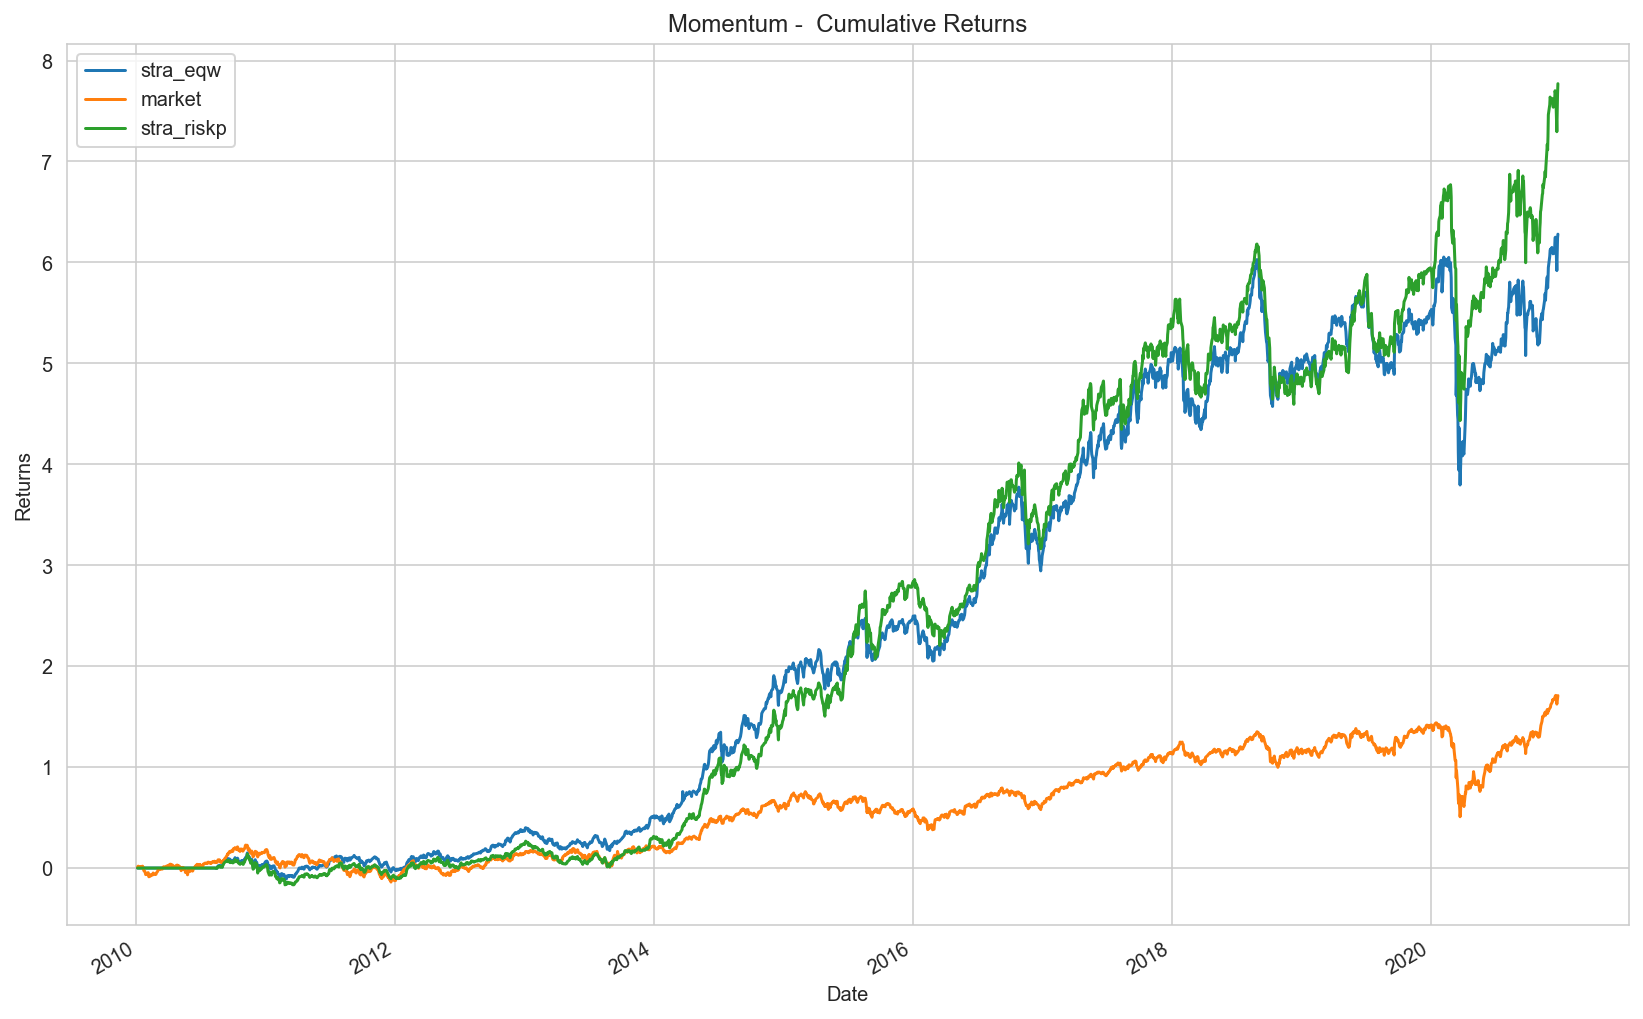

In [51]:
# Visulize the output
ax = ((1 * ret_df + 1).cumprod()-1).plot(figsize=(14,9), title='Momentum -  Cumulative Returns')
ax.set_ylabel('Returns')
ax.grid(True)
ax.legend();

In [52]:
ret_cum = ((1 * ret_df + 1).cumprod()-1)
ret_cum.head()

,stra_eqw,market,stra_riskp
Date,,,
2010-01-04 00:00:00+00:00,0.0,0.006936,0.0
2010-01-05 00:00:00+00:00,0.0,0.016754,0.0
2010-01-06 00:00:00+00:00,0.0,0.018747,0.0
2010-01-07 00:00:00+00:00,0.0,0.014390,0.0
2010-01-08 00:00:00+00:00,0.0,0.011274,0.0


In [53]:
dtale.show(ret_cum, ignore_duplicate=True)

In [54]:
dtale.show(ret_df, ignore_duplicate=True)